In [1]:
import sys
# sys.path.append("/home/matthias/Documents/EmbeddedAI/deep-microcompression/")
sys.path.append("../../")

from development import (
    Sequential,
    BatchNorm2d,
    Conv2d,
    Linear,
    ReLU,
    MaxPool2d,
    Flatten, 

    EarlyStopper,
    Estimator,
    ConfigEncoder,
    
    QuantizationGranularity,
    QuantizationScheme
)

/home/matthias/Documents/EmbeddedAI/deep-microcompression/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import copy, itertools

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lenet5_file = f"lenet5_state_dict_25.pth"
log_compression_details_file = "lenet5_compression_log.csv"

hp_deployment_base_dir = "./HP HP Pavilion Laptop 15-cs3xxx/"
hp_src_dir = os.path.join(hp_deployment_base_dir, "src")
hp_include_dir = os.path.join(hp_deployment_base_dir, "include")

arduino_deployment_base_dir = "./Arduino Nano 33 BLE/"
arduino_src_dir = os.path.join(arduino_deployment_base_dir, "src")
arduino_include_dir = os.path.join(arduino_deployment_base_dir, "include")

arduino_uno_deployment_base_dir = "./Arduino Uno/"
arduino_uno_src_dir = os.path.join(arduino_uno_deployment_base_dir, "src")
arduino_uno_include_dir = os.path.join(arduino_uno_deployment_base_dir, "include")

NAS_PARAMS_FILE = "nas_parameters.pickle"
INPUT_SHAPE = (1, 28, 28)

DEVICE

/home/matthias/Documents/EmbeddedAI/deep-microcompression/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [4]:
LUCKY_NUMBER = 25

# Torch seeds
torch.manual_seed(LUCKY_NUMBER)
torch.cuda.manual_seed(LUCKY_NUMBER)

# cuDNN determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: for full reproducibility (at the cost of speed)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)

In [5]:
INPUT_SHAPE = (1, 28, 28)

data_transform = transforms.Compose([
    transforms.RandomCrop((24, 24)),
    transforms.Resize(INPUT_SHAPE[1:]),
    transforms.ToTensor(),
])

mnist_train_dataset = datasets.MNIST("../../../Datasets/", train=True, download=True, transform=data_transform)
mnist_test_dataset = datasets.MNIST("../../../Datasets/", train=False, download=True, transform=data_transform)

mnist_train_loader = data.DataLoader(mnist_train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), drop_last=False)
mnist_test_loader = data.DataLoader(mnist_test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), drop_last=False)

In [6]:
lenet5_model = Sequential(
    Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, pad=tuple([2]*4), bias=True),
    BatchNorm2d(num_features=6),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, padding=0),

    Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True),
    BatchNorm2d(num_features=16),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, padding=0),

    Flatten(),
    
    Linear(in_features=16*5*5, out_features=84, bias=True),
    ReLU(),
    Linear(in_features=84, out_features=10, bias=True),
).to(DEVICE)

accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).to(torch.float).mean().item()*100

In [7]:
try:
    # raise(RuntimeError)
    lenet5_model.cpu()
    lenet5_model.load_state_dict(torch.load(lenet5_file, weights_only=True), strict=True)
    lenet5_model.to(DEVICE)

except (RuntimeError, FileNotFoundError) as e:
    early_stopper = EarlyStopper(
        monitor_metric="validation_loss",
        delta=1e-7,
        mode="min",
        patience=4,
        restore_best_state_dict=True,
    )

    criterion_fun = nn.CrossEntropyLoss()
    optimizion_fun = optim.Adam(lenet5_model.parameters(), lr=1.e-3)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

    lenet5_model.fit(
        mnist_train_loader, 20, 
        criterion_fun, optimizion_fun,
        # lr_scheduler,
        validation_dataloader=mnist_test_loader, 
        metrics={"acc" : accuracy_fun},
        # callbacks=[early_stopper],
        device=DEVICE
    )
    lenet5_model.cpu()
    torch.save(lenet5_model.state_dict(), lenet5_file)
    lenet5_model.to(DEVICE)

print(f"The accuracy of the base model has an accuracy of {lenet5_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)["acc"]}")


The accuracy of the base model has an accuracy of 99.05


## NAS for Channel Pruning
We generated 1000 samples, which is about 2.5% of the total possible hyperparameter. 6*16*400

In [8]:
nas_parameters = []
if os.path.exists(NAS_PARAMS_FILE):
    nas_parameters = torch.load(NAS_PARAMS_FILE)
    assert len(nas_parameters) == 1000, "params in nas file is not 1000"

else:
    nas_parameters = lenet5_model.get_nas_prune_channel(
        INPUT_SHAPE, mnist_test_loader, accuracy_fun, DEVICE, 
        num_data=1000, train=True, train_dataloader=mnist_train_loader, epochs=2, 
        criterion_fun= nn.CrossEntropyLoss(), random_seed=LUCKY_NUMBER
    )
    torch.save(nas_parameters, NAS_PARAMS_FILE)

In [9]:
nas_parameters

[[4, 1, 54, 96.94],
 [3, 0, 26, 98.5],
 [3, 15, 35, 82.73],
 [5, 5, 4, 96.39],
 [4, 15, 41, 80.48],
 [0, 7, 46, 98.42],
 [0, 13, 17, 96.39],
 [4, 11, 48, 94.89],
 [3, 9, 33, 96.59],
 [3, 5, 38, 98.22],
 [5, 11, 17, 94.21],
 [3, 7, 56, 97.08],
 [4, 12, 5, 94.01],
 [4, 0, 30, 97.3],
 [1, 6, 38, 98.42],
 [4, 11, 30, 94.92],
 [2, 14, 55, 92.66],
 [3, 2, 83, 31.0],
 [4, 10, 64, 94.58],
 [1, 7, 52, 97.93],
 [1, 1, 4, 99.13],
 [3, 9, 77, 92.86],
 [5, 2, 68, 94.51],
 [0, 4, 49, 98.79],
 [4, 11, 76, 90.73],
 [1, 3, 12, 98.85],
 [3, 5, 24, 97.97],
 [2, 13, 53, 95.04],
 [3, 7, 35, 97.54],
 [1, 5, 15, 98.89],
 [2, 14, 38, 92.58],
 [1, 5, 22, 98.69],
 [3, 11, 41, 95.81],
 [3, 7, 0, 97.7],
 [4, 1, 42, 97.33],
 [2, 7, 10, 98.09],
 [2, 14, 51, 91.66],
 [4, 5, 49, 96.88],
 [3, 7, 67, 96.37],
 [2, 15, 77, 77.54],
 [3, 2, 21, 98.18],
 [3, 14, 51, 91.04],
 [1, 13, 69, 94.28],
 [4, 11, 68, 93.45],
 [3, 15, 21, 81.22],
 [4, 14, 12, 90.28],
 [3, 1, 0, 98.34],
 [3, 2, 6, 98.38],
 [2, 2, 19, 98.73],
 [0, 14, 6

## Channel Prunner Estiamtor

In [12]:
estimator = Estimator(nas_parameters, device=DEVICE, hidden_dim=[128, 128, 128], dropout=.75)
estimator_history = estimator.fit(epochs=400)

DMC Training (Epochs 1-400):   0%|          | 0/400 [00:00<?, ?it/s]

epoch    0 | train loss 8801.1273 | validation loss 8887.1367 | train mse 8801.1273 | validation mse 8887.1363 | train rmse 93.8053 | validation rmse 94.2698 | train abs 93.2389 | validation abs 94.0681


DMC Training (Epochs 1-400):   0%|          | 2/400 [00:00<00:32, 12.09it/s]

epoch    1 | train loss 8676.8816 | validation loss 8821.8086 | train mse 8676.8816 | validation mse 8821.8093 | train rmse 93.1478 | validation rmse 93.9227 | train abs 92.5710 | validation abs 93.7217


epoch    2 | train loss 8557.1076 | validation loss 8757.2158 | train mse 8557.1076 | validation mse 8757.2162 | train rmse 92.5011 | validation rmse 93.5782 | train abs 91.9083 | validation abs 93.3782


DMC Training (Epochs 1-400):   1%|          | 4/400 [00:00<00:42,  9.23it/s]

epoch    3 | train loss 8425.9643 | validation loss 8689.5986 | train mse 8425.9643 | validation mse 8689.5987 | train rmse 91.7870 | validation rmse 93.2162 | train abs 91.1991 | validation abs 93.0185


epoch    4 | train loss 8292.9927 | validation loss 8600.3438 | train mse 8292.9927 | validation mse 8600.3439 | train rmse 91.0639 | validation rmse 92.7363 | train abs 90.4764 | validation abs 92.5421


DMC Training (Epochs 1-400):   2%|▏         | 6/400 [00:00<00:34, 11.30it/s]

epoch    5 | train loss 8155.5623 | validation loss 8503.6699 | train mse 8155.5623 | validation mse 8503.6692 | train rmse 90.3016 | validation rmse 92.2137 | train abs 89.7003 | validation abs 92.0227


epoch    6 | train loss 8005.9188 | validation loss 8388.1064 | train mse 8005.9188 | validation mse 8388.1065 | train rmse 89.4716 | validation rmse 91.5850 | train abs 88.8494 | validation abs 91.3975


DMC Training (Epochs 1-400):   2%|▏         | 8/400 [00:00<00:30, 12.66it/s]

epoch    7 | train loss 7835.0216 | validation loss 8245.6328 | train mse 7835.0216 | validation mse 8245.6330 | train rmse 88.5083 | validation rmse 90.8040 | train abs 87.9023 | validation abs 90.6200


epoch    8 | train loss 7690.3280 | validation loss 8095.1421 | train mse 7690.3280 | validation mse 8095.1421 | train rmse 87.6898 | validation rmse 89.9715 | train abs 87.0753 | validation abs 89.7916


DMC Training (Epochs 1-400):   2%|▎         | 10/400 [00:00<00:37, 10.43it/s]

epoch    9 | train loss 7520.7296 | validation loss 7931.0083 | train mse 7520.7296 | validation mse 7931.0077 | train rmse 86.7185 | validation rmse 89.0549 | train abs 86.0891 | validation abs 88.8814


epoch   10 | train loss 7319.2232 | validation loss 7747.5918 | train mse 7319.2232 | validation mse 7747.5919 | train rmse 85.5485 | validation rmse 88.0191 | train abs 84.8980 | validation abs 87.8519


DMC Training (Epochs 1-400):   3%|▎         | 12/400 [00:01<00:33, 11.47it/s]

epoch   11 | train loss 7149.0562 | validation loss 7535.3306 | train mse 7149.0562 | validation mse 7535.3309 | train rmse 84.5492 | validation rmse 86.8052 | train abs 83.8828 | validation abs 86.6438


epoch   12 | train loss 6951.7445 | validation loss 7350.6235 | train mse 6951.7445 | validation mse 7350.6236 | train rmse 83.3718 | validation rmse 85.7347 | train abs 82.6915 | validation abs 85.5782


DMC Training (Epochs 1-400):   4%|▎         | 14/400 [00:01<00:33, 11.67it/s]

epoch   13 | train loss 6750.8235 | validation loss 7136.9512 | train mse 6750.8235 | validation mse 7136.9514 | train rmse 82.1591 | validation rmse 84.4795 | train abs 81.4665 | validation abs 84.3314


epoch   14 | train loss 6487.2863 | validation loss 6840.5918 | train mse 6487.2863 | validation mse 6840.5916 | train rmse 80.5380 | validation rmse 82.7071 | train abs 79.8657 | validation abs 82.5665


DMC Training (Epochs 1-400):   4%|▍         | 16/400 [00:01<00:30, 12.42it/s]

epoch   15 | train loss 6271.2968 | validation loss 6596.2725 | train mse 6271.2968 | validation mse 6596.2730 | train rmse 79.1837 | validation rmse 81.2169 | train abs 78.4133 | validation abs 81.0810


epoch   16 | train loss 6086.0089 | validation loss 6349.8413 | train mse 6086.0089 | validation mse 6349.8409 | train rmse 78.0061 | validation rmse 79.6855 | train abs 77.2898 | validation abs 79.5580


DMC Training (Epochs 1-400):   4%|▍         | 18/400 [00:01<00:28, 13.47it/s]

epoch   17 | train loss 5813.5117 | validation loss 6047.7695 | train mse 5813.5117 | validation mse 6047.7693 | train rmse 76.2356 | validation rmse 77.7672 | train abs 75.4782 | validation abs 77.6404


epoch   18 | train loss 5568.7361 | validation loss 5760.4312 | train mse 5568.7361 | validation mse 5760.4314 | train rmse 74.6127 | validation rmse 75.8974 | train abs 73.7187 | validation abs 75.7685


DMC Training (Epochs 1-400):   5%|▌         | 20/400 [00:01<00:27, 13.91it/s]

epoch   19 | train loss 5307.4796 | validation loss 5482.3887 | train mse 5307.4796 | validation mse 5482.3888 | train rmse 72.8385 | validation rmse 74.0430 | train abs 71.9583 | validation abs 73.9059


epoch   20 | train loss 5016.0331 | validation loss 5214.5361 | train mse 5016.0331 | validation mse 5214.5359 | train rmse 70.8083 | validation rmse 72.2115 | train abs 69.9084 | validation abs 72.0647


DMC Training (Epochs 1-400):   6%|▌         | 22/400 [00:01<00:28, 13.30it/s]

epoch   21 | train loss 4804.3519 | validation loss 4956.4224 | train mse 4804.3519 | validation mse 4956.4223 | train rmse 69.3083 | validation rmse 70.4014 | train abs 68.3443 | validation abs 70.2370


epoch   22 | train loss 4598.3509 | validation loss 4642.1025 | train mse 4598.3509 | validation mse 4642.1028 | train rmse 67.7965 | validation rmse 68.1321 | train abs 66.7811 | validation abs 67.9467


DMC Training (Epochs 1-400):   6%|▌         | 24/400 [00:02<00:34, 10.92it/s]

epoch   23 | train loss 4322.8390 | validation loss 4331.9658 | train mse 4322.8390 | validation mse 4331.9656 | train rmse 65.7235 | validation rmse 65.8161 | train abs 64.5969 | validation abs 65.5862


epoch   24 | train loss 4095.8644 | validation loss 4150.3887 | train mse 4095.8644 | validation mse 4150.3884 | train rmse 63.9770 | validation rmse 64.4208 | train abs 62.7085 | validation abs 64.1234


DMC Training (Epochs 1-400):   6%|▋         | 26/400 [00:02<00:30, 12.30it/s]

epoch   25 | train loss 3840.7468 | validation loss 3828.6284 | train mse 3840.7468 | validation mse 3828.6286 | train rmse 61.9578 | validation rmse 61.8727 | train abs 60.6435 | validation abs 61.5420


epoch   26 | train loss 3589.0975 | validation loss 3604.8713 | train mse 3589.0975 | validation mse 3604.8712 | train rmse 59.8956 | validation rmse 60.0362 | train abs 58.6175 | validation abs 59.6757


DMC Training (Epochs 1-400):   7%|▋         | 28/400 [00:02<00:28, 13.28it/s]

epoch   27 | train loss 3363.8641 | validation loss 3286.3757 | train mse 3363.8641 | validation mse 3286.3759 | train rmse 57.9781 | validation rmse 57.3215 | train abs 56.4835 | validation abs 56.9173


epoch   28 | train loss 3132.5137 | validation loss 2993.6299 | train mse 3132.5137 | validation mse 2993.6301 | train rmse 55.9391 | validation rmse 54.7072 | train abs 54.3104 | validation abs 54.2203


DMC Training (Epochs 1-400):   8%|▊         | 30/400 [00:02<00:26, 14.21it/s]

epoch   29 | train loss 2982.6318 | validation loss 2717.7920 | train mse 2982.6318 | validation mse 2717.7920 | train rmse 54.5821 | validation rmse 52.1242 | train abs 52.8363 | validation abs 51.5717


epoch   30 | train loss 2731.2631 | validation loss 2465.3855 | train mse 2731.2631 | validation mse 2465.3853 | train rmse 52.2289 | validation rmse 49.6414 | train abs 50.4724 | validation abs 48.9632


DMC Training (Epochs 1-400):   8%|▊         | 32/400 [00:02<00:24, 14.83it/s]

epoch   31 | train loss 2486.9150 | validation loss 2344.4966 | train mse 2486.9150 | validation mse 2344.4964 | train rmse 49.8574 | validation rmse 48.4080 | train abs 48.0714 | validation abs 47.6337


epoch   32 | train loss 2232.2458 | validation loss 2210.6316 | train mse 2232.2458 | validation mse 2210.6316 | train rmse 47.2270 | validation rmse 47.0063 | train abs 45.1586 | validation abs 46.2186


DMC Training (Epochs 1-400):   8%|▊         | 34/400 [00:02<00:23, 15.41it/s]

epoch   33 | train loss 2158.9213 | validation loss 1969.0928 | train mse 2158.9213 | validation mse 1969.0927 | train rmse 46.4163 | validation rmse 44.3611 | train abs 44.1812 | validation abs 43.5489


epoch   34 | train loss 2008.3986 | validation loss 1751.9567 | train mse 2008.3986 | validation mse 1751.9567 | train rmse 44.7738 | validation rmse 41.8398 | train abs 42.3695 | validation abs 40.9615


DMC Training (Epochs 1-400):   9%|▉         | 36/400 [00:02<00:23, 15.78it/s]

epoch   35 | train loss 1865.8575 | validation loss 1568.8058 | train mse 1865.8575 | validation mse 1568.8057 | train rmse 43.1727 | validation rmse 39.5879 | train abs 40.5630 | validation abs 38.6085


epoch   36 | train loss 1711.7501 | validation loss 1445.3794 | train mse 1711.7501 | validation mse 1445.3794 | train rmse 41.3525 | validation rmse 37.9971 | train abs 38.2079 | validation abs 36.9629


DMC Training (Epochs 1-400):  10%|▉         | 38/400 [00:02<00:24, 14.73it/s]

epoch   37 | train loss 1572.1887 | validation loss 1354.3231 | train mse 1572.1887 | validation mse 1354.3231 | train rmse 39.6420 | validation rmse 36.7802 | train abs 36.6130 | validation abs 35.6758


epoch   38 | train loss 1416.3035 | validation loss 1244.4314 | train mse 1416.3035 | validation mse 1244.4314 | train rmse 37.5599 | validation rmse 35.2548 | train abs 34.2500 | validation abs 34.0353


DMC Training (Epochs 1-400):  10%|█         | 40/400 [00:03<00:24, 14.78it/s]

epoch   39 | train loss 1294.1482 | validation loss 1122.7312 | train mse 1294.1482 | validation mse 1122.7313 | train rmse 35.9469 | validation rmse 33.4876 | train abs 32.6408 | validation abs 32.3556


epoch   40 | train loss 1230.3775 | validation loss 1035.1096 | train mse 1230.3775 | validation mse 1035.1095 | train rmse 35.0169 | validation rmse 32.1473 | train abs 31.5321 | validation abs 31.0014


DMC Training (Epochs 1-400):  10%|█         | 42/400 [00:03<00:23, 15.40it/s]

epoch   41 | train loss 1102.0527 | validation loss 977.0757 | train mse 1102.0527 | validation mse 977.0757 | train rmse 33.1436 | validation rmse 31.2323 | train abs 29.5181 | validation abs 30.0814


epoch   42 | train loss 1011.5927 | validation loss 869.5199 | train mse 1011.5927 | validation mse 869.5199 | train rmse 31.7613 | validation rmse 29.4611 | train abs 27.9802 | validation abs 28.2660


DMC Training (Epochs 1-400):  11%|█         | 44/400 [00:03<00:22, 15.50it/s]

epoch   43 | train loss 963.0510 | validation loss 852.1588 | train mse 963.0510 | validation mse 852.1588 | train rmse 31.0095 | validation rmse 29.1623 | train abs 27.0666 | validation abs 27.9042


epoch   44 | train loss 912.3729 | validation loss 808.6154 | train mse 912.3729 | validation mse 808.6154 | train rmse 30.1176 | validation rmse 28.4048 | train abs 25.9687 | validation abs 27.0718


DMC Training (Epochs 1-400):  12%|█▏        | 46/400 [00:03<00:23, 15.08it/s]

epoch   45 | train loss 853.0059 | validation loss 719.3707 | train mse 853.0059 | validation mse 719.3707 | train rmse 29.0855 | validation rmse 26.7876 | train abs 25.2238 | validation abs 25.4016


epoch   46 | train loss 820.6307 | validation loss 676.2436 | train mse 820.6307 | validation mse 676.2435 | train rmse 28.5765 | validation rmse 25.9711 | train abs 24.6465 | validation abs 24.5493


DMC Training (Epochs 1-400):  12%|█▏        | 48/400 [00:03<00:22, 15.66it/s]

epoch   47 | train loss 732.1244 | validation loss 579.8832 | train mse 732.1244 | validation mse 579.8832 | train rmse 26.9654 | validation rmse 24.0471 | train abs 23.0908 | validation abs 22.5641


epoch   48 | train loss 726.9285 | validation loss 504.7176 | train mse 726.9285 | validation mse 504.7176 | train rmse 26.9038 | validation rmse 22.4306 | train abs 22.3395 | validation abs 20.9450


DMC Training (Epochs 1-400):  12%|█▎        | 50/400 [00:03<00:23, 15.20it/s]

epoch   49 | train loss 732.7949 | validation loss 523.0278 | train mse 732.7949 | validation mse 523.0279 | train rmse 27.0234 | validation rmse 22.8330 | train abs 22.8402 | validation abs 21.3259


epoch   50 | train loss 659.6089 | validation loss 495.3168 | train mse 659.6089 | validation mse 495.3168 | train rmse 25.6285 | validation rmse 22.2176 | train abs 21.2733 | validation abs 20.7556


DMC Training (Epochs 1-400):  13%|█▎        | 52/400 [00:03<00:21, 16.16it/s]

epoch   51 | train loss 585.7122 | validation loss 469.5927 | train mse 585.7122 | validation mse 469.5927 | train rmse 24.1372 | validation rmse 21.6317 | train abs 20.2876 | validation abs 20.1842


epoch   52 | train loss 606.5049 | validation loss 482.9822 | train mse 606.5049 | validation mse 482.9822 | train rmse 24.5132 | validation rmse 21.9327 | train abs 20.2426 | validation abs 20.2504


epoch   53 | train loss 609.9972 | validation loss 446.7171 | train mse 609.9972 | validation mse 446.7171 | train rmse 24.6402 | validation rmse 21.0819 | train abs 20.3247 | validation abs 19.0420


DMC Training (Epochs 1-400):  14%|█▍        | 55/400 [00:03<00:19, 17.75it/s]

epoch   54 | train loss 638.4263 | validation loss 439.1410 | train mse 638.4263 | validation mse 439.1409 | train rmse 25.2245 | validation rmse 20.8981 | train abs 20.8020 | validation abs 18.3981


epoch   55 | train loss 557.8617 | validation loss 397.4086 | train mse 557.8617 | validation mse 397.4087 | train rmse 23.5406 | validation rmse 19.8753 | train abs 19.0877 | validation abs 17.2191


epoch   56 | train loss 600.1000 | validation loss 379.1373 | train mse 600.1000 | validation mse 379.1373 | train rmse 24.4345 | validation rmse 19.4211 | train abs 19.8578 | validation abs 16.7806


DMC Training (Epochs 1-400):  14%|█▍        | 58/400 [00:04<00:18, 18.52it/s]

epoch   57 | train loss 529.8709 | validation loss 351.7592 | train mse 529.8709 | validation mse 351.7593 | train rmse 22.9578 | validation rmse 18.6986 | train abs 18.7769 | validation abs 15.8604


epoch   58 | train loss 561.8864 | validation loss 294.9242 | train mse 561.8864 | validation mse 294.9242 | train rmse 23.6673 | validation rmse 17.1101 | train abs 19.1260 | validation abs 14.5110


DMC Training (Epochs 1-400):  15%|█▌        | 60/400 [00:04<00:18, 18.57it/s]

epoch   59 | train loss 506.1493 | validation loss 297.3182 | train mse 506.1493 | validation mse 297.3182 | train rmse 22.2776 | validation rmse 17.1777 | train abs 17.8849 | validation abs 14.2673


epoch   60 | train loss 549.1216 | validation loss 295.1573 | train mse 549.1216 | validation mse 295.1572 | train rmse 23.3093 | validation rmse 17.1152 | train abs 18.7914 | validation abs 14.2400


DMC Training (Epochs 1-400):  16%|█▌        | 62/400 [00:04<00:18, 18.35it/s]

epoch   61 | train loss 519.3249 | validation loss 274.4148 | train mse 519.3249 | validation mse 274.4148 | train rmse 22.6897 | validation rmse 16.5072 | train abs 18.3341 | validation abs 14.1081


epoch   62 | train loss 510.0095 | validation loss 261.6433 | train mse 510.0095 | validation mse 261.6433 | train rmse 22.5312 | validation rmse 16.1227 | train abs 18.1195 | validation abs 13.9549


epoch   63 | train loss 571.8484 | validation loss 294.8476 | train mse 571.8484 | validation mse 294.8476 | train rmse 23.8243 | validation rmse 17.1170 | train abs 18.9353 | validation abs 15.1721


DMC Training (Epochs 1-400):  16%|█▋        | 65/400 [00:04<00:17, 19.21it/s]

epoch   64 | train loss 544.2016 | validation loss 322.7894 | train mse 544.2016 | validation mse 322.7894 | train rmse 23.2289 | validation rmse 17.9009 | train abs 18.5406 | validation abs 15.7105


epoch   65 | train loss 515.1230 | validation loss 286.7478 | train mse 515.1230 | validation mse 286.7478 | train rmse 22.6161 | validation rmse 16.8653 | train abs 18.1535 | validation abs 14.5338


DMC Training (Epochs 1-400):  17%|█▋        | 67/400 [00:04<00:17, 19.02it/s]

epoch   66 | train loss 545.6287 | validation loss 274.7719 | train mse 545.6287 | validation mse 274.7719 | train rmse 23.2708 | validation rmse 16.5072 | train abs 18.8663 | validation abs 13.9138


epoch   67 | train loss 540.3155 | validation loss 279.9583 | train mse 540.3155 | validation mse 279.9583 | train rmse 23.1345 | validation rmse 16.6710 | train abs 18.6879 | validation abs 14.2514


epoch   68 | train loss 539.4249 | validation loss 255.9253 | train mse 539.4249 | validation mse 255.9253 | train rmse 23.0996 | validation rmse 15.9257 | train abs 18.4055 | validation abs 13.2715


DMC Training (Epochs 1-400):  18%|█▊        | 70/400 [00:04<00:16, 19.80it/s]

epoch   69 | train loss 473.8765 | validation loss 290.3955 | train mse 473.8765 | validation mse 290.3955 | train rmse 21.6714 | validation rmse 16.9606 | train abs 17.4019 | validation abs 14.1246


epoch   70 | train loss 528.3645 | validation loss 310.6254 | train mse 528.3645 | validation mse 310.6253 | train rmse 22.8176 | validation rmse 17.5398 | train abs 18.1261 | validation abs 14.1615


epoch   71 | train loss 480.0560 | validation loss 286.0177 | train mse 480.0560 | validation mse 286.0177 | train rmse 21.8068 | validation rmse 16.8260 | train abs 17.5604 | validation abs 13.2952


DMC Training (Epochs 1-400):  18%|█▊        | 73/400 [00:04<00:15, 20.53it/s]

epoch   72 | train loss 546.1978 | validation loss 253.2012 | train mse 546.1978 | validation mse 253.2013 | train rmse 23.2964 | validation rmse 15.8212 | train abs 18.4740 | validation abs 12.6722


epoch   73 | train loss 500.3041 | validation loss 220.6512 | train mse 500.3041 | validation mse 220.6512 | train rmse 22.2809 | validation rmse 14.7583 | train abs 17.7963 | validation abs 11.8857


epoch   74 | train loss 522.7270 | validation loss 226.0739 | train mse 522.7270 | validation mse 226.0738 | train rmse 22.8107 | validation rmse 14.9522 | train abs 18.7161 | validation abs 12.3146


DMC Training (Epochs 1-400):  19%|█▉        | 76/400 [00:04<00:15, 20.78it/s]

epoch   75 | train loss 538.7206 | validation loss 240.6895 | train mse 538.7206 | validation mse 240.6895 | train rmse 23.1316 | validation rmse 15.4366 | train abs 18.4036 | validation abs 12.7031


epoch   76 | train loss 499.9034 | validation loss 226.1562 | train mse 499.9034 | validation mse 226.1563 | train rmse 22.2324 | validation rmse 14.9586 | train abs 17.9531 | validation abs 12.1076


epoch   77 | train loss 550.1880 | validation loss 230.2170 | train mse 550.1880 | validation mse 230.2170 | train rmse 23.3086 | validation rmse 15.0785 | train abs 18.7120 | validation abs 12.1495


DMC Training (Epochs 1-400):  20%|█▉        | 79/400 [00:05<00:15, 21.27it/s]

epoch   78 | train loss 519.6529 | validation loss 235.9591 | train mse 519.6529 | validation mse 235.9591 | train rmse 22.7626 | validation rmse 15.2624 | train abs 17.9090 | validation abs 12.2067


epoch   79 | train loss 495.2962 | validation loss 262.4519 | train mse 495.2962 | validation mse 262.4519 | train rmse 22.1664 | validation rmse 16.1016 | train abs 17.7172 | validation abs 12.8644


epoch   80 | train loss 488.8523 | validation loss 251.3205 | train mse 488.8523 | validation mse 251.3205 | train rmse 21.9492 | validation rmse 15.7460 | train abs 17.2624 | validation abs 12.2698


DMC Training (Epochs 1-400):  20%|██        | 82/400 [00:05<00:16, 19.41it/s]

epoch   81 | train loss 507.7790 | validation loss 239.0893 | train mse 507.7790 | validation mse 239.0893 | train rmse 22.4281 | validation rmse 15.3428 | train abs 18.0190 | validation abs 11.7946


epoch   82 | train loss 546.9463 | validation loss 242.0817 | train mse 546.9463 | validation mse 242.0817 | train rmse 23.2347 | validation rmse 15.4548 | train abs 18.6292 | validation abs 12.0721


DMC Training (Epochs 1-400):  21%|██        | 84/400 [00:05<00:17, 17.70it/s]

epoch   83 | train loss 501.7349 | validation loss 223.9506 | train mse 501.7349 | validation mse 223.9506 | train rmse 22.2627 | validation rmse 14.8701 | train abs 17.5798 | validation abs 11.4516


epoch   84 | train loss 552.8981 | validation loss 219.2809 | train mse 552.8981 | validation mse 219.2809 | train rmse 23.4034 | validation rmse 14.7185 | train abs 18.5959 | validation abs 11.4403


epoch   85 | train loss 483.9689 | validation loss 230.8133 | train mse 483.9689 | validation mse 230.8133 | train rmse 21.8820 | validation rmse 15.1020 | train abs 17.2588 | validation abs 11.9106


DMC Training (Epochs 1-400):  22%|██▏       | 87/400 [00:05<00:16, 18.55it/s]

epoch   86 | train loss 515.9196 | validation loss 240.3451 | train mse 515.9196 | validation mse 240.3451 | train rmse 22.5154 | validation rmse 15.4070 | train abs 17.8657 | validation abs 11.6450


epoch   87 | train loss 448.5335 | validation loss 283.9942 | train mse 448.5335 | validation mse 283.9942 | train rmse 21.0455 | validation rmse 16.7571 | train abs 16.7687 | validation abs 12.8384


epoch   88 | train loss 495.6378 | validation loss 277.9334 | train mse 495.6378 | validation mse 277.9334 | train rmse 22.1657 | validation rmse 16.5602 | train abs 17.8769 | validation abs 12.3586


DMC Training (Epochs 1-400):  22%|██▎       | 90/400 [00:05<00:16, 19.37it/s]

epoch   89 | train loss 529.0864 | validation loss 286.6423 | train mse 529.0864 | validation mse 286.6423 | train rmse 22.9045 | validation rmse 16.8252 | train abs 18.1582 | validation abs 12.5320


epoch   90 | train loss 471.1391 | validation loss 267.2631 | train mse 471.1391 | validation mse 267.2631 | train rmse 21.5598 | validation rmse 16.2450 | train abs 17.0852 | validation abs 11.9794


epoch   91 | train loss 456.9034 | validation loss 280.0675 | train mse 456.9034 | validation mse 280.0675 | train rmse 21.2642 | validation rmse 16.6389 | train abs 16.9521 | validation abs 12.5641


DMC Training (Epochs 1-400):  23%|██▎       | 93/400 [00:05<00:15, 19.80it/s]

epoch   92 | train loss 538.3872 | validation loss 255.9798 | train mse 538.3872 | validation mse 255.9798 | train rmse 23.1291 | validation rmse 15.8995 | train abs 18.4105 | validation abs 12.0776


epoch   93 | train loss 533.8336 | validation loss 262.7940 | train mse 533.8336 | validation mse 262.7940 | train rmse 23.0046 | validation rmse 16.1171 | train abs 18.3065 | validation abs 12.2725


epoch   94 | train loss 458.2139 | validation loss 235.0488 | train mse 458.2139 | validation mse 235.0488 | train rmse 21.2794 | validation rmse 15.2438 | train abs 16.9586 | validation abs 11.5440


DMC Training (Epochs 1-400):  24%|██▍       | 96/400 [00:06<00:15, 20.09it/s]

epoch   95 | train loss 482.5407 | validation loss 269.5096 | train mse 482.5407 | validation mse 269.5096 | train rmse 21.9051 | validation rmse 16.3371 | train abs 17.4110 | validation abs 12.5569


epoch   96 | train loss 525.3727 | validation loss 279.5691 | train mse 525.3727 | validation mse 279.5691 | train rmse 22.7652 | validation rmse 16.6387 | train abs 18.1847 | validation abs 12.8415


epoch   97 | train loss 483.5053 | validation loss 255.2707 | train mse 483.5053 | validation mse 255.2707 | train rmse 21.8424 | validation rmse 15.8814 | train abs 17.0348 | validation abs 12.1953


DMC Training (Epochs 1-400):  25%|██▍       | 99/400 [00:06<00:14, 20.13it/s]

epoch   98 | train loss 504.4302 | validation loss 248.0288 | train mse 504.4302 | validation mse 248.0288 | train rmse 22.4253 | validation rmse 15.6461 | train abs 17.8580 | validation abs 11.9753


epoch   99 | train loss 455.2610 | validation loss 246.7664 | train mse 455.2610 | validation mse 246.7664 | train rmse 21.3012 | validation rmse 15.5878 | train abs 16.9274 | validation abs 11.7803


epoch  100 | train loss 496.8031 | validation loss 224.0331 | train mse 496.8031 | validation mse 224.0331 | train rmse 22.2392 | validation rmse 14.8461 | train abs 17.4258 | validation abs 11.1462


DMC Training (Epochs 1-400):  26%|██▌       | 102/400 [00:06<00:14, 20.52it/s]

epoch  101 | train loss 493.0568 | validation loss 257.4463 | train mse 493.0568 | validation mse 257.4463 | train rmse 22.0976 | validation rmse 15.9357 | train abs 17.6829 | validation abs 12.1055


epoch  102 | train loss 499.9152 | validation loss 257.9674 | train mse 499.9152 | validation mse 257.9673 | train rmse 22.2825 | validation rmse 15.9491 | train abs 17.3835 | validation abs 11.9690


epoch  103 | train loss 476.7312 | validation loss 262.9896 | train mse 476.7312 | validation mse 262.9897 | train rmse 21.7781 | validation rmse 16.1144 | train abs 17.2949 | validation abs 12.1935


DMC Training (Epochs 1-400):  26%|██▋       | 105/400 [00:06<00:14, 20.64it/s]

epoch  104 | train loss 511.1021 | validation loss 260.2493 | train mse 511.1021 | validation mse 260.2493 | train rmse 22.5484 | validation rmse 16.0394 | train abs 17.8732 | validation abs 12.3624


epoch  105 | train loss 522.0288 | validation loss 276.8812 | train mse 522.0288 | validation mse 276.8812 | train rmse 22.7545 | validation rmse 16.5562 | train abs 17.7435 | validation abs 13.0184


epoch  106 | train loss 488.5681 | validation loss 313.7505 | train mse 488.5681 | validation mse 313.7505 | train rmse 21.9959 | validation rmse 17.6312 | train abs 17.5971 | validation abs 13.9257


DMC Training (Epochs 1-400):  27%|██▋       | 108/400 [00:06<00:16, 18.07it/s]

epoch  107 | train loss 530.6132 | validation loss 262.0095 | train mse 530.6132 | validation mse 262.0095 | train rmse 22.8920 | validation rmse 16.1039 | train abs 18.3347 | validation abs 12.6682


epoch  108 | train loss 526.2678 | validation loss 271.6489 | train mse 526.2678 | validation mse 271.6489 | train rmse 22.8658 | validation rmse 16.4022 | train abs 18.2392 | validation abs 13.1944


DMC Training (Epochs 1-400):  28%|██▊       | 110/400 [00:06<00:15, 18.38it/s]

epoch  109 | train loss 534.7362 | validation loss 282.5447 | train mse 534.7362 | validation mse 282.5447 | train rmse 23.0413 | validation rmse 16.7282 | train abs 18.3699 | validation abs 13.2849


epoch  110 | train loss 500.7907 | validation loss 291.7185 | train mse 500.7907 | validation mse 291.7185 | train rmse 22.3222 | validation rmse 16.9989 | train abs 17.7842 | validation abs 13.6269


epoch  111 | train loss 518.5856 | validation loss 290.4017 | train mse 518.5856 | validation mse 290.4017 | train rmse 22.6794 | validation rmse 16.9553 | train abs 17.7946 | validation abs 13.4246


DMC Training (Epochs 1-400):  28%|██▊       | 113/400 [00:06<00:15, 18.86it/s]

epoch  112 | train loss 457.0713 | validation loss 271.9823 | train mse 457.0713 | validation mse 271.9823 | train rmse 21.2472 | validation rmse 16.4037 | train abs 16.9194 | validation abs 12.7975


epoch  113 | train loss 463.7874 | validation loss 262.2818 | train mse 463.7874 | validation mse 262.2818 | train rmse 21.4614 | validation rmse 16.1043 | train abs 16.9566 | validation abs 12.3737


DMC Training (Epochs 1-400):  29%|██▉       | 115/400 [00:07<00:17, 16.20it/s]

epoch  114 | train loss 486.8494 | validation loss 305.3277 | train mse 486.8494 | validation mse 305.3277 | train rmse 21.9823 | validation rmse 17.3879 | train abs 17.3081 | validation abs 13.5783


epoch  115 | train loss 476.0069 | validation loss 277.9811 | train mse 476.0069 | validation mse 277.9811 | train rmse 21.6425 | validation rmse 16.5860 | train abs 17.3041 | validation abs 12.7385


DMC Training (Epochs 1-400):  29%|██▉       | 117/400 [00:07<00:18, 15.13it/s]

epoch  116 | train loss 467.2421 | validation loss 299.7738 | train mse 467.2421 | validation mse 299.7738 | train rmse 21.5510 | validation rmse 17.2295 | train abs 16.8174 | validation abs 13.3484


epoch  117 | train loss 442.4476 | validation loss 313.5094 | train mse 442.4476 | validation mse 313.5094 | train rmse 20.9535 | validation rmse 17.6141 | train abs 16.6171 | validation abs 13.7054


DMC Training (Epochs 1-400):  30%|██▉       | 119/400 [00:07<00:17, 16.17it/s]

epoch  118 | train loss 457.0013 | validation loss 291.5858 | train mse 457.0013 | validation mse 291.5858 | train rmse 21.3118 | validation rmse 16.9644 | train abs 16.9873 | validation abs 12.8519


epoch  119 | train loss 465.9111 | validation loss 290.9938 | train mse 465.9111 | validation mse 290.9938 | train rmse 21.4419 | validation rmse 16.9357 | train abs 16.9848 | validation abs 12.6482


DMC Training (Epochs 1-400):  30%|███       | 121/400 [00:07<00:16, 16.64it/s]

epoch  120 | train loss 485.2325 | validation loss 314.4947 | train mse 485.2325 | validation mse 314.4947 | train rmse 21.8970 | validation rmse 17.6262 | train abs 17.4218 | validation abs 13.3409


epoch  121 | train loss 487.8636 | validation loss 293.0293 | train mse 487.8636 | validation mse 293.0293 | train rmse 21.9794 | validation rmse 17.0063 | train abs 17.6448 | validation abs 12.6979


epoch  122 | train loss 462.0465 | validation loss 285.5165 | train mse 462.0465 | validation mse 285.5165 | train rmse 21.3950 | validation rmse 16.7708 | train abs 17.0041 | validation abs 12.4635


DMC Training (Epochs 1-400):  31%|███       | 124/400 [00:07<00:15, 18.13it/s]

epoch  123 | train loss 485.4311 | validation loss 271.1806 | train mse 485.4311 | validation mse 271.1806 | train rmse 21.9263 | validation rmse 16.3460 | train abs 17.4375 | validation abs 12.3518


epoch  124 | train loss 484.4894 | validation loss 248.1086 | train mse 484.4894 | validation mse 248.1086 | train rmse 21.9102 | validation rmse 15.6419 | train abs 17.3652 | validation abs 11.9693


epoch  125 | train loss 471.4217 | validation loss 243.2781 | train mse 471.4217 | validation mse 243.2781 | train rmse 21.6435 | validation rmse 15.4881 | train abs 16.9850 | validation abs 11.7340


DMC Training (Epochs 1-400):  32%|███▏      | 127/400 [00:07<00:14, 18.89it/s]

epoch  126 | train loss 451.8521 | validation loss 284.2226 | train mse 451.8521 | validation mse 284.2226 | train rmse 21.1860 | validation rmse 16.7549 | train abs 16.8910 | validation abs 12.8074


epoch  127 | train loss 488.5164 | validation loss 280.4735 | train mse 488.5164 | validation mse 280.4735 | train rmse 21.9356 | validation rmse 16.6319 | train abs 17.3533 | validation abs 12.4444


DMC Training (Epochs 1-400):  32%|███▏      | 129/400 [00:07<00:15, 17.28it/s]

epoch  128 | train loss 488.1798 | validation loss 288.4877 | train mse 488.1798 | validation mse 288.4877 | train rmse 21.9310 | validation rmse 16.8641 | train abs 17.5922 | validation abs 12.4903


epoch  129 | train loss 468.6769 | validation loss 291.8706 | train mse 468.6769 | validation mse 291.8706 | train rmse 21.5722 | validation rmse 16.9564 | train abs 17.0153 | validation abs 12.6032


DMC Training (Epochs 1-400):  33%|███▎      | 131/400 [00:08<00:15, 16.97it/s]

epoch  130 | train loss 411.3437 | validation loss 263.0211 | train mse 411.3437 | validation mse 263.0211 | train rmse 20.1477 | validation rmse 16.0898 | train abs 16.0211 | validation abs 12.0106


epoch  131 | train loss 460.7176 | validation loss 277.8693 | train mse 460.7176 | validation mse 277.8693 | train rmse 21.3082 | validation rmse 16.5413 | train abs 16.7813 | validation abs 12.4801


DMC Training (Epochs 1-400):  33%|███▎      | 133/400 [00:08<00:16, 16.69it/s]

epoch  132 | train loss 490.4047 | validation loss 283.9747 | train mse 490.4047 | validation mse 283.9747 | train rmse 22.0928 | validation rmse 16.7239 | train abs 17.4793 | validation abs 12.6678


epoch  133 | train loss 456.5890 | validation loss 311.6171 | train mse 456.5890 | validation mse 311.6171 | train rmse 21.2870 | validation rmse 17.5218 | train abs 16.9166 | validation abs 12.9946


DMC Training (Epochs 1-400):  34%|███▍      | 135/400 [00:08<00:17, 15.08it/s]

epoch  134 | train loss 488.8531 | validation loss 265.4418 | train mse 488.8531 | validation mse 265.4418 | train rmse 21.9941 | validation rmse 16.1649 | train abs 17.5770 | validation abs 12.1167


epoch  135 | train loss 485.0568 | validation loss 289.7313 | train mse 485.0568 | validation mse 289.7313 | train rmse 21.9002 | validation rmse 16.8979 | train abs 17.4873 | validation abs 12.4748


DMC Training (Epochs 1-400):  34%|███▍      | 137/400 [00:08<00:19, 13.40it/s]

epoch  136 | train loss 454.2850 | validation loss 273.1139 | train mse 454.2850 | validation mse 273.1138 | train rmse 21.2079 | validation rmse 16.3975 | train abs 17.0374 | validation abs 12.0239


epoch  137 | train loss 433.2585 | validation loss 257.5717 | train mse 433.2585 | validation mse 257.5717 | train rmse 20.7397 | validation rmse 15.9273 | train abs 16.5288 | validation abs 11.8412


DMC Training (Epochs 1-400):  35%|███▍      | 139/400 [00:08<00:21, 12.38it/s]

epoch  138 | train loss 476.6931 | validation loss 275.8069 | train mse 476.6931 | validation mse 275.8070 | train rmse 21.6926 | validation rmse 16.4914 | train abs 17.2752 | validation abs 12.3092


epoch  139 | train loss 438.7672 | validation loss 276.6054 | train mse 438.7672 | validation mse 276.6054 | train rmse 20.8248 | validation rmse 16.5135 | train abs 16.4677 | validation abs 12.2268


DMC Training (Epochs 1-400):  35%|███▌      | 141/400 [00:08<00:23, 10.96it/s]

epoch  140 | train loss 480.3045 | validation loss 263.8513 | train mse 480.3045 | validation mse 263.8512 | train rmse 21.8216 | validation rmse 16.1456 | train abs 17.2795 | validation abs 12.3503


epoch  141 | train loss 441.4075 | validation loss 276.3704 | train mse 441.4075 | validation mse 276.3704 | train rmse 20.9043 | validation rmse 16.5176 | train abs 16.7298 | validation abs 12.4473


DMC Training (Epochs 1-400):  36%|███▌      | 143/400 [00:09<00:24, 10.58it/s]

epoch  142 | train loss 468.0920 | validation loss 266.8375 | train mse 468.0920 | validation mse 266.8375 | train rmse 21.5162 | validation rmse 16.2238 | train abs 17.2176 | validation abs 12.3216


epoch  143 | train loss 404.3001 | validation loss 291.4705 | train mse 404.3001 | validation mse 291.4705 | train rmse 20.0870 | validation rmse 16.9677 | train abs 16.0148 | validation abs 13.0279


DMC Training (Epochs 1-400):  36%|███▋      | 145/400 [00:09<00:22, 11.32it/s]

epoch  144 | train loss 445.1281 | validation loss 269.7233 | train mse 445.1281 | validation mse 269.7233 | train rmse 21.0082 | validation rmse 16.3095 | train abs 16.8499 | validation abs 12.4659


epoch  145 | train loss 433.0650 | validation loss 262.6061 | train mse 433.0650 | validation mse 262.6061 | train rmse 20.6979 | validation rmse 16.1065 | train abs 16.3051 | validation abs 12.4634


DMC Training (Epochs 1-400):  37%|███▋      | 147/400 [00:09<00:21, 11.96it/s]

epoch  146 | train loss 494.7524 | validation loss 288.7099 | train mse 494.7524 | validation mse 288.7099 | train rmse 22.1155 | validation rmse 16.8884 | train abs 17.2819 | validation abs 13.0054


epoch  147 | train loss 463.1278 | validation loss 308.4395 | train mse 463.1278 | validation mse 308.4395 | train rmse 21.4669 | validation rmse 17.4477 | train abs 16.8520 | validation abs 13.2429


DMC Training (Epochs 1-400):  37%|███▋      | 149/400 [00:09<00:20, 12.26it/s]

epoch  148 | train loss 445.0559 | validation loss 286.2817 | train mse 445.0559 | validation mse 286.2817 | train rmse 21.0082 | validation rmse 16.7936 | train abs 16.6568 | validation abs 12.6052


epoch  149 | train loss 451.1350 | validation loss 261.0372 | train mse 451.1350 | validation mse 261.0372 | train rmse 21.1593 | validation rmse 16.0468 | train abs 16.8291 | validation abs 12.0755


DMC Training (Epochs 1-400):  38%|███▊      | 151/400 [00:09<00:19, 12.56it/s]

epoch  150 | train loss 480.7175 | validation loss 268.0629 | train mse 480.7175 | validation mse 268.0629 | train rmse 21.8633 | validation rmse 16.2564 | train abs 17.4333 | validation abs 12.2344


epoch  151 | train loss 453.7635 | validation loss 278.6811 | train mse 453.7635 | validation mse 278.6811 | train rmse 21.2337 | validation rmse 16.5620 | train abs 16.7231 | validation abs 12.2201


DMC Training (Epochs 1-400):  38%|███▊      | 153/400 [00:09<00:19, 12.85it/s]

epoch  152 | train loss 429.9670 | validation loss 306.9796 | train mse 429.9670 | validation mse 306.9796 | train rmse 20.5807 | validation rmse 17.3808 | train abs 16.2717 | validation abs 12.7685


epoch  153 | train loss 447.0948 | validation loss 291.0226 | train mse 447.0948 | validation mse 291.0226 | train rmse 21.0115 | validation rmse 16.9213 | train abs 16.7130 | validation abs 12.3421


DMC Training (Epochs 1-400):  39%|███▉      | 155/400 [00:10<00:18, 13.07it/s]

epoch  154 | train loss 440.1096 | validation loss 280.1338 | train mse 440.1096 | validation mse 280.1338 | train rmse 20.9110 | validation rmse 16.6049 | train abs 16.2775 | validation abs 12.0818


epoch  155 | train loss 463.4447 | validation loss 266.8415 | train mse 463.4447 | validation mse 266.8415 | train rmse 21.4347 | validation rmse 16.1851 | train abs 16.8271 | validation abs 11.7095


epoch  156 | train loss 474.5187 | validation loss 264.3500 | train mse 474.5187 | validation mse 264.3500 | train rmse 21.5885 | validation rmse 16.1160 | train abs 17.2617 | validation abs 11.7836


DMC Training (Epochs 1-400):  40%|███▉      | 158/400 [00:10<00:15, 15.29it/s]

epoch  157 | train loss 477.1134 | validation loss 283.5097 | train mse 477.1134 | validation mse 283.5097 | train rmse 21.7750 | validation rmse 16.7011 | train abs 17.4031 | validation abs 12.2981


epoch  158 | train loss 431.7831 | validation loss 296.8982 | train mse 431.7831 | validation mse 296.8982 | train rmse 20.7002 | validation rmse 17.0928 | train abs 16.5388 | validation abs 12.5636


epoch  159 | train loss 416.4967 | validation loss 306.9757 | train mse 416.4967 | validation mse 306.9757 | train rmse 20.3496 | validation rmse 17.3851 | train abs 16.1611 | validation abs 12.9215


DMC Training (Epochs 1-400):  40%|████      | 161/400 [00:10<00:14, 16.89it/s]

epoch  160 | train loss 434.1754 | validation loss 271.0374 | train mse 434.1754 | validation mse 271.0374 | train rmse 20.7771 | validation rmse 16.3289 | train abs 16.5132 | validation abs 12.0800


epoch  161 | train loss 437.4698 | validation loss 252.2825 | train mse 437.4698 | validation mse 252.2825 | train rmse 20.7760 | validation rmse 15.7559 | train abs 16.4750 | validation abs 11.8350


DMC Training (Epochs 1-400):  41%|████      | 163/400 [00:10<00:13, 17.42it/s]

epoch  162 | train loss 436.0854 | validation loss 319.0380 | train mse 436.0854 | validation mse 319.0379 | train rmse 20.7154 | validation rmse 17.7485 | train abs 16.5207 | validation abs 13.4715


epoch  163 | train loss 462.3351 | validation loss 257.3701 | train mse 462.3351 | validation mse 257.3701 | train rmse 21.3803 | validation rmse 15.9308 | train abs 16.7540 | validation abs 12.0003


DMC Training (Epochs 1-400):  41%|████▏     | 165/400 [00:10<00:13, 17.35it/s]

epoch  164 | train loss 451.4483 | validation loss 271.7999 | train mse 451.4483 | validation mse 271.7999 | train rmse 21.1326 | validation rmse 16.3783 | train abs 16.6984 | validation abs 12.4531


epoch  165 | train loss 440.7097 | validation loss 292.0681 | train mse 440.7097 | validation mse 292.0681 | train rmse 20.9005 | validation rmse 16.9712 | train abs 16.6317 | validation abs 12.8586


DMC Training (Epochs 1-400):  42%|████▏     | 167/400 [00:10<00:13, 17.28it/s]

epoch  166 | train loss 441.7608 | validation loss 280.9503 | train mse 441.7608 | validation mse 280.9504 | train rmse 20.9311 | validation rmse 16.6500 | train abs 16.5323 | validation abs 12.5808


epoch  167 | train loss 449.8594 | validation loss 298.3206 | train mse 449.8594 | validation mse 298.3206 | train rmse 21.0328 | validation rmse 17.1589 | train abs 16.9751 | validation abs 12.8625


DMC Training (Epochs 1-400):  42%|████▏     | 169/400 [00:10<00:16, 14.07it/s]

epoch  168 | train loss 404.6184 | validation loss 282.3952 | train mse 404.6184 | validation mse 282.3952 | train rmse 20.0593 | validation rmse 16.7005 | train abs 15.7179 | validation abs 12.5534


epoch  169 | train loss 440.1312 | validation loss 295.2490 | train mse 440.1312 | validation mse 295.2490 | train rmse 20.8776 | validation rmse 17.0785 | train abs 16.8419 | validation abs 13.0376


DMC Training (Epochs 1-400):  43%|████▎     | 171/400 [00:10<00:15, 14.48it/s]

epoch  170 | train loss 422.9047 | validation loss 277.8536 | train mse 422.9047 | validation mse 277.8536 | train rmse 20.5135 | validation rmse 16.5581 | train abs 15.9299 | validation abs 12.4026


epoch  171 | train loss 419.1820 | validation loss 268.5393 | train mse 419.1820 | validation mse 268.5393 | train rmse 20.4272 | validation rmse 16.2690 | train abs 16.1237 | validation abs 12.1658


DMC Training (Epochs 1-400):  43%|████▎     | 173/400 [00:11<00:14, 15.37it/s]

epoch  172 | train loss 470.9220 | validation loss 261.6550 | train mse 470.9220 | validation mse 261.6550 | train rmse 21.5645 | validation rmse 16.0516 | train abs 17.3192 | validation abs 11.9433


epoch  173 | train loss 437.1645 | validation loss 259.0939 | train mse 437.1645 | validation mse 259.0939 | train rmse 20.7782 | validation rmse 15.9747 | train abs 16.4938 | validation abs 11.8729


epoch  174 | train loss 430.9030 | validation loss 246.9500 | train mse 430.9030 | validation mse 246.9500 | train rmse 20.7151 | validation rmse 15.5883 | train abs 16.5956 | validation abs 11.5078


DMC Training (Epochs 1-400):  44%|████▍     | 176/400 [00:11<00:13, 16.99it/s]

epoch  175 | train loss 449.5382 | validation loss 271.2461 | train mse 449.5382 | validation mse 271.2461 | train rmse 21.0971 | validation rmse 16.3416 | train abs 16.4667 | validation abs 12.1006


epoch  176 | train loss 443.4659 | validation loss 252.6912 | train mse 443.4659 | validation mse 252.6912 | train rmse 20.9609 | validation rmse 15.7626 | train abs 16.6582 | validation abs 11.5183


DMC Training (Epochs 1-400):  44%|████▍     | 178/400 [00:11<00:13, 16.87it/s]

epoch  177 | train loss 445.4801 | validation loss 243.2834 | train mse 445.4801 | validation mse 243.2834 | train rmse 20.9586 | validation rmse 15.4630 | train abs 16.4360 | validation abs 11.3657


epoch  178 | train loss 414.1416 | validation loss 226.9724 | train mse 414.1416 | validation mse 226.9724 | train rmse 20.2246 | validation rmse 14.9503 | train abs 16.1019 | validation abs 11.1458


DMC Training (Epochs 1-400):  45%|████▌     | 180/400 [00:11<00:12, 17.00it/s]

epoch  179 | train loss 416.7333 | validation loss 258.7526 | train mse 416.7333 | validation mse 258.7526 | train rmse 20.3002 | validation rmse 15.9863 | train abs 16.1146 | validation abs 12.0496


epoch  180 | train loss 456.7549 | validation loss 253.5162 | train mse 456.7549 | validation mse 253.5162 | train rmse 21.3005 | validation rmse 15.8244 | train abs 17.0668 | validation abs 11.9740


DMC Training (Epochs 1-400):  46%|████▌     | 182/400 [00:11<00:13, 16.25it/s]

epoch  181 | train loss 461.6968 | validation loss 253.4536 | train mse 461.6968 | validation mse 253.4535 | train rmse 21.4324 | validation rmse 15.8070 | train abs 17.0037 | validation abs 11.6779


epoch  182 | train loss 410.4928 | validation loss 228.7067 | train mse 410.4928 | validation mse 228.7067 | train rmse 20.1376 | validation rmse 15.0002 | train abs 15.8027 | validation abs 11.0678


DMC Training (Epochs 1-400):  46%|████▌     | 184/400 [00:11<00:14, 14.46it/s]

epoch  183 | train loss 406.5810 | validation loss 252.3445 | train mse 406.5810 | validation mse 252.3446 | train rmse 20.0695 | validation rmse 15.7667 | train abs 15.9311 | validation abs 11.5973


epoch  184 | train loss 422.0808 | validation loss 253.6917 | train mse 422.0808 | validation mse 253.6917 | train rmse 20.4639 | validation rmse 15.8078 | train abs 16.1428 | validation abs 11.6222


DMC Training (Epochs 1-400):  46%|████▋     | 186/400 [00:11<00:14, 14.85it/s]

epoch  185 | train loss 418.5640 | validation loss 244.1283 | train mse 418.5640 | validation mse 244.1283 | train rmse 20.3987 | validation rmse 15.5053 | train abs 16.1121 | validation abs 11.4861


epoch  186 | train loss 454.6641 | validation loss 270.9112 | train mse 454.6641 | validation mse 270.9112 | train rmse 21.2058 | validation rmse 16.3508 | train abs 16.4749 | validation abs 12.3650


DMC Training (Epochs 1-400):  47%|████▋     | 188/400 [00:12<00:15, 13.26it/s]

epoch  187 | train loss 442.6519 | validation loss 293.3641 | train mse 442.6519 | validation mse 293.3641 | train rmse 20.9371 | validation rmse 17.0206 | train abs 16.6903 | validation abs 12.6042


epoch  188 | train loss 426.3743 | validation loss 286.6272 | train mse 426.3743 | validation mse 286.6272 | train rmse 20.5598 | validation rmse 16.8075 | train abs 16.3730 | validation abs 12.1858


DMC Training (Epochs 1-400):  48%|████▊     | 190/400 [00:12<00:17, 12.28it/s]

epoch  189 | train loss 417.8635 | validation loss 239.7903 | train mse 417.8635 | validation mse 239.7903 | train rmse 20.2856 | validation rmse 15.3625 | train abs 16.1128 | validation abs 11.0813


epoch  190 | train loss 454.2221 | validation loss 222.6042 | train mse 454.2221 | validation mse 222.6042 | train rmse 21.2233 | validation rmse 14.8012 | train abs 16.8408 | validation abs 10.8543


DMC Training (Epochs 1-400):  48%|████▊     | 192/400 [00:12<00:18, 11.22it/s]

epoch  191 | train loss 440.5943 | validation loss 263.7302 | train mse 440.5943 | validation mse 263.7302 | train rmse 20.9083 | validation rmse 16.1149 | train abs 16.4189 | validation abs 11.8027


epoch  192 | train loss 475.1082 | validation loss 272.3927 | train mse 475.1082 | validation mse 272.3927 | train rmse 21.6546 | validation rmse 16.3860 | train abs 17.1650 | validation abs 12.1051


DMC Training (Epochs 1-400):  48%|████▊     | 194/400 [00:12<00:18, 11.03it/s]

epoch  193 | train loss 439.1333 | validation loss 244.1480 | train mse 439.1333 | validation mse 244.1481 | train rmse 20.8167 | validation rmse 15.5023 | train abs 16.2496 | validation abs 11.3326


epoch  194 | train loss 405.7627 | validation loss 242.5388 | train mse 405.7627 | validation mse 242.5388 | train rmse 20.0607 | validation rmse 15.4551 | train abs 15.9339 | validation abs 11.3932


DMC Training (Epochs 1-400):  49%|████▉     | 196/400 [00:12<00:18, 11.14it/s]

epoch  195 | train loss 411.9746 | validation loss 257.9638 | train mse 411.9746 | validation mse 257.9638 | train rmse 20.2223 | validation rmse 15.9259 | train abs 16.1749 | validation abs 11.6818


epoch  196 | train loss 476.3364 | validation loss 256.0992 | train mse 476.3364 | validation mse 256.0992 | train rmse 21.6926 | validation rmse 15.8765 | train abs 17.1963 | validation abs 11.8015


DMC Training (Epochs 1-400):  50%|████▉     | 198/400 [00:13<00:17, 11.47it/s]

epoch  197 | train loss 425.2055 | validation loss 214.1078 | train mse 425.2055 | validation mse 214.1078 | train rmse 20.5544 | validation rmse 14.5201 | train abs 16.1728 | validation abs 10.9094


epoch  198 | train loss 445.3322 | validation loss 259.0376 | train mse 445.3322 | validation mse 259.0376 | train rmse 21.0568 | validation rmse 15.9833 | train abs 16.6667 | validation abs 12.2942


DMC Training (Epochs 1-400):  50%|█████     | 200/400 [00:13<00:17, 11.36it/s]

epoch  199 | train loss 435.8196 | validation loss 300.2330 | train mse 435.8196 | validation mse 300.2330 | train rmse 20.7671 | validation rmse 17.2115 | train abs 16.5568 | validation abs 12.9228


epoch  200 | train loss 411.8567 | validation loss 284.7602 | train mse 411.8567 | validation mse 284.7602 | train rmse 20.2017 | validation rmse 16.7624 | train abs 15.9080 | validation abs 12.4666


DMC Training (Epochs 1-400):  50%|█████     | 202/400 [00:13<00:16, 11.97it/s]

epoch  201 | train loss 455.6209 | validation loss 256.3209 | train mse 455.6209 | validation mse 256.3209 | train rmse 21.2973 | validation rmse 15.8736 | train abs 16.6042 | validation abs 11.5999


epoch  202 | train loss 469.5267 | validation loss 252.4969 | train mse 469.5267 | validation mse 252.4969 | train rmse 21.5553 | validation rmse 15.7562 | train abs 17.0198 | validation abs 11.4064


DMC Training (Epochs 1-400):  51%|█████     | 204/400 [00:13<00:15, 12.88it/s]

epoch  203 | train loss 453.1260 | validation loss 243.8036 | train mse 453.1260 | validation mse 243.8037 | train rmse 21.2053 | validation rmse 15.4758 | train abs 17.0779 | validation abs 11.2753


epoch  204 | train loss 398.8914 | validation loss 248.1165 | train mse 398.8914 | validation mse 248.1165 | train rmse 19.9259 | validation rmse 15.6126 | train abs 15.8222 | validation abs 11.3849


DMC Training (Epochs 1-400):  52%|█████▏    | 206/400 [00:13<00:14, 13.43it/s]

epoch  205 | train loss 460.2435 | validation loss 233.0222 | train mse 460.2435 | validation mse 233.0222 | train rmse 21.3171 | validation rmse 15.1330 | train abs 16.9035 | validation abs 11.1720


epoch  206 | train loss 405.8519 | validation loss 249.0943 | train mse 405.8519 | validation mse 249.0943 | train rmse 20.0396 | validation rmse 15.6545 | train abs 16.1206 | validation abs 11.5513


DMC Training (Epochs 1-400):  52%|█████▏    | 208/400 [00:13<00:13, 14.00it/s]

epoch  207 | train loss 409.7540 | validation loss 253.2583 | train mse 409.7540 | validation mse 253.2583 | train rmse 19.9388 | validation rmse 15.7847 | train abs 15.2672 | validation abs 11.4953


epoch  208 | train loss 426.9940 | validation loss 276.1383 | train mse 426.9940 | validation mse 276.1382 | train rmse 20.5442 | validation rmse 16.4760 | train abs 16.2608 | validation abs 11.9276


DMC Training (Epochs 1-400):  52%|█████▎    | 210/400 [00:13<00:14, 13.28it/s]

epoch  209 | train loss 435.6427 | validation loss 265.7044 | train mse 435.6427 | validation mse 265.7044 | train rmse 20.7735 | validation rmse 16.1574 | train abs 16.1454 | validation abs 11.7349


epoch  210 | train loss 439.4025 | validation loss 239.2237 | train mse 439.4025 | validation mse 239.2237 | train rmse 20.8464 | validation rmse 15.3276 | train abs 16.2238 | validation abs 11.1319


DMC Training (Epochs 1-400):  53%|█████▎    | 212/400 [00:14<00:14, 13.09it/s]

epoch  211 | train loss 414.7417 | validation loss 223.5814 | train mse 414.7417 | validation mse 223.5814 | train rmse 20.3021 | validation rmse 14.8070 | train abs 16.1711 | validation abs 10.7866


epoch  212 | train loss 440.2961 | validation loss 230.1643 | train mse 440.2961 | validation mse 230.1643 | train rmse 20.8813 | validation rmse 15.0298 | train abs 16.3123 | validation abs 11.0217


DMC Training (Epochs 1-400):  54%|█████▎    | 214/400 [00:14<00:14, 12.55it/s]

epoch  213 | train loss 430.8987 | validation loss 245.5145 | train mse 430.8987 | validation mse 245.5145 | train rmse 20.6073 | validation rmse 15.5342 | train abs 16.1565 | validation abs 11.4253


epoch  214 | train loss 423.9750 | validation loss 274.7450 | train mse 423.9750 | validation mse 274.7450 | train rmse 20.5146 | validation rmse 16.4376 | train abs 16.2527 | validation abs 12.0121


DMC Training (Epochs 1-400):  54%|█████▍    | 216/400 [00:14<00:15, 12.10it/s]

epoch  215 | train loss 392.6848 | validation loss 265.8834 | train mse 392.6848 | validation mse 265.8834 | train rmse 19.7137 | validation rmse 16.1738 | train abs 15.6800 | validation abs 11.8138


epoch  216 | train loss 435.9153 | validation loss 265.2804 | train mse 435.9153 | validation mse 265.2804 | train rmse 20.7692 | validation rmse 16.1418 | train abs 16.2502 | validation abs 11.7070


DMC Training (Epochs 1-400):  55%|█████▍    | 218/400 [00:14<00:14, 12.43it/s]

epoch  217 | train loss 427.9309 | validation loss 248.5157 | train mse 427.9309 | validation mse 248.5157 | train rmse 20.6091 | validation rmse 15.6229 | train abs 16.3037 | validation abs 11.3994


epoch  218 | train loss 443.8827 | validation loss 262.4012 | train mse 443.8827 | validation mse 262.4012 | train rmse 20.9493 | validation rmse 16.0659 | train abs 16.6767 | validation abs 11.8909


DMC Training (Epochs 1-400):  55%|█████▌    | 220/400 [00:14<00:14, 12.31it/s]

epoch  219 | train loss 419.2780 | validation loss 271.8165 | train mse 419.2780 | validation mse 271.8165 | train rmse 20.3702 | validation rmse 16.3459 | train abs 16.1953 | validation abs 12.0150


epoch  220 | train loss 402.1604 | validation loss 266.1686 | train mse 402.1604 | validation mse 266.1686 | train rmse 19.9776 | validation rmse 16.1673 | train abs 15.8278 | validation abs 11.8780


DMC Training (Epochs 1-400):  56%|█████▌    | 222/400 [00:14<00:14, 12.32it/s]

epoch  221 | train loss 410.1752 | validation loss 249.4652 | train mse 410.1752 | validation mse 249.4652 | train rmse 20.1933 | validation rmse 15.6472 | train abs 15.8182 | validation abs 11.2553


epoch  222 | train loss 414.5892 | validation loss 242.9508 | train mse 414.5892 | validation mse 242.9508 | train rmse 20.2290 | validation rmse 15.4353 | train abs 15.7655 | validation abs 11.1873


DMC Training (Epochs 1-400):  56%|█████▌    | 224/400 [00:15<00:14, 12.23it/s]

epoch  223 | train loss 443.5479 | validation loss 232.7520 | train mse 443.5479 | validation mse 232.7520 | train rmse 20.9684 | validation rmse 15.1135 | train abs 16.5085 | validation abs 11.0850


epoch  224 | train loss 415.2749 | validation loss 224.1371 | train mse 415.2749 | validation mse 224.1371 | train rmse 20.2915 | validation rmse 14.8183 | train abs 16.0413 | validation abs 10.8394


DMC Training (Epochs 1-400):  56%|█████▋    | 226/400 [00:15<00:14, 11.72it/s]

epoch  225 | train loss 418.5886 | validation loss 253.8094 | train mse 418.5886 | validation mse 253.8095 | train rmse 20.3998 | validation rmse 15.7840 | train abs 15.9085 | validation abs 11.6944


epoch  226 | train loss 422.8823 | validation loss 260.8486 | train mse 422.8823 | validation mse 260.8486 | train rmse 20.4560 | validation rmse 15.9982 | train abs 16.2435 | validation abs 11.6981


DMC Training (Epochs 1-400):  57%|█████▋    | 228/400 [00:15<00:15, 11.06it/s]

epoch  227 | train loss 441.5871 | validation loss 242.3636 | train mse 441.5871 | validation mse 242.3636 | train rmse 20.9468 | validation rmse 15.4096 | train abs 16.5436 | validation abs 11.1044


epoch  228 | train loss 406.4584 | validation loss 257.0052 | train mse 406.4584 | validation mse 257.0052 | train rmse 20.0904 | validation rmse 15.8680 | train abs 15.8197 | validation abs 11.4624


DMC Training (Epochs 1-400):  57%|█████▊    | 230/400 [00:15<00:14, 11.36it/s]

epoch  229 | train loss 405.4910 | validation loss 247.3018 | train mse 405.4910 | validation mse 247.3018 | train rmse 20.0576 | validation rmse 15.5568 | train abs 15.9213 | validation abs 11.1673


epoch  230 | train loss 450.9816 | validation loss 234.5361 | train mse 450.9816 | validation mse 234.5361 | train rmse 21.1700 | validation rmse 15.1532 | train abs 16.5365 | validation abs 11.0387


DMC Training (Epochs 1-400):  58%|█████▊    | 232/400 [00:15<00:13, 12.07it/s]

epoch  231 | train loss 391.2150 | validation loss 260.7811 | train mse 391.2150 | validation mse 260.7811 | train rmse 19.7187 | validation rmse 15.9922 | train abs 15.6205 | validation abs 11.4930


epoch  232 | train loss 413.5233 | validation loss 212.4318 | train mse 413.5233 | validation mse 212.4318 | train rmse 20.2641 | validation rmse 14.4257 | train abs 16.2189 | validation abs 10.3433


DMC Training (Epochs 1-400):  58%|█████▊    | 234/400 [00:15<00:13, 12.65it/s]

epoch  233 | train loss 396.0757 | validation loss 227.2343 | train mse 396.0757 | validation mse 227.2343 | train rmse 19.8341 | validation rmse 14.9202 | train abs 15.4151 | validation abs 10.6568


epoch  234 | train loss 367.3878 | validation loss 242.0092 | train mse 367.3878 | validation mse 242.0092 | train rmse 19.0612 | validation rmse 15.4013 | train abs 15.1212 | validation abs 11.0419


DMC Training (Epochs 1-400):  59%|█████▉    | 236/400 [00:16<00:12, 13.48it/s]

epoch  235 | train loss 388.9954 | validation loss 253.8231 | train mse 388.9954 | validation mse 253.8231 | train rmse 19.6508 | validation rmse 15.7867 | train abs 15.5974 | validation abs 11.4339


epoch  236 | train loss 376.1796 | validation loss 242.6635 | train mse 376.1796 | validation mse 242.6635 | train rmse 19.3095 | validation rmse 15.4382 | train abs 15.2099 | validation abs 11.3751


DMC Training (Epochs 1-400):  60%|█████▉    | 238/400 [00:16<00:11, 13.88it/s]

epoch  237 | train loss 407.2465 | validation loss 231.3260 | train mse 407.2465 | validation mse 231.3260 | train rmse 20.1085 | validation rmse 15.0849 | train abs 15.7014 | validation abs 11.1841


epoch  238 | train loss 424.4529 | validation loss 233.1557 | train mse 424.4529 | validation mse 233.1557 | train rmse 20.5197 | validation rmse 15.1355 | train abs 15.8999 | validation abs 10.9920


DMC Training (Epochs 1-400):  60%|██████    | 240/400 [00:16<00:11, 13.54it/s]

epoch  239 | train loss 392.7708 | validation loss 231.3553 | train mse 392.7708 | validation mse 231.3553 | train rmse 19.7566 | validation rmse 15.0784 | train abs 15.3654 | validation abs 10.8848


epoch  240 | train loss 415.7625 | validation loss 264.3150 | train mse 415.7625 | validation mse 264.3150 | train rmse 20.3294 | validation rmse 16.1220 | train abs 15.8686 | validation abs 11.5069


DMC Training (Epochs 1-400):  60%|██████    | 242/400 [00:16<00:12, 12.84it/s]

epoch  241 | train loss 390.9071 | validation loss 238.5346 | train mse 390.9071 | validation mse 238.5346 | train rmse 19.7001 | validation rmse 15.3018 | train abs 15.5288 | validation abs 10.8274


epoch  242 | train loss 408.5500 | validation loss 215.5737 | train mse 408.5500 | validation mse 215.5737 | train rmse 20.1610 | validation rmse 14.5341 | train abs 15.9577 | validation abs 10.3416


DMC Training (Epochs 1-400):  61%|██████    | 244/400 [00:16<00:11, 13.17it/s]

epoch  243 | train loss 401.7635 | validation loss 221.6798 | train mse 401.7635 | validation mse 221.6798 | train rmse 19.9679 | validation rmse 14.7506 | train abs 15.8334 | validation abs 10.5778


epoch  244 | train loss 390.4616 | validation loss 244.4566 | train mse 390.4616 | validation mse 244.4566 | train rmse 19.6700 | validation rmse 15.5043 | train abs 15.3851 | validation abs 11.2771


DMC Training (Epochs 1-400):  62%|██████▏   | 246/400 [00:16<00:11, 13.66it/s]

epoch  245 | train loss 427.3880 | validation loss 224.6911 | train mse 427.3880 | validation mse 224.6911 | train rmse 20.5200 | validation rmse 14.8596 | train abs 16.1590 | validation abs 10.7418


epoch  246 | train loss 433.2441 | validation loss 240.9108 | train mse 433.2441 | validation mse 240.9108 | train rmse 20.7285 | validation rmse 15.4084 | train abs 16.2628 | validation abs 11.1534


DMC Training (Epochs 1-400):  62%|██████▏   | 248/400 [00:16<00:10, 14.02it/s]

epoch  247 | train loss 391.0050 | validation loss 233.7113 | train mse 391.0050 | validation mse 233.7113 | train rmse 19.6927 | validation rmse 15.1661 | train abs 15.7176 | validation abs 10.9370


epoch  248 | train loss 374.0045 | validation loss 223.9367 | train mse 374.0045 | validation mse 223.9367 | train rmse 19.2653 | validation rmse 14.8378 | train abs 15.0481 | validation abs 10.7220


DMC Training (Epochs 1-400):  62%|██████▎   | 250/400 [00:17<00:11, 13.48it/s]

epoch  249 | train loss 423.0577 | validation loss 225.4169 | train mse 423.0577 | validation mse 225.4169 | train rmse 20.4825 | validation rmse 14.8875 | train abs 15.9787 | validation abs 10.7317


epoch  250 | train loss 422.1458 | validation loss 212.8325 | train mse 422.1458 | validation mse 212.8325 | train rmse 20.4453 | validation rmse 14.4707 | train abs 16.0349 | validation abs 10.4633


DMC Training (Epochs 1-400):  63%|██████▎   | 252/400 [00:17<00:11, 13.14it/s]

epoch  251 | train loss 407.0835 | validation loss 224.4330 | train mse 407.0835 | validation mse 224.4330 | train rmse 20.1392 | validation rmse 14.8528 | train abs 15.7181 | validation abs 10.6153


epoch  252 | train loss 383.7632 | validation loss 212.2862 | train mse 383.7632 | validation mse 212.2862 | train rmse 19.5174 | validation rmse 14.4327 | train abs 15.3654 | validation abs 10.2585


DMC Training (Epochs 1-400):  64%|██████▎   | 254/400 [00:17<00:10, 13.76it/s]

epoch  253 | train loss 361.1706 | validation loss 225.9138 | train mse 361.1706 | validation mse 225.9138 | train rmse 18.9496 | validation rmse 14.8889 | train abs 15.3111 | validation abs 10.6869


epoch  254 | train loss 405.9265 | validation loss 200.6926 | train mse 405.9265 | validation mse 200.6926 | train rmse 20.0335 | validation rmse 14.0375 | train abs 15.8269 | validation abs 10.2248


DMC Training (Epochs 1-400):  64%|██████▍   | 256/400 [00:17<00:10, 14.26it/s]

epoch  255 | train loss 409.9676 | validation loss 190.3688 | train mse 409.9676 | validation mse 190.3688 | train rmse 20.1644 | validation rmse 13.6883 | train abs 15.7217 | validation abs 10.1002


epoch  256 | train loss 378.2635 | validation loss 188.1987 | train mse 378.2635 | validation mse 188.1987 | train rmse 19.3388 | validation rmse 13.6086 | train abs 15.5350 | validation abs 9.9823


DMC Training (Epochs 1-400):  64%|██████▍   | 258/400 [00:17<00:09, 14.62it/s]

epoch  257 | train loss 403.4573 | validation loss 207.9248 | train mse 403.4573 | validation mse 207.9248 | train rmse 20.0043 | validation rmse 14.3036 | train abs 15.7573 | validation abs 10.5820


epoch  258 | train loss 439.9183 | validation loss 226.7049 | train mse 439.9183 | validation mse 226.7049 | train rmse 20.8799 | validation rmse 14.9376 | train abs 16.3645 | validation abs 11.0477


DMC Training (Epochs 1-400):  65%|██████▌   | 260/400 [00:17<00:09, 14.89it/s]

epoch  259 | train loss 385.7668 | validation loss 223.3793 | train mse 385.7668 | validation mse 223.3793 | train rmse 19.5250 | validation rmse 14.8220 | train abs 15.3959 | validation abs 10.8006


epoch  260 | train loss 410.9584 | validation loss 197.0463 | train mse 410.9584 | validation mse 197.0463 | train rmse 20.2056 | validation rmse 13.9101 | train abs 15.7701 | validation abs 10.0196


DMC Training (Epochs 1-400):  66%|██████▌   | 262/400 [00:17<00:09, 14.65it/s]

epoch  261 | train loss 359.4782 | validation loss 185.0270 | train mse 359.4782 | validation mse 185.0270 | train rmse 18.8630 | validation rmse 13.4808 | train abs 14.9113 | validation abs 9.8262


epoch  262 | train loss 373.8278 | validation loss 208.1127 | train mse 373.8278 | validation mse 208.1127 | train rmse 19.2922 | validation rmse 14.3057 | train abs 15.1277 | validation abs 10.4031


DMC Training (Epochs 1-400):  66%|██████▌   | 264/400 [00:18<00:09, 14.47it/s]

epoch  263 | train loss 362.6770 | validation loss 196.5440 | train mse 362.6770 | validation mse 196.5440 | train rmse 18.9314 | validation rmse 13.8954 | train abs 14.7359 | validation abs 10.2399


epoch  264 | train loss 391.2871 | validation loss 221.6685 | train mse 391.2871 | validation mse 221.6685 | train rmse 19.6619 | validation rmse 14.7543 | train abs 15.4019 | validation abs 10.7522


DMC Training (Epochs 1-400):  66%|██████▋   | 266/400 [00:18<00:09, 14.45it/s]

epoch  265 | train loss 410.9310 | validation loss 188.0969 | train mse 410.9310 | validation mse 188.0969 | train rmse 20.1658 | validation rmse 13.5847 | train abs 15.6631 | validation abs 9.8069


epoch  266 | train loss 412.0901 | validation loss 191.5495 | train mse 412.0901 | validation mse 191.5495 | train rmse 20.1412 | validation rmse 13.6990 | train abs 15.7236 | validation abs 9.8210


DMC Training (Epochs 1-400):  67%|██████▋   | 268/400 [00:18<00:09, 14.07it/s]

epoch  267 | train loss 411.3175 | validation loss 197.7591 | train mse 411.3175 | validation mse 197.7591 | train rmse 20.1775 | validation rmse 13.9296 | train abs 15.8623 | validation abs 9.9684


epoch  268 | train loss 415.8338 | validation loss 219.4648 | train mse 415.8338 | validation mse 219.4648 | train rmse 20.2986 | validation rmse 14.6900 | train abs 15.9808 | validation abs 10.6558


DMC Training (Epochs 1-400):  68%|██████▊   | 270/400 [00:18<00:09, 14.39it/s]

epoch  269 | train loss 398.9419 | validation loss 210.2598 | train mse 398.9419 | validation mse 210.2598 | train rmse 19.9072 | validation rmse 14.3590 | train abs 15.8195 | validation abs 10.3087


epoch  270 | train loss 384.0837 | validation loss 204.1038 | train mse 384.0837 | validation mse 204.1038 | train rmse 19.5580 | validation rmse 14.1388 | train abs 15.5264 | validation abs 10.0600


DMC Training (Epochs 1-400):  68%|██████▊   | 272/400 [00:18<00:08, 14.56it/s]

epoch  271 | train loss 383.9384 | validation loss 223.1591 | train mse 383.9384 | validation mse 223.1591 | train rmse 19.4870 | validation rmse 14.7958 | train abs 15.5877 | validation abs 10.5681


epoch  272 | train loss 415.7714 | validation loss 220.5207 | train mse 415.7714 | validation mse 220.5208 | train rmse 20.2887 | validation rmse 14.6988 | train abs 16.0333 | validation abs 10.5094


DMC Training (Epochs 1-400):  68%|██████▊   | 274/400 [00:18<00:08, 14.46it/s]

epoch  273 | train loss 391.8234 | validation loss 214.3063 | train mse 391.8234 | validation mse 214.3063 | train rmse 19.6883 | validation rmse 14.4845 | train abs 15.9104 | validation abs 10.3767


epoch  274 | train loss 382.0136 | validation loss 207.3493 | train mse 382.0136 | validation mse 207.3493 | train rmse 19.4518 | validation rmse 14.2411 | train abs 15.4191 | validation abs 10.2175


DMC Training (Epochs 1-400):  69%|██████▉   | 276/400 [00:18<00:08, 14.59it/s]

epoch  275 | train loss 377.9084 | validation loss 186.1816 | train mse 377.9084 | validation mse 186.1816 | train rmse 19.3459 | validation rmse 13.4841 | train abs 15.2828 | validation abs 9.6732


epoch  276 | train loss 370.4256 | validation loss 183.5627 | train mse 370.4256 | validation mse 183.5627 | train rmse 19.1264 | validation rmse 13.4120 | train abs 14.7547 | validation abs 9.8226


DMC Training (Epochs 1-400):  70%|██████▉   | 278/400 [00:19<00:08, 14.74it/s]

epoch  277 | train loss 420.4497 | validation loss 214.5588 | train mse 420.4497 | validation mse 214.5588 | train rmse 20.4657 | validation rmse 14.5300 | train abs 16.0417 | validation abs 10.9818


epoch  278 | train loss 388.4771 | validation loss 191.2519 | train mse 388.4771 | validation mse 191.2519 | train rmse 19.6739 | validation rmse 13.7024 | train abs 15.5055 | validation abs 10.0517


DMC Training (Epochs 1-400):  70%|███████   | 280/400 [00:19<00:08, 14.53it/s]

epoch  279 | train loss 381.6002 | validation loss 207.4899 | train mse 381.6002 | validation mse 207.4899 | train rmse 19.4707 | validation rmse 14.2632 | train abs 15.5006 | validation abs 10.3450


epoch  280 | train loss 395.4330 | validation loss 198.9333 | train mse 395.4330 | validation mse 198.9333 | train rmse 19.8373 | validation rmse 13.9626 | train abs 15.5418 | validation abs 9.9723


DMC Training (Epochs 1-400):  70%|███████   | 282/400 [00:19<00:08, 14.37it/s]

epoch  281 | train loss 391.9284 | validation loss 173.5944 | train mse 391.9284 | validation mse 173.5944 | train rmse 19.7441 | validation rmse 13.0410 | train abs 15.3566 | validation abs 9.3702


epoch  282 | train loss 417.0259 | validation loss 209.6636 | train mse 417.0259 | validation mse 209.6636 | train rmse 20.2747 | validation rmse 14.3489 | train abs 16.0628 | validation abs 10.4734


DMC Training (Epochs 1-400):  71%|███████   | 284/400 [00:19<00:08, 14.22it/s]

epoch  283 | train loss 390.4633 | validation loss 182.4302 | train mse 390.4633 | validation mse 182.4302 | train rmse 19.6726 | validation rmse 13.3799 | train abs 15.3988 | validation abs 9.8519


epoch  284 | train loss 382.2165 | validation loss 170.3518 | train mse 382.2165 | validation mse 170.3518 | train rmse 19.4900 | validation rmse 12.9344 | train abs 15.6634 | validation abs 9.5572


DMC Training (Epochs 1-400):  72%|███████▏  | 286/400 [00:19<00:08, 13.61it/s]

epoch  285 | train loss 377.4172 | validation loss 195.2205 | train mse 377.4172 | validation mse 195.2205 | train rmse 19.3205 | validation rmse 13.8445 | train abs 15.3348 | validation abs 10.3806


epoch  286 | train loss 363.7750 | validation loss 183.5286 | train mse 363.7750 | validation mse 183.5286 | train rmse 18.8883 | validation rmse 13.4204 | train abs 14.6469 | validation abs 9.8805


DMC Training (Epochs 1-400):  72%|███████▏  | 288/400 [00:19<00:08, 13.77it/s]

epoch  287 | train loss 412.0355 | validation loss 166.7988 | train mse 412.0355 | validation mse 166.7989 | train rmse 20.2217 | validation rmse 12.7724 | train abs 15.9938 | validation abs 9.2082


epoch  288 | train loss 352.0801 | validation loss 173.5029 | train mse 352.0801 | validation mse 173.5029 | train rmse 18.7007 | validation rmse 13.0390 | train abs 14.8167 | validation abs 9.5577


DMC Training (Epochs 1-400):  72%|███████▎  | 290/400 [00:19<00:07, 14.46it/s]

epoch  289 | train loss 384.3952 | validation loss 164.7163 | train mse 384.3952 | validation mse 164.7163 | train rmse 19.4715 | validation rmse 12.7117 | train abs 15.3465 | validation abs 9.4883


epoch  290 | train loss 412.9528 | validation loss 209.4278 | train mse 412.9528 | validation mse 209.4278 | train rmse 20.2001 | validation rmse 14.3486 | train abs 15.9197 | validation abs 10.7852


DMC Training (Epochs 1-400):  73%|███████▎  | 292/400 [00:20<00:10, 10.51it/s]

epoch  291 | train loss 399.4162 | validation loss 215.5936 | train mse 399.4162 | validation mse 215.5936 | train rmse 19.9521 | validation rmse 14.5275 | train abs 15.6438 | validation abs 10.4291


epoch  292 | train loss 379.9990 | validation loss 218.9650 | train mse 379.9990 | validation mse 218.9650 | train rmse 19.3836 | validation rmse 14.6358 | train abs 15.3004 | validation abs 10.4102


DMC Training (Epochs 1-400):  74%|███████▎  | 294/400 [00:20<00:09, 11.00it/s]

epoch  293 | train loss 358.1404 | validation loss 177.0217 | train mse 358.1404 | validation mse 177.0217 | train rmse 18.8209 | validation rmse 13.1429 | train abs 14.5374 | validation abs 9.3047


epoch  294 | train loss 397.8207 | validation loss 181.4319 | train mse 397.8207 | validation mse 181.4319 | train rmse 19.9113 | validation rmse 13.3237 | train abs 15.6234 | validation abs 9.5041


DMC Training (Epochs 1-400):  74%|███████▍  | 296/400 [00:20<00:09, 11.52it/s]

epoch  295 | train loss 427.4622 | validation loss 171.0080 | train mse 427.4622 | validation mse 171.0080 | train rmse 20.5004 | validation rmse 12.9390 | train abs 15.9535 | validation abs 9.1506


epoch  296 | train loss 386.7632 | validation loss 179.9445 | train mse 386.7632 | validation mse 179.9445 | train rmse 19.5538 | validation rmse 13.2863 | train abs 15.4508 | validation abs 9.5983


DMC Training (Epochs 1-400):  74%|███████▍  | 298/400 [00:20<00:08, 12.49it/s]

epoch  297 | train loss 344.6871 | validation loss 196.1007 | train mse 344.6871 | validation mse 196.1007 | train rmse 18.4237 | validation rmse 13.8743 | train abs 14.5067 | validation abs 10.1433


epoch  298 | train loss 399.3927 | validation loss 176.3239 | train mse 399.3927 | validation mse 176.3239 | train rmse 19.8850 | validation rmse 13.1436 | train abs 15.8270 | validation abs 9.5613


DMC Training (Epochs 1-400):  75%|███████▌  | 300/400 [00:20<00:07, 12.88it/s]

epoch  299 | train loss 375.9648 | validation loss 173.8866 | train mse 375.9648 | validation mse 173.8866 | train rmse 19.3088 | validation rmse 13.0653 | train abs 15.5626 | validation abs 9.5979


epoch  300 | train loss 373.0424 | validation loss 195.2584 | train mse 373.0424 | validation mse 195.2584 | train rmse 19.1974 | validation rmse 13.8397 | train abs 15.1767 | validation abs 9.9319


DMC Training (Epochs 1-400):  76%|███████▌  | 302/400 [00:20<00:07, 13.72it/s]

epoch  301 | train loss 406.1455 | validation loss 179.7421 | train mse 406.1455 | validation mse 179.7421 | train rmse 20.0469 | validation rmse 13.2767 | train abs 15.7753 | validation abs 9.5808


epoch  302 | train loss 408.6696 | validation loss 177.5735 | train mse 408.6696 | validation mse 177.5735 | train rmse 20.0564 | validation rmse 13.1841 | train abs 15.5684 | validation abs 9.3233


DMC Training (Epochs 1-400):  76%|███████▌  | 304/400 [00:21<00:06, 13.95it/s]

epoch  303 | train loss 389.2914 | validation loss 180.4535 | train mse 389.2914 | validation mse 180.4535 | train rmse 19.6555 | validation rmse 13.2874 | train abs 15.4454 | validation abs 9.3100


epoch  304 | train loss 359.5807 | validation loss 164.9614 | train mse 359.5807 | validation mse 164.9614 | train rmse 18.8030 | validation rmse 12.6913 | train abs 14.6354 | validation abs 8.9483


DMC Training (Epochs 1-400):  76%|███████▋  | 306/400 [00:21<00:06, 13.87it/s]

epoch  305 | train loss 368.7768 | validation loss 178.1463 | train mse 368.7768 | validation mse 178.1463 | train rmse 19.1114 | validation rmse 13.1960 | train abs 15.0251 | validation abs 9.2636


epoch  306 | train loss 395.8464 | validation loss 163.6638 | train mse 395.8464 | validation mse 163.6638 | train rmse 19.7880 | validation rmse 12.6539 | train abs 15.8554 | validation abs 8.8820


DMC Training (Epochs 1-400):  77%|███████▋  | 308/400 [00:21<00:06, 14.30it/s]

epoch  307 | train loss 363.3700 | validation loss 146.1810 | train mse 363.3700 | validation mse 146.1810 | train rmse 18.9541 | validation rmse 11.9528 | train abs 14.7803 | validation abs 8.3771


epoch  308 | train loss 394.6015 | validation loss 166.4974 | train mse 394.6015 | validation mse 166.4974 | train rmse 19.8025 | validation rmse 12.7740 | train abs 15.2562 | validation abs 9.1200


DMC Training (Epochs 1-400):  78%|███████▊  | 310/400 [00:21<00:06, 14.56it/s]

epoch  309 | train loss 386.9070 | validation loss 153.2650 | train mse 386.9070 | validation mse 153.2650 | train rmse 19.5674 | validation rmse 12.2584 | train abs 15.5782 | validation abs 8.8727


epoch  310 | train loss 380.6205 | validation loss 155.7002 | train mse 380.6205 | validation mse 155.7002 | train rmse 19.4739 | validation rmse 12.3348 | train abs 15.4516 | validation abs 8.7850


DMC Training (Epochs 1-400):  78%|███████▊  | 312/400 [00:21<00:06, 14.32it/s]

epoch  311 | train loss 377.4429 | validation loss 159.5948 | train mse 377.4429 | validation mse 159.5948 | train rmse 19.2930 | validation rmse 12.4959 | train abs 15.1430 | validation abs 8.8287


epoch  312 | train loss 379.5222 | validation loss 147.0243 | train mse 379.5222 | validation mse 147.0243 | train rmse 19.3787 | validation rmse 11.9987 | train abs 15.2822 | validation abs 8.5756


DMC Training (Epochs 1-400):  78%|███████▊  | 314/400 [00:21<00:07, 11.99it/s]

epoch  313 | train loss 336.8550 | validation loss 154.7378 | train mse 336.8550 | validation mse 154.7378 | train rmse 18.2796 | validation rmse 12.3101 | train abs 14.4745 | validation abs 8.7876


epoch  314 | train loss 389.2041 | validation loss 154.4135 | train mse 389.2041 | validation mse 154.4135 | train rmse 19.5377 | validation rmse 12.3081 | train abs 15.4686 | validation abs 8.6808


DMC Training (Epochs 1-400):  79%|███████▉  | 316/400 [00:21<00:06, 12.27it/s]

epoch  315 | train loss 381.4158 | validation loss 152.7195 | train mse 381.4158 | validation mse 152.7195 | train rmse 19.4685 | validation rmse 12.2322 | train abs 15.5218 | validation abs 8.5399


epoch  316 | train loss 386.0560 | validation loss 154.7484 | train mse 386.0560 | validation mse 154.7484 | train rmse 19.5973 | validation rmse 12.3124 | train abs 15.2818 | validation abs 8.6571


DMC Training (Epochs 1-400):  80%|███████▉  | 318/400 [00:22<00:06, 12.93it/s]

epoch  317 | train loss 375.8689 | validation loss 173.5054 | train mse 375.8689 | validation mse 173.5054 | train rmse 19.3565 | validation rmse 13.0523 | train abs 15.2478 | validation abs 9.4533


epoch  318 | train loss 357.1531 | validation loss 157.5512 | train mse 357.1531 | validation mse 157.5512 | train rmse 18.8521 | validation rmse 12.4383 | train abs 14.9196 | validation abs 9.1739


DMC Training (Epochs 1-400):  80%|████████  | 320/400 [00:22<00:05, 13.64it/s]

epoch  319 | train loss 363.8223 | validation loss 170.8963 | train mse 363.8223 | validation mse 170.8963 | train rmse 19.0067 | validation rmse 12.9567 | train abs 14.7942 | validation abs 9.5817


epoch  320 | train loss 387.7521 | validation loss 172.1916 | train mse 387.7521 | validation mse 172.1916 | train rmse 19.5715 | validation rmse 12.9751 | train abs 15.3438 | validation abs 9.1680


DMC Training (Epochs 1-400):  80%|████████  | 322/400 [00:22<00:05, 13.85it/s]

epoch  321 | train loss 347.5318 | validation loss 167.5286 | train mse 347.5318 | validation mse 167.5286 | train rmse 18.5868 | validation rmse 12.8239 | train abs 14.3616 | validation abs 9.2303


epoch  322 | train loss 369.7101 | validation loss 162.1616 | train mse 369.7101 | validation mse 162.1616 | train rmse 19.1577 | validation rmse 12.6100 | train abs 15.3486 | validation abs 9.0266


DMC Training (Epochs 1-400):  81%|████████  | 324/400 [00:22<00:05, 14.40it/s]

epoch  323 | train loss 366.0484 | validation loss 153.6554 | train mse 366.0484 | validation mse 153.6554 | train rmse 19.0565 | validation rmse 12.2640 | train abs 14.8813 | validation abs 8.6580


epoch  324 | train loss 357.5925 | validation loss 163.7434 | train mse 357.5925 | validation mse 163.7434 | train rmse 18.8796 | validation rmse 12.6718 | train abs 14.8297 | validation abs 8.9428


DMC Training (Epochs 1-400):  82%|████████▏ | 326/400 [00:22<00:05, 13.97it/s]

epoch  325 | train loss 385.8164 | validation loss 172.6032 | train mse 385.8164 | validation mse 172.6032 | train rmse 19.5171 | validation rmse 13.0003 | train abs 15.1548 | validation abs 9.0999


epoch  326 | train loss 363.9101 | validation loss 157.0936 | train mse 363.9101 | validation mse 157.0936 | train rmse 18.9271 | validation rmse 12.4183 | train abs 15.0003 | validation abs 8.7906


DMC Training (Epochs 1-400):  82%|████████▏ | 328/400 [00:22<00:04, 14.42it/s]

epoch  327 | train loss 396.5627 | validation loss 164.7168 | train mse 396.5627 | validation mse 164.7168 | train rmse 19.7656 | validation rmse 12.7116 | train abs 15.3505 | validation abs 9.0556


epoch  328 | train loss 375.3739 | validation loss 163.6529 | train mse 375.3739 | validation mse 163.6529 | train rmse 19.3001 | validation rmse 12.6612 | train abs 14.7711 | validation abs 9.0880


DMC Training (Epochs 1-400):  82%|████████▎ | 330/400 [00:22<00:04, 14.72it/s]

epoch  329 | train loss 349.6787 | validation loss 171.4871 | train mse 349.6787 | validation mse 171.4871 | train rmse 18.6082 | validation rmse 12.9709 | train abs 14.4630 | validation abs 9.2495


epoch  330 | train loss 383.5452 | validation loss 173.5479 | train mse 383.5452 | validation mse 173.5479 | train rmse 19.4998 | validation rmse 13.0181 | train abs 15.5856 | validation abs 9.0459


DMC Training (Epochs 1-400):  83%|████████▎ | 332/400 [00:23<00:04, 14.74it/s]

epoch  331 | train loss 365.9619 | validation loss 187.6349 | train mse 365.9619 | validation mse 187.6349 | train rmse 19.0408 | validation rmse 13.5473 | train abs 14.8632 | validation abs 9.4661


epoch  332 | train loss 339.2016 | validation loss 158.6689 | train mse 339.2016 | validation mse 158.6690 | train rmse 18.3350 | validation rmse 12.4359 | train abs 14.4178 | validation abs 8.6644


DMC Training (Epochs 1-400):  84%|████████▎ | 334/400 [00:23<00:04, 14.93it/s]

epoch  333 | train loss 332.4781 | validation loss 153.3960 | train mse 332.4781 | validation mse 153.3960 | train rmse 18.1660 | validation rmse 12.2274 | train abs 14.2533 | validation abs 8.6326


epoch  334 | train loss 375.2717 | validation loss 159.1781 | train mse 375.2717 | validation mse 159.1781 | train rmse 19.2824 | validation rmse 12.4670 | train abs 15.3060 | validation abs 8.8781


DMC Training (Epochs 1-400):  84%|████████▍ | 336/400 [00:23<00:04, 15.37it/s]

epoch  335 | train loss 343.3225 | validation loss 158.0763 | train mse 343.3225 | validation mse 158.0763 | train rmse 18.4852 | validation rmse 12.4182 | train abs 14.5164 | validation abs 8.8195


epoch  336 | train loss 355.9667 | validation loss 159.4627 | train mse 355.9667 | validation mse 159.4627 | train rmse 18.7622 | validation rmse 12.4800 | train abs 14.8328 | validation abs 9.1018


DMC Training (Epochs 1-400):  84%|████████▍ | 338/400 [00:23<00:04, 15.00it/s]

epoch  337 | train loss 347.7343 | validation loss 155.8394 | train mse 347.7343 | validation mse 155.8394 | train rmse 18.5559 | validation rmse 12.3531 | train abs 14.4280 | validation abs 9.1331


epoch  338 | train loss 315.5731 | validation loss 146.5344 | train mse 315.5731 | validation mse 146.5344 | train rmse 17.7051 | validation rmse 11.9645 | train abs 14.1575 | validation abs 8.4965


DMC Training (Epochs 1-400):  85%|████████▌ | 340/400 [00:23<00:04, 14.23it/s]

epoch  339 | train loss 366.6299 | validation loss 157.2490 | train mse 366.6299 | validation mse 157.2490 | train rmse 19.0346 | validation rmse 12.4049 | train abs 14.7252 | validation abs 8.7020


epoch  340 | train loss 358.6194 | validation loss 148.3233 | train mse 358.6194 | validation mse 148.3233 | train rmse 18.8766 | validation rmse 12.0465 | train abs 14.6643 | validation abs 8.3937


DMC Training (Epochs 1-400):  86%|████████▌ | 342/400 [00:23<00:04, 14.23it/s]

epoch  341 | train loss 358.7457 | validation loss 146.6471 | train mse 358.7457 | validation mse 146.6471 | train rmse 18.8071 | validation rmse 11.9837 | train abs 15.0261 | validation abs 8.4811


epoch  342 | train loss 358.2078 | validation loss 143.0384 | train mse 358.2078 | validation mse 143.0384 | train rmse 18.7754 | validation rmse 11.8157 | train abs 14.6375 | validation abs 8.4348


DMC Training (Epochs 1-400):  86%|████████▌ | 344/400 [00:23<00:03, 14.60it/s]

epoch  343 | train loss 336.5407 | validation loss 137.8464 | train mse 336.5407 | validation mse 137.8464 | train rmse 18.2783 | validation rmse 11.5806 | train abs 14.5907 | validation abs 8.2007


epoch  344 | train loss 336.0276 | validation loss 136.9306 | train mse 336.0276 | validation mse 136.9307 | train rmse 18.1975 | validation rmse 11.5396 | train abs 14.2420 | validation abs 8.0178


DMC Training (Epochs 1-400):  86%|████████▋ | 346/400 [00:24<00:04, 12.05it/s]

epoch  345 | train loss 364.8941 | validation loss 146.0447 | train mse 364.8941 | validation mse 146.0447 | train rmse 19.0327 | validation rmse 11.9317 | train abs 14.9729 | validation abs 8.1922


epoch  346 | train loss 336.1646 | validation loss 131.3753 | train mse 336.1646 | validation mse 131.3753 | train rmse 18.2765 | validation rmse 11.3156 | train abs 14.2356 | validation abs 7.8234


DMC Training (Epochs 1-400):  87%|████████▋ | 348/400 [00:24<00:04, 12.32it/s]

epoch  347 | train loss 371.5388 | validation loss 140.6682 | train mse 371.5388 | validation mse 140.6682 | train rmse 19.2384 | validation rmse 11.7155 | train abs 15.2211 | validation abs 8.2936


epoch  348 | train loss 336.9769 | validation loss 148.1140 | train mse 336.9769 | validation mse 148.1140 | train rmse 18.2287 | validation rmse 12.0257 | train abs 14.2367 | validation abs 8.6040


DMC Training (Epochs 1-400):  88%|████████▊ | 350/400 [00:24<00:03, 12.70it/s]

epoch  349 | train loss 366.0702 | validation loss 144.9802 | train mse 366.0702 | validation mse 144.9802 | train rmse 19.0530 | validation rmse 11.8924 | train abs 14.8852 | validation abs 8.3873


epoch  350 | train loss 374.4921 | validation loss 140.7804 | train mse 374.4921 | validation mse 140.7804 | train rmse 19.2425 | validation rmse 11.7198 | train abs 14.9718 | validation abs 8.4861


DMC Training (Epochs 1-400):  88%|████████▊ | 352/400 [00:24<00:03, 13.42it/s]

epoch  351 | train loss 362.8127 | validation loss 149.7222 | train mse 362.8127 | validation mse 149.7222 | train rmse 19.0193 | validation rmse 12.0990 | train abs 14.9193 | validation abs 8.6663


epoch  352 | train loss 350.3410 | validation loss 159.9004 | train mse 350.3410 | validation mse 159.9004 | train rmse 18.6419 | validation rmse 12.4852 | train abs 14.6796 | validation abs 8.7655


DMC Training (Epochs 1-400):  88%|████████▊ | 354/400 [00:24<00:03, 14.24it/s]

epoch  353 | train loss 353.4003 | validation loss 153.9539 | train mse 353.4003 | validation mse 153.9539 | train rmse 18.6497 | validation rmse 12.2500 | train abs 14.6703 | validation abs 8.6244


epoch  354 | train loss 346.6378 | validation loss 137.9242 | train mse 346.6378 | validation mse 137.9242 | train rmse 18.5067 | validation rmse 11.5854 | train abs 14.5014 | validation abs 8.0600


DMC Training (Epochs 1-400):  89%|████████▉ | 356/400 [00:24<00:03, 13.87it/s]

epoch  355 | train loss 360.8202 | validation loss 139.6124 | train mse 360.8202 | validation mse 139.6124 | train rmse 18.9099 | validation rmse 11.6547 | train abs 15.0881 | validation abs 8.0840


epoch  356 | train loss 387.6709 | validation loss 130.8878 | train mse 387.6709 | validation mse 130.8878 | train rmse 19.5645 | validation rmse 11.2846 | train abs 15.4119 | validation abs 7.9902


DMC Training (Epochs 1-400):  90%|████████▉ | 358/400 [00:24<00:03, 13.33it/s]

epoch  357 | train loss 367.8544 | validation loss 151.6539 | train mse 367.8544 | validation mse 151.6538 | train rmse 19.0669 | validation rmse 12.1618 | train abs 14.6473 | validation abs 8.7898


epoch  358 | train loss 349.3445 | validation loss 149.8813 | train mse 349.3445 | validation mse 149.8813 | train rmse 18.6275 | validation rmse 12.0826 | train abs 14.6432 | validation abs 8.5995


DMC Training (Epochs 1-400):  90%|█████████ | 360/400 [00:25<00:02, 13.55it/s]

epoch  359 | train loss 356.3469 | validation loss 147.4736 | train mse 356.3469 | validation mse 147.4737 | train rmse 18.7583 | validation rmse 11.9739 | train abs 14.7483 | validation abs 8.4228


epoch  360 | train loss 322.0365 | validation loss 138.4842 | train mse 322.0365 | validation mse 138.4842 | train rmse 17.7823 | validation rmse 11.5985 | train abs 14.0363 | validation abs 7.9955


DMC Training (Epochs 1-400):  90%|█████████ | 362/400 [00:25<00:03, 12.56it/s]

epoch  361 | train loss 337.5984 | validation loss 118.7993 | train mse 337.5984 | validation mse 118.7993 | train rmse 18.2849 | validation rmse 10.7017 | train abs 14.5647 | validation abs 7.2720


epoch  362 | train loss 363.0148 | validation loss 131.7204 | train mse 363.0148 | validation mse 131.7204 | train rmse 18.9372 | validation rmse 11.2836 | train abs 14.9141 | validation abs 7.8305


DMC Training (Epochs 1-400):  91%|█████████ | 364/400 [00:25<00:02, 12.15it/s]

epoch  363 | train loss 367.6362 | validation loss 125.3114 | train mse 367.6362 | validation mse 125.3114 | train rmse 19.0947 | validation rmse 11.0106 | train abs 14.9767 | validation abs 7.8369


epoch  364 | train loss 355.4653 | validation loss 139.1367 | train mse 355.4653 | validation mse 139.1367 | train rmse 18.7254 | validation rmse 11.6162 | train abs 14.9292 | validation abs 8.2358


DMC Training (Epochs 1-400):  92%|█████████▏| 366/400 [00:25<00:02, 12.10it/s]

epoch  365 | train loss 358.9366 | validation loss 162.9075 | train mse 358.9366 | validation mse 162.9075 | train rmse 18.8574 | validation rmse 12.5913 | train abs 15.0190 | validation abs 9.0099


epoch  366 | train loss 349.8306 | validation loss 143.7833 | train mse 349.8306 | validation mse 143.7833 | train rmse 18.6315 | validation rmse 11.8208 | train abs 14.5690 | validation abs 8.2909


DMC Training (Epochs 1-400):  92%|█████████▏| 368/400 [00:25<00:02, 12.26it/s]

epoch  367 | train loss 359.0236 | validation loss 141.2490 | train mse 359.0236 | validation mse 141.2489 | train rmse 18.8230 | validation rmse 11.7006 | train abs 14.8290 | validation abs 8.0165


epoch  368 | train loss 322.4287 | validation loss 124.5378 | train mse 322.4287 | validation mse 124.5378 | train rmse 17.8517 | validation rmse 10.9609 | train abs 14.2872 | validation abs 7.4991


DMC Training (Epochs 1-400):  92%|█████████▎| 370/400 [00:26<00:02, 10.68it/s]

epoch  369 | train loss 337.7709 | validation loss 123.1371 | train mse 337.7709 | validation mse 123.1371 | train rmse 18.2569 | validation rmse 10.8845 | train abs 14.1269 | validation abs 7.3374


epoch  370 | train loss 336.3056 | validation loss 119.8633 | train mse 336.3056 | validation mse 119.8633 | train rmse 18.2727 | validation rmse 10.7415 | train abs 14.2643 | validation abs 7.2845


DMC Training (Epochs 1-400):  93%|█████████▎| 372/400 [00:26<00:02, 10.42it/s]

epoch  371 | train loss 372.3304 | validation loss 114.5698 | train mse 372.3304 | validation mse 114.5698 | train rmse 19.1784 | validation rmse 10.5091 | train abs 14.8269 | validation abs 7.1224


epoch  372 | train loss 355.4633 | validation loss 118.8013 | train mse 355.4633 | validation mse 118.8013 | train rmse 18.7464 | validation rmse 10.7054 | train abs 14.5817 | validation abs 7.2565


DMC Training (Epochs 1-400):  94%|█████████▎| 374/400 [00:26<00:02, 11.73it/s]

epoch  373 | train loss 344.5498 | validation loss 112.9723 | train mse 344.5498 | validation mse 112.9723 | train rmse 18.4971 | validation rmse 10.4477 | train abs 14.4217 | validation abs 7.1345


epoch  374 | train loss 331.2016 | validation loss 102.6543 | train mse 331.2016 | validation mse 102.6543 | train rmse 18.1064 | validation rmse 9.9545 | train abs 14.1441 | validation abs 6.8213


DMC Training (Epochs 1-400):  94%|█████████▍| 376/400 [00:26<00:01, 12.60it/s]

epoch  375 | train loss 334.4621 | validation loss 125.2762 | train mse 334.4621 | validation mse 125.2762 | train rmse 18.2098 | validation rmse 11.0127 | train abs 14.4186 | validation abs 7.6319


epoch  376 | train loss 363.5257 | validation loss 129.2230 | train mse 363.5257 | validation mse 129.2230 | train rmse 18.9287 | validation rmse 11.2054 | train abs 14.9462 | validation abs 8.0483


DMC Training (Epochs 1-400):  94%|█████████▍| 378/400 [00:26<00:01, 13.11it/s]

epoch  377 | train loss 332.1726 | validation loss 124.2766 | train mse 332.1726 | validation mse 124.2766 | train rmse 18.1129 | validation rmse 11.0034 | train abs 14.5380 | validation abs 8.0084


epoch  378 | train loss 350.1595 | validation loss 130.1266 | train mse 350.1595 | validation mse 130.1266 | train rmse 18.6205 | validation rmse 11.2558 | train abs 14.6540 | validation abs 8.1937


DMC Training (Epochs 1-400):  95%|█████████▌| 380/400 [00:26<00:01, 13.51it/s]

epoch  379 | train loss 324.2738 | validation loss 128.3676 | train mse 324.2738 | validation mse 128.3676 | train rmse 17.9524 | validation rmse 11.1822 | train abs 14.1965 | validation abs 8.0758


epoch  380 | train loss 349.4506 | validation loss 121.8216 | train mse 349.4506 | validation mse 121.8216 | train rmse 18.5938 | validation rmse 10.8848 | train abs 14.3303 | validation abs 7.8201


DMC Training (Epochs 1-400):  96%|█████████▌| 382/400 [00:26<00:01, 12.95it/s]

epoch  381 | train loss 359.1588 | validation loss 120.2737 | train mse 359.1588 | validation mse 120.2737 | train rmse 18.7937 | validation rmse 10.8155 | train abs 14.7653 | validation abs 7.8505


epoch  382 | train loss 329.9263 | validation loss 134.7555 | train mse 329.9263 | validation mse 134.7555 | train rmse 18.0842 | validation rmse 11.4601 | train abs 13.8361 | validation abs 8.3325


DMC Training (Epochs 1-400):  96%|█████████▌| 384/400 [00:27<00:01, 13.10it/s]

epoch  383 | train loss 325.4379 | validation loss 135.5027 | train mse 325.4379 | validation mse 135.5027 | train rmse 17.9670 | validation rmse 11.4648 | train abs 14.1669 | validation abs 8.1094


epoch  384 | train loss 367.7420 | validation loss 140.5876 | train mse 367.7420 | validation mse 140.5876 | train rmse 19.0794 | validation rmse 11.6716 | train abs 14.8911 | validation abs 8.0935


DMC Training (Epochs 1-400):  96%|█████████▋| 386/400 [00:27<00:01,  7.60it/s]

epoch  385 | train loss 320.1608 | validation loss 134.9162 | train mse 320.1608 | validation mse 134.9162 | train rmse 17.8629 | validation rmse 11.4319 | train abs 14.0279 | validation abs 7.9506


epoch  386 | train loss 357.7278 | validation loss 122.1320 | train mse 357.7278 | validation mse 122.1320 | train rmse 18.8499 | validation rmse 10.8738 | train abs 14.5741 | validation abs 7.7912


DMC Training (Epochs 1-400):  97%|█████████▋| 388/400 [00:27<00:01,  7.61it/s]

epoch  387 | train loss 360.1125 | validation loss 134.8749 | train mse 360.1125 | validation mse 134.8749 | train rmse 18.8496 | validation rmse 11.4504 | train abs 14.8153 | validation abs 8.3188


DMC Training (Epochs 1-400):  97%|█████████▋| 389/400 [00:28<00:01,  7.28it/s]

epoch  388 | train loss 329.9037 | validation loss 125.6783 | train mse 329.9037 | validation mse 125.6783 | train rmse 18.0912 | validation rmse 11.0463 | train abs 14.4931 | validation abs 7.7616


DMC Training (Epochs 1-400):  98%|█████████▊| 390/400 [00:28<00:01,  7.53it/s]

epoch  389 | train loss 358.3394 | validation loss 124.4358 | train mse 358.3394 | validation mse 124.4358 | train rmse 18.8165 | validation rmse 10.9600 | train abs 14.6033 | validation abs 7.5386


epoch  390 | train loss 337.5059 | validation loss 109.5621 | train mse 337.5059 | validation mse 109.5621 | train rmse 18.3156 | validation rmse 10.2939 | train abs 14.4159 | validation abs 6.9887


DMC Training (Epochs 1-400):  98%|█████████▊| 392/400 [00:28<00:00,  8.83it/s]

epoch  391 | train loss 341.5250 | validation loss 122.5436 | train mse 341.5250 | validation mse 122.5436 | train rmse 18.4261 | validation rmse 10.9039 | train abs 14.4235 | validation abs 7.4630


epoch  392 | train loss 347.0608 | validation loss 104.1852 | train mse 347.0608 | validation mse 104.1852 | train rmse 18.5542 | validation rmse 10.0188 | train abs 14.2874 | validation abs 6.7730


DMC Training (Epochs 1-400):  98%|█████████▊| 394/400 [00:28<00:00, 10.09it/s]

epoch  393 | train loss 349.3729 | validation loss 111.1770 | train mse 349.3729 | validation mse 111.1770 | train rmse 18.6348 | validation rmse 10.3585 | train abs 14.7157 | validation abs 7.0726


epoch  394 | train loss 367.8968 | validation loss 119.1596 | train mse 367.8968 | validation mse 119.1596 | train rmse 19.0684 | validation rmse 10.7267 | train abs 14.9744 | validation abs 7.3209


DMC Training (Epochs 1-400):  99%|█████████▉| 396/400 [00:28<00:00, 11.45it/s]

epoch  395 | train loss 350.5350 | validation loss 124.5037 | train mse 350.5350 | validation mse 124.5037 | train rmse 18.6621 | validation rmse 10.9725 | train abs 14.7082 | validation abs 7.4640


epoch  396 | train loss 317.3872 | validation loss 127.8179 | train mse 317.3872 | validation mse 127.8179 | train rmse 17.6997 | validation rmse 11.1168 | train abs 13.9991 | validation abs 7.4310


DMC Training (Epochs 1-400): 100%|█████████▉| 398/400 [00:28<00:00, 12.46it/s]

epoch  397 | train loss 340.5991 | validation loss 105.0578 | train mse 340.5991 | validation mse 105.0578 | train rmse 18.4141 | validation rmse 10.0616 | train abs 14.4994 | validation abs 6.6042


epoch  398 | train loss 310.4649 | validation loss 88.7666 | train mse 310.4649 | validation mse 88.7666 | train rmse 17.5931 | validation rmse 9.2292 | train abs 14.1045 | validation abs 6.1657


DMC Training (Epochs 1-400): 100%|██████████| 400/400 [00:28<00:00, 13.88it/s]


epoch  399 | train loss 359.7994 | validation loss 111.9786 | train mse 359.7994 | validation mse 111.9786 | train rmse 18.8491 | validation rmse 10.4086 | train abs 14.9849 | validation abs 7.1973


In [13]:
estimator_history

{'validation_loss': [tensor(8887.1367),
  tensor(8821.8086),
  tensor(8757.2158),
  tensor(8689.5986),
  tensor(8600.3438),
  tensor(8503.6699),
  tensor(8388.1064),
  tensor(8245.6328),
  tensor(8095.1421),
  tensor(7931.0083),
  tensor(7747.5918),
  tensor(7535.3306),
  tensor(7350.6235),
  tensor(7136.9512),
  tensor(6840.5918),
  tensor(6596.2725),
  tensor(6349.8413),
  tensor(6047.7695),
  tensor(5760.4312),
  tensor(5482.3887),
  tensor(5214.5361),
  tensor(4956.4224),
  tensor(4642.1025),
  tensor(4331.9658),
  tensor(4150.3887),
  tensor(3828.6284),
  tensor(3604.8713),
  tensor(3286.3757),
  tensor(2993.6299),
  tensor(2717.7920),
  tensor(2465.3855),
  tensor(2344.4966),
  tensor(2210.6316),
  tensor(1969.0928),
  tensor(1751.9567),
  tensor(1568.8058),
  tensor(1445.3794),
  tensor(1354.3231),
  tensor(1244.4314),
  tensor(1122.7312),
  tensor(1035.1096),
  tensor(977.0757),
  tensor(869.5199),
  tensor(852.1588),
  tensor(808.6154),
  tensor(719.3707),
  tensor(676.2436),


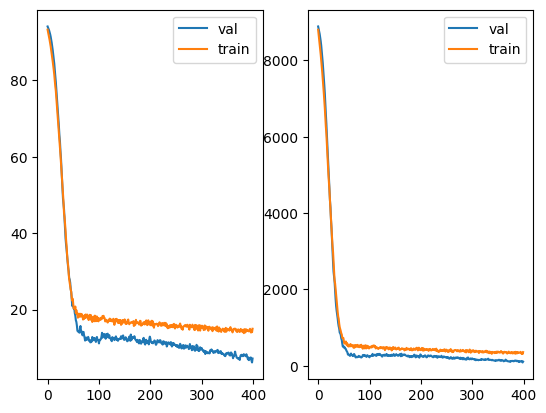

In [14]:
estimator_history.keys()


fig, axes = plt.subplots(1, 2)

axes[0].plot(estimator_history["validation_abs"], label="val")
axes[0].plot(estimator_history["train_abs"], label="train")

axes[0].legend()



axes[1].plot(estimator_history["validation_mse"], label="val")
axes[1].plot(estimator_history["train_mse"], label="train")

axes[1].legend()

In [15]:
lenet5_model.get_prune_channel_possible_hyperparameters()

{'sparsity.conv2d_0': range(0, 6),
 'sparsity.conv2d_1': range(0, 16),
 'sparsity.linear_0': range(0, 84),
 'metrics': ['l2']}

In [16]:
import itertools
import torch

def brute_force_search_prune_config(
    model,
    estimator,
    input_shape,
    condition=lambda m, s, r, c: True,                 # list of filters
    objective=lambda m, s, r, c: m,                  # objective function, default objective = maximize metric
    maximize=True,                   # maximize or minimize?
    verbose=True
):
    """
    Generic brute-force search engine.

    Args:
        model: model with pruning methods
        estimator: metric estimator
        input_shape: input dimensions
        conditions: list of callables (metric,size,ram,comb)->bool
        objective: callable (metric,size,ram,comb)->float
        maximize: True=maximize objective, False=minimize
        verbose: print progress

    Returns:
        best_comb, best_obj_value, history
    """

    # initialize best value based on maximize/minimize
    if maximize:
        best_value = float("-inf")
    else:
        best_value = float("inf")

    best_comb = None

    # compute baseline size
    original_size = model.get_size_in_bytes()
    original_metric = estimator.predict(torch.Tensor([0, 0, 0]).unsqueeze(0))

    # helper to list all prune combinations
    def get_all_combinations(flat_dict):
        keys = list(flat_dict.keys())
        vals = list(flat_dict.values())
        for combo in itertools.product(*vals):
            yield {k: v for k, v in zip(keys, combo)}

    # iterate search space
    for comb in get_all_combinations(model.get_prune_channel_possible_hyperparameters()):

        # predict metric
        metric = estimator.predict(
            torch.Tensor(list(comb.values())).unsqueeze(0)
        ) / original_metric

        # create compressed model
        compressed = model.init_compress({
            "prune_channel": {"sparsity": comb, "metric": "l2"}
        }, input_shape)

        size = compressed.get_size_in_bytes() / original_size
        ram = sum(compressed.get_max_workspace_arena(input_shape)) / 2

        # -------- HARD FILTERS --------
        if not condition(metric, size, ram, comb):
            continue

        # -------- OBJECTIVE VALUE --------
        obj = objective(metric, size, ram, comb)

        if (maximize and obj > best_value) or (not maximize and obj < best_value):
            best_value = obj
            best_comb = comb
            best_result_info = [metric, size, ram]
            if verbose:
                print(f"✔ New best: obj={obj:.4f}, metric={metric:.4f}, size={size:.4f}, ram={ram}, comb={comb}")

    return best_comb, best_result_info


In [17]:
import random
import copy
import torch
import numpy as np

def evolutionary_search_prune_config(
    model,
    estimator,
    input_shape,
    condition=lambda m, s, r, c: True,     # Constraint filter
    objective=lambda m, s, r, c: m,       # Objective function
    maximize=True,
    verbose=True,
    # --- EA Hyperparameters ---
    population_size=50,
    generations=50,
    mutation_rate=0.2,
    crossover_rate=0.7,
    elite_size=2
):
    """
    Genetic Algorithm search engine for optimal pruning configuration.
    """

    # 1. Analyze Search Space
    # hyperparams is a dict: {'layer_name': [val1, val2, ...]}
    search_space = model.get_prune_channel_possible_hyperparameters()
    
    param_names = list(search_space.keys())
    param_values = list(search_space.values()) # List of lists of valid values
    
    # Pre-compute baseline stats
    original_size = model.get_size_in_bytes()
    # Dummy prediction to normalize or check baseline metric if needed
    original_metric = estimator.predict(torch.Tensor([0, 0, 0]).unsqueeze(0))
    # original_metric = estimator.predict(torch.zeros(1, len(param_names)).to(estimator.device))

    # --- Helper: Generate Random Individual ---
    def create_individual():
        return {name: random.choice(values) for name, values in zip(param_names, param_values)}

    # --- Helper: Evaluate Fitness ---
    def evaluate(individual):
        # Prepare input for estimator (MLP)
        # Convert config dict values to tensor row
        print(individual.values())
        features = torch.tensor([list(individual.values())], dtype=torch.float32)
        
        # 1. Predict Accuracy (Metric)
        # Assuming estimator is on same device, or move features.to(device)
        # print(features)
        metric = estimator.predict(features) / original_metric
        # 2. Compute Hardware Stats
        # We assume init_compress is fast (just setting masks, no training)
        compressed = model.init_compress({
            "prune_channel": {"sparsity": individual, "metric": "l2"}
        }, input_shape)
        
        size = compressed.get_size_in_bytes() / original_size
        ram = sum(compressed.get_max_workspace_arena(input_shape)) / 2

        # 3. Check Constraints (Hard Filter)
        if not condition(metric, size, ram, individual):
            # Penalty fitness for invalid solutions
            return (float("-inf") if maximize else float("inf")), [metric, size, ram]

        # print(metric, individual)
        # 4. Calculate Objective
        score = objective(metric, size, ram, individual)
        return score, [metric, size, ram]

    # --- Helper: Crossover (Uniform) ---
    def crossover(parent1, parent2):
        child = {}
        for key in param_names:
            if random.random() < 0.5:
                child[key] = parent1[key]
            else:
                child[key] = parent2[key]
        return child

    # --- Helper: Mutation ---
    def mutate(individual):
        mutated = individual.copy()
        # Pick a random gene (layer) to mutate
        gene_to_mutate = random.choice(param_names)
        # Pick a new valid value from the search space for that layer
        valid_options = search_space[gene_to_mutate]
        mutated[gene_to_mutate] = random.choice(valid_options)
        return mutated

    # =========================================
    # Evolutionary Loop
    # =========================================
    
    # 1. Initialize Population
    population = [create_individual() for _ in range(population_size)]
    
    best_overall_comb = None
    best_overall_score = float("-inf") if maximize else float("inf")
    best_overall_info = None

    for gen in range(generations):
        # 2. Evaluate Population
        scores = []
        infos = []
        # print(population)
        for ind in population:
            score, info = evaluate(ind)
            scores.append(score)
            infos.append(info)
            
            # Update Global Best
            is_better = (score > best_overall_score) if maximize else (score < best_overall_score)
            if is_better and score != float("-inf") and score != float("inf"):
                best_overall_score = score
                best_overall_comb = ind
                best_overall_info = info
                if verbose:
                    print(f"Gen {gen}: ✔ New best! Obj={score:.4f} Metric={info[0]:.4f} Size={info[1]:.4f}")

        # 3. Selection (Tournament)
        selected = []
        while len(selected) < population_size:
            # Pick k random candidates
            candidates_indices = random.sample(range(population_size), k=3)
            # Find the best among them
            best_idx = candidates_indices[0]
            for idx in candidates_indices[1:]:
                if maximize:
                    if scores[idx] > scores[best_idx]: best_idx = idx
                else:
                    if scores[idx] < scores[best_idx]: best_idx = idx
            selected.append(population[best_idx])

        # 4. Elitism (Keep best individuals)
        # Sort population by score
        sorted_pop_indices = np.argsort(scores)
        if maximize:
            sorted_pop_indices = sorted_pop_indices[::-1] # Descending
            
        next_generation = []
        for i in range(elite_size):
            idx = sorted_pop_indices[i]
            # Only keep if valid
            if scores[idx] != float("inf") and scores[idx] != float("-inf"):
                next_generation.append(population[idx])

        # 5. Crossover & Mutation
        while len(next_generation) < population_size:
            parent1 = random.choice(selected)
            parent2 = random.choice(selected)
            
            if random.random() < crossover_rate:
                child = crossover(parent1, parent2)
            else:
                child = parent1 # No crossover, just copy
            
            if random.random() < mutation_rate:
                child = mutate(child)
                
            next_generation.append(child)
            
        population = next_generation
        
        if verbose:
            valid_scores = [s for s in scores if s != float("inf") and s != float("-inf")]
            avg_score = sum(valid_scores) / len(valid_scores) if valid_scores else 0
            print(f"Gen {gen}/{generations} Complete. Avg Score: {avg_score:.4f}")

    return best_overall_comb, best_overall_info

In [18]:
lenet5_model.get_prune_channel_possible_hyperparameters(), lenet5_model.get_quantize_possible_hyperparameters()

({'sparsity.conv2d_0': range(0, 6),
  'sparsity.conv2d_1': range(0, 16),
  'sparsity.linear_0': range(0, 84),
  'metrics': ['l2']},
 {'scheme': [<QuantizationScheme.NONE: 1>,
   <QuantizationScheme.DYNAMIC: 2>,
   <QuantizationScheme.STATIC: 3>],
  'granularity': [None,
   <QuantizationGranularity.PER_TENSOR: 1>,
   <QuantizationGranularity.PER_CHANNEL: 2>],
  'bitwidth': [None, 2, 4, 8]})

In [19]:
lenet5_model.get_commpression_possible_hyperparameters()

{'prune.sparsity.conv2d_0': range(0, 6),
 'prune.sparsity.conv2d_1': range(0, 16),
 'prune.sparsity.linear_0': range(0, 84),
 'prune.metrics': ['l2'],
 'quantize.scheme': [<QuantizationScheme.NONE: 1>,
  <QuantizationScheme.DYNAMIC: 2>,
  <QuantizationScheme.STATIC: 3>],
 'quantize.granularity': [None,
  <QuantizationGranularity.PER_TENSOR: 1>,
  <QuantizationGranularity.PER_CHANNEL: 2>],
 'quantize.bitwidth': [None, 2, 4, 8]}

In [21]:
config_encoder = ConfigEncoder(search_space=lenet5_model.get_commpression_possible_hyperparameters())

In [26]:
config_encoder.encode(params), params

(tensor([0.4000, 0.1333, 0.8072, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000]),
 {'prune.sparsity.conv2d_0': 2,
  'prune.sparsity.conv2d_1': 2,
  'prune.sparsity.linear_0': 67,
  'prune.metrics': 'l2',
  'quantize.scheme': <QuantizationScheme.NONE: 1>,
  'quantize.granularity': None,
  'quantize.bitwidth': 4})

In [24]:
params = dict()
for name, hp in lenet5_model.get_commpression_possible_hyperparameters().items():
    params[name] = random.choice(hp)

lenet5_model.decode_compression_dict_hyperparameter(params)

{'prune': {'sparsity': {'conv2d_0': 2, 'conv2d_1': 2, 'linear_0': 67},
  'metrics': 'l2'},
 'quantize': {'scheme': <QuantizationScheme.NONE: 1>,
  'granularity': None,
  'bitwidth': 4}}

In [ ]:
lenet5_model.decode_compression_dict_hyperparameter(params)

In [24]:
evolutionary_search_prune_config(
    lenet5_model,
    estimator,
    INPUT_SHAPE,
    condition=lambda metric, size, ram_size, comb: metric > .99,                 # list of filters
    objective= lambda metric, size, ram_size, comb: size,                 # objective function
    maximize=False,                   # maximize or minimize?
    verbose=True
)

dict_values([2, 9, 61, 'l2'])


TypeError: must be real number, not str

## Getting the DMC model

### Searching for the smallest config with metric at least 99% of original

In [ ]:
best_comb, best_result_info = brute_force_search_prune_config(
    lenet5_model,
    estimator,
    INPUT_SHAPE,
    condition=lambda metric, size, ram_size, comb: metric > .99,                 # list of filters
    objective= lambda metric, size, ram_size, comb: size,                 # objective function
    maximize=False,                   # maximize or minimize?
    verbose=True
)
best_comb

✔ New best: obj=1.0000, metric=1.0000, size=1.0000, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 0}
✔ New best: obj=0.9889, metric=1.0014, size=0.9889, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 1}
✔ New best: obj=0.9779, metric=1.0028, size=0.9779, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 2}
✔ New best: obj=0.9668, metric=1.0041, size=0.9668, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 3}
✔ New best: obj=0.9557, metric=1.0054, size=0.9557, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 4}
✔ New best: obj=0.9447, metric=1.0067, size=0.9447, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 5}
✔ New best: obj=0.9336, metric=1.0080, size=0.9336, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 6}
✔ New best: obj=0.9226, metric=1.0092, size=0.9226, ram=4704.0, comb={'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 7}
✔ New best: obj=0.9115, metric=1.0100, size=0.9115, ram=4704.0, comb={'conv2d_0'

{'conv2d_0': 2, 'conv2d_1': 2, 'linear_0': 81}

In [ ]:
best_comb, best_result_info = evolutionary_search_prune_config(
    lenet5_model,
    estimator,
    INPUT_SHAPE,
    condition=lambda metric, size, ram_size, comb: metric > .99,                 # list of filters
    objective= lambda metric, size, ram_size, comb: size,                 # objective function
    maximize=False,                   # maximize or minimize?
    verbose=True
)
best_comb

Gen 0: ✔ New best! Obj=0.0782 Metric=88.5218 Size=0.0782
Gen 0: ✔ New best! Obj=0.0633 Metric=64.9788 Size=0.0633
Gen 0: ✔ New best! Obj=0.0411 Metric=69.9123 Size=0.0411
Gen 0: ✔ New best! Obj=0.0107 Metric=46.4066 Size=0.0107
Gen 0/20 Complete. Avg Score: 0.3128


RuntimeError: running_mean should contain 12 elements not 3

In [ ]:
# Already precomputed
best_comb = {
    'conv2d_0':0,
    'conv2d_1': 9,
    'linear_0': 64,
    'batchnorm2d_0': 0,
    'relu_0': 0,
    'maxpool2d_0': 0,
    'batchnorm2d_1': 0,
    'relu_1': 0,
    'maxpool2d_1': 0,
    'flatten_0': 0,
    'relu_2': 0,
    'linear_1': 0
}


In [ ]:
early_stopper = EarlyStopper(
    monitor_metric="validation_loss",
    delta=1e-7,
    mode="min",
    patience=5,
    restore_best_state_dict=True,
)

def train_pruned(baseline_model, prune_sparsity_comb, train_loader, test_loader):
    print("\n--- STAGE 2: Applying Pruning & Retraining ---")
    
    # Pruning parameters from paper (Table 1 / Sec 4.1.1)
    pruning_config = {
        "prune_channel": {
            "sparsity": prune_sparsity_comb,
            "metric": "l2"
        }
    }
    
    print(f"Applying pruning config: {pruning_config['prune_channel']['sparsity']}")
    
    # Re-initialize model architecture with pruning
    pruned_model = copy.deepcopy(baseline_model)
    pruned_model = pruned_model.init_compress(pruning_config, INPUT_SHAPE).to(DEVICE)
    
    # Retrain (fine-tune) the pruned model
    print("Retraining pruned model (20 epochs)...")
    criterion_fun = nn.CrossEntropyLoss()
    optimizer_fun = optim.SGD(pruned_model.parameters(), lr=1.e-3, weight_decay=5e-4, momentum=.9)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fun, mode="min", patience=1)

    pruned_model.fit(
        train_loader, 20, 
        criterion_fun, optimizer_fun, lr_scheduler,
        validation_dataloader=test_loader, 
        metrics={"acc": accuracy_fun},
        device=DEVICE, 
        callbacks=[early_stopper]
    )
    return pruned_model

def train_quantized_pruned(pruned_model, prune_sparsity_comb, train_loader, test_loader):
    print("\n--- STAGE 3: Applying Quantization (QAT) & Retraining ---")
    
    # Configs from paper (Table 2, 4-bit static) and notebook
    pruning_config = {
        "prune_channel": {
            "sparsity": prune_sparsity_comb,
            "metric": "l2"
        }
    }
    quantization_config = {
        "quantize": {
            "scheme": QuantizationScheme.STATIC,
            "granularity": QuantizationGranularity.PER_TENSOR,
            "bitwidth": 4
        }
    }
    full_compression_config = {**pruning_config, **quantization_config}

    print(f"Applying quantization config: 4-bit, STATIC, PER_TENSOR")
    
    # Get one batch of calibration data
    loader_iter = iter(test_loader)
    calibration_data = torch.concat([next(loader_iter)[0] for _ in range(5)], dim=0).to(DEVICE)
    print(calibration_data.size())
    
    # Re-initialize model with *both* configs
    quantized_model = copy.deepcopy(pruned_model)
    quantized_model = quantized_model.to(DEVICE) # Fuse before QAT

    # Initialize compression for QAT
    quantized_model = quantized_model.init_compress(
        full_compression_config, 
        INPUT_SHAPE, 
        calibration_data
    ).to(DEVICE)

    # Perform Quantization-Aware Training (15 epochs from paper Table 2)
    print("Performing QAT (15 epochs)...")
    criterion_fun = nn.CrossEntropyLoss()
    optimizer_fun = optim.SGD(quantized_model.parameters(), lr=1.e-4, weight_decay=5e-4, momentum=.9)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fun, mode="min", patience=1)

    quantized_model.fit(
        train_loader, 20, 
        criterion_fun, optimizer_fun, lr_scheduler,
        validation_dataloader=test_loader, 
        metrics={"acc": accuracy_fun},
        device=DEVICE,
        callbacks=[early_stopper]
    )
    return quantized_model

# # --- Main Execution ---
# if __name__ == "__main__":
    
#     # Get Data
    
#     # --- STAGE 1: BASELINE ---
#     baseline_model = copy.deepcopy(lenet5_model)
    
#     print("Evaluating baseline model...")
#     baseline_eval = baseline_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)
#     original_size = baseline_model.get_size_in_bits() // 8
#     print(f"==> STAGE 1 (Baseline) COMPLETE ==")
#     print(f"    Accuracy: {baseline_eval['acc']:.2f}%")
#     print(f"    Size:     {original_size} bytes")

#     # --- STAGE 2: PRUNED ---
#     # Use a copy to keep the original baseline model clean
#     pruned_model = train_pruned(baseline_model, best_comb, mnist_train_loader, mnist_test_loader)
    
#     print("Evaluating pruned model...")
#     pruned_eval = pruned_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)
#     pruned_size = pruned_model.get_size_in_bits() // 8
#     print(f"\n==> STAGE 2 (Pruned) COMPLETE ==")
#     print(f"    Accuracy: {pruned_eval['acc']:.2f}%")
#     print(f"    Size:     {pruned_size} bytes ({pruned_size/original_size*100:.2f}% of original)")

#     print(f"\n===> Layerwise Prunning Results:")
#     for i, (name, module) in enumerate(pruned_model.names_layers()):
#         if ("conv2d" in name) or ("linear" in name):
#             print(f"    Layer name : {name}, Original size {baseline_model[i].get_size_in_bits()/(8*1024)} Reduced size {module.get_size_in_bits()/(8*1024)}:  Size Ratio: {(1 - module.get_size_in_bits()/baseline_model[i].get_size_in_bits())*100:.2f}%") # type: ignore

#     # --- STAGE 3: QUANTIZED-PRUNED ---
#     quantized_model = train_quantized_pruned(pruned_model, best_comb, mnist_train_loader, mnist_test_loader)
    
#     print("Evaluating final quantized-pruned model...")
#     quantized_eval = quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)
#     quantized_size = quantized_model.get_size_in_bits() // 8
#     print(f"\n==> STAGE 3 (Quantized-Pruned) COMPLETE ==")f
#     print(f"    Accuracy: {quantized_eval['acc']:.2f}%")
#     print(f"    Size:     {quantized_size} bytes ({quantized_size/original_size*100:.2f}% of original)")

#     print(f"\n===> Layerwise Pruned and Quantized Results:")
#     for i, (name, module) in enumerate(quantized_model.names_layers()):
#         if ("conv2d" in name) or ("linear" in name):
#             print(f"    Layer name : {name}, Original size {baseline_model[i].get_size_in_bits()/(8*1024):8.4f} Reduced size {module.get_size_in_bits()/(8*1024):8.4f}:  Size Ratio: {(1 - module.get_size_in_bits()/baseline_model[i].get_size_in_bits())*100:.2f}%") # type: ignore

#     print("\n--- REPRODUCTION FINISHED ---")
#     print("\nFinal Results Summary:")
#     print(f"Baseline:   {baseline_eval['acc']:.2f}% Acc, {original_size} bytes")
#     print(f"Pruned:     {pruned_eval['acc']:.2f}% Acc, {pruned_size} bytes, {pruned_size/original_size*100:.2f}% of original")
#     print(f"Quantized:  {quantized_eval['acc']:.2f}% Acc, {quantized_size} bytes, {quantized_size/original_size*100:.2f}% of original")

## To Inference Stats 


In [ ]:
base_total_b, prune_total_b, quant_total_b = 0, 0, 0
# input_shape = [
#     (1, 1, 28, 28),
#     (1, 6)
# ]
for baseline_layer, prune_layer, quant_layer in zip(baseline_model.fuse().to(DEVICE), pruned_model.fuse().to(DEVICE), quantized_model.fuse().to(DEVICE)):
    
    if isinstance(baseline_layer, (MaxPool2d, Flatten)):
        continue
    # total += layer.get_size_in_bits()

    base_size_b = baseline_layer.get_size_in_bits()
    prune_size_b = prune_layer.get_size_in_bits()
    quant_size_b = quant_layer.get_size_in_bits()
    
    print(baseline_layer)
    print(
        f"baseline_layer size in KB {base_size_b/(1024*8):10.4f}\n"
        f"prune_layer size reduction ratio {(base_size_b -prune_size_b)/base_size_b:10.4f}\n"
        f"quant_layer size reduction ratio {(base_size_b -quant_size_b)/base_size_b:10.4f}\n"
    )
    base_total_b += base_size_b
    prune_total_b += prune_size_b
    quant_total_b += quant_size_b

print(baseline_model)
print(
    f"baseline_model size in KB {base_total_b/(1024*8):10.4f}\n"
    f"prune_model size reduction ratio {(base_total_b -prune_total_b)/base_total_b:10.4f}, in KB {prune_total_b/(1024*8):10.4f}\n"
    f"quant_model size reduction ratio {(base_total_b -quant_total_b)/base_total_b:10.4f}, in KB {quant_total_b/(1024*8):10.4f}\n"
)

Conv2dReLU(
  1, 6, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
)
baseline_layer size in KB     0.6094
prune_layer size reduction ratio     0.0000
quant_layer size reduction ratio     0.8253

Conv2dReLU(
  6, 16, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
)
baseline_layer size in KB     9.4375
prune_layer size reduction ratio     0.5625
quant_layer size reduction ratio     0.9417

LinearReLU(
  in_features=400, out_features=84, bias=True
  (relu): ReLU()
)
baseline_layer size in KB   131.5781
prune_layer size reduction ratio     0.8955
quant_layer size reduction ratio     0.9863

Linear(in_features=84, out_features=10, bias=True)
baseline_layer size in KB     3.3203
prune_layer size reduction ratio     0.7529
quant_layer size reduction ratio     0.9559

Sequential(
  (conv2d_0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_0): ReLU()
  (maxpool2d_0): MaxPool2d(ker

In [ ]:
test_input, test_ = mnist_test_dataset[0]
test_input = test_input.unsqueeze(0).to(DEVICE)

In [ ]:
# fused_model = lenet5_model.fuse().to(DEVICE).eval()
# fused_model.convert_to_c(INPUT_SHAPE, "lenet_model", arduino_src_dir, arduino_include_dir, test_input)

# fused_model(test_input)

In [ ]:
# fused_model = pruned_model.fuse().to(DEVICE).eval()
# fused_model.convert_to_c(INPUT_SHAPE, "lenet_model", arduino_src_dir, arduino_include_dir, test_input)

# fused_model(test_input)

In [ ]:
# fused_model = quantized_model.fuse().to(DEVICE).eval()
# fused_model.convert_to_c(INPUT_SHAPE, "lenet_model", arduino_src_dir, arduino_include_dir, test_input)

# fused_model.output_quantize.apply(fused_model(test_input))

## Getting the best model for Atlmega360
We set the max activation to be the ram size of 2KB and the size at most 20%. 

In [ ]:
brute_force_search_prune_config(
    lenet5_model,
    estimator,
    INPUT_SHAPE,
    condition=lambda metric, size, ram_size, comb: ram_size < 1.5 * 1024 and size < 0.2,                 # list of filters
    objective= lambda metric, size, ram_size, comb: metric,                 # objective function
    maximize=True,                   # maximize or minimize?
    verbose=True
)

NameError: name 'brute_force_search_prune_config' is not defined

In [ ]:
ardunio_config = {'conv2d_0':4,
    'conv2d_1': 7,
    'linear_0': 55,
    'batchnorm2d_0': 0,
    'relu_0': 0,
    'maxpool2d_0': 0,
    'batchnorm2d_1': 0,
    'relu_1': 0,
    'maxpool2d_1': 0,
    'flatten_0': 0,
    'relu_2': 0,
    'linear_1': 0
}

In [ ]:
# ardunio_config = {'conv2d_0':5,
#     'conv2d_1': 7,
#     'linear_0': 55,
#     'batchnorm2d_0': 0,
#     'relu_0': 0,
#     'maxpool2d_0': 0,
#     'batchnorm2d_1': 0,
#     'relu_1': 0,
#     'maxpool2d_1': 0,
#     'flatten_0': 0,
#     'relu_2': 0,
#     'linear_1': 0
# }

In [ ]:
pruning_config = {
    "prune_channel": {
        "sparsity": ardunio_config,
        "metric": "l2"
    }
}

quantization_config = {
    "quantize": {
        "scheme": QuantizationScheme.STATIC,
        "granularity": QuantizationGranularity.PER_TENSOR,
        "bitwidth": 4
    }
}
full_compression_config = {**pruning_config, **quantization_config}


uno_pruned_model = train_pruned(lenet5_model, ardunio_config, mnist_train_loader, mnist_test_loader)
uno_quantized_model = train_quantized_pruned(uno_pruned_model, ardunio_config, mnist_train_loader, mnist_test_loader)

# # Get one batch of calibration data
# loader_iter = iter(mnist_test_loader)
# calibration_data = torch.concat([next(loader_iter)[0] for _ in range(5)], dim=0).to(DEVICE)

# # Initialize compression for QAT
# uno_model = lenet5_model.init_compress(
#     full_compression_config, 
#     INPUT_SHAPE, 
#     calibration_data
# ).to(DEVICE)

fused_model = uno_quantized_model.fuse().to(DEVICE).eval()
fused_model.convert_to_c(INPUT_SHAPE, "uno_model", arduino_uno_src_dir, arduino_uno_include_dir, test_input)
fused_model.convert_to_c(INPUT_SHAPE, "uno_model", hp_src_dir, hp_include_dir, test_input)
fused_model.get_max_workspace_arena(INPUT_SHAPE)
# fused_model.output_quantize.apply(fused_model(test_input))
# uno_quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, DEVICE)


--- STAGE 2: Applying Pruning & Retraining ---
Applying pruning config: {'conv2d_0': 4, 'conv2d_1': 7, 'linear_0': 55, 'batchnorm2d_0': 0, 'relu_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_1': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_2': 0, 'linear_1': 0}
Retraining pruned model (20 epochs)...


DMC Training (Epochs 1-20):   0%|          | 0/20 [00:00<?, ?it/s]

DMC Training (Epochs 1-20):   0%|          | 0/20 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
fused_model.get_max_workspace_arena(INPUT_SHAPE)

(392, 576)

In [ ]:
fused_model.convert_to_c(INPUT_SHAPE, "uno_model", arduino_uno_src_dir, arduino_uno_include_dir, test_input)


In [ ]:
uno_quantized_model.to(DEVICE).evaluate(mnist_test_loader, {"acc": accuracy_fun}, DEVICE)

100%|██████████| 313/313 [00:04<00:00, 66.61it/s]


{'acc': 94.91}

In [ ]:
uno_quantized_model._modules.pop("batchnorm2d_0", "batchnorm2d_1")

BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
uno_quantized_model

Sequential(
  (conv2d_0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu_0): ReLU()
  (maxpool2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten_0): Flatten(start_dim=1, end_dim=-1)
  (linear_0): Linear(in_features=400, out_features=84, bias=True)
  (relu_2): ReLU()
  (linear_1): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
uno_quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, DEVICE)

100%|██████████| 313/313 [00:04<00:00, 66.91it/s]


{'acc': 11.21}

In [ ]:
train_quantized_pruned(uno_quantized_model.fuse().to(DEVICE),  {'conv2d_0':4,
    'conv2d_1': 7,
    'linear_0': 55,
    'maxpool2d_0': 0,
    'maxpool2d_1': 0,
    'flatten_0': 0,
    'linear_1': 0
}, mnist_train_loader, mnist_test_loader)


--- STAGE 3: Applying Quantization (QAT) & Retraining ---
Applying quantization config: 4-bit, STATIC, PER_TENSOR
torch.Size([160, 1, 28, 28])
Performing QAT (15 epochs)...


  5%|▌         | 1/20 [01:15<23:59, 75.75s/it]

epoch    0 | train loss 0.0910 | validation loss 0.0722 | train acc 10.8450 | validation acc 11.3500


  5%|▌         | 1/20 [01:27<27:47, 87.78s/it]


KeyboardInterrupt: 

In [ ]:
total = 0
for layer in uno_quantized_model:
    total += layer.get_size_in_bytes()
    print(layer, layer.get_size_in_bytes(), total)

total = 0
for layer in uno_quantized_model.fuse().to(DEVICE):
    total += layer.get_size_in_bytes()
    print(layer, layer.get_size_in_bytes(), total)



Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)) 43 43
ReLU() 1 44
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 44
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) 271 315
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 72 387
ReLU() 1 388
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 388
Flatten(start_dim=1, end_dim=-1) 0 388
Linear(in_features=400, out_features=84, bias=True) 3389 3777
ReLU() 1 3778
Linear(in_features=84, out_features=10, bias=True) 195 3973
Conv2dReLU(
  1, 6, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
) 43 43
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 43
Conv2dReLU(
  6, 16, kernel_size=(5, 5), stride=(1, 1)
  (relu): ReLU()
) 271 314
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 0 314
Flatten(start_dim=1, end_dim=-1) 0 314
LinearReLU(
  in_features=400, out_features=84, bias=True
  (relu): ReLU()
) 338

In [ ]:
best_metric = float("-inf")
best_comb = None
best_size = float("inf")
original_size = lenet5_model.get_size_in_bytes()

def get_all_combinations(flat_dict: dict[str, list]):
    keys = list(flat_dict.keys())
    values = list(flat_dict.values())
    product = itertools.product(*values)

    for comb in product:
        yield {key: value for key, value in zip(keys, comb)}

        
result = []

original_metric = estimator.predict(torch.Tensor([0, 0, 0]).unsqueeze(0))
print(original_metric)

for prune_comb in get_all_combinations(lenet5_model.get_prune_channel_possible_hypermeters()):
    metric = estimator.predict(torch.Tensor(list(prune_comb.values())).unsqueeze(0))

    compression_config = {
        "prune_channel" :{
            "sparsity" : prune_comb,
            "metric" : "l2"
        },
    }

    # if metric > 0.985 * original_metric:
    compressed_model = lenet5_model.init_compress(compression_config, INPUT_SHAPE)
    size = compressed_model.get_size_in_bytes() / original_size
    ram_size = sum(compressed_model.get_max_workspace_arena(INPUT_SHAPE)) / 2

    if ram_size < 2 * 1024 and size < 0.2:
        if metric > best_metric:
            best_comb = prune_comb
            best_metric = metric
            print(metric, size, best_comb, ram_size)
    # if lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size < 5:

    #     result.append((prune_comb, metric))

        if metric > best_metric:
            best_metric = metric
            best_comb = prune_comb

            print(best_comb, best_metric)


NameError: name 'estimator' is not defined

In [ ]:
input_shape = INPUT_SHAPE
for layer in quantized_model.layers():
    max_shape, input_shape = layer.get_output_tensor_shape(input_shape)
    print(layer, max_shape, max_shape.numel())
quantized_model.get_max_workspace_arena(INPUT_SHAPE)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)) torch.Size([1, 32, 32]) 1024
BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) torch.Size([4, 28, 28]) 3136
ReLU() torch.Size([4, 28, 28]) 3136
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([4, 14, 14]) 784
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) torch.Size([4, 14, 14]) 784
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) torch.Size([6, 10, 10]) 600
ReLU() torch.Size([6, 10, 10]) 600
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([6, 5, 5]) 150
Flatten(start_dim=1, end_dim=-1) torch.Size([150]) 150
Linear(in_features=400, out_features=84, bias=True) torch.Size([25]) 25
ReLU() torch.Size([25]) 25
Linear(in_features=84, out_features=10, bias=True) torch.Size([10]) 10


(3136, 3136)

In [ ]:
quantized_model.convert_to_c(INPUT_SHAPE, "P_Q_LENET5", src_dir="Arduino Nano 33 BLE/src", include_dir="Arduino Nano 33 BLE/src")


In [ ]:

    criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

param += lenet5_model.get_nas_prune_channel(input_shape, mnist_test_loader, accuracy_fun, DEVICE, num_data=400, 
                                            train=True,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, )
estimator = Estimator(param, device=DEVICE, hidden_dim=[128, 128, 128], dropout=.75)
estimator_history = estimator.fit(epochs=500)


IndentationError: unexpected indent (567008283.py, line 1)

In [ ]:
len(torch.load("get_nas_param_with_training"))

500

In [ ]:
torch.save(param, "get_nas_param_with_training")

In [ ]:
estimator_history

{'validation_loss': [tensor(355.1248, device='cuda:0'),
  tensor(340.5578, device='cuda:0'),
  tensor(290.3071, device='cuda:0'),
  tensor(165.1139, device='cuda:0'),
  tensor(28.1457, device='cuda:0'),
  tensor(16.0072, device='cuda:0'),
  tensor(26.4479, device='cuda:0'),
  tensor(22.1945, device='cuda:0'),
  tensor(19.8258, device='cuda:0'),
  tensor(24.0395, device='cuda:0'),
  tensor(19.7391, device='cuda:0'),
  tensor(18.6076, device='cuda:0'),
  tensor(20.1053, device='cuda:0'),
  tensor(19.2924, device='cuda:0'),
  tensor(22.1729, device='cuda:0'),
  tensor(16.7815, device='cuda:0'),
  tensor(15.4645, device='cuda:0'),
  tensor(16.6608, device='cuda:0'),
  tensor(17.6951, device='cuda:0'),
  tensor(18.9514, device='cuda:0'),
  tensor(16.7353, device='cuda:0'),
  tensor(14.6157, device='cuda:0'),
  tensor(12.9355, device='cuda:0'),
  tensor(14.9380, device='cuda:0'),
  tensor(15.6660, device='cuda:0'),
  tensor(18.0503, device='cuda:0'),
  tensor(14.1748, device='cuda:0'),
  ten

In [ ]:
len(param)

500

In [ ]:

best_metric = float("-inf")
best_comb = None
best_size = float("inf")
original_size = lenet5_model.get_size_in_bytes()


def get_all_combinations(flat_dict: dict[str, list]):
    keys = list(flat_dict.keys())
    values = list(flat_dict.values())
    product = itertools.product(*values)

    for comb in product:
        yield {key: value for key, value in zip(keys, comb)}

        
result = []

original_metric = estimator.predict(torch.Tensor([0, 0, 0]))
print(original_metric)

for prune_comb in get_all_combinations(lenet5_model.get_prune_channel_possible_hypermeters()):
    metric = estimator.predict(torch.Tensor(list(prune_comb.values())))

    compression_config = {
        "prune_channel" :{
            "sparsity" : prune_comb,
            "metric" : "l2"
        },
    }

    if metric > 0.965 * original_metric:
        
        size = lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size
        if size < best_size:
            best_comb = prune_comb
            best_size = size
            print(metric, size, best_comb)
    # if lenet5_model.init_compress(compression_config, input_shape).get_size_in_bytes() / original_size < 5:

    #     result.append((prune_comb, metric))

    #     if metric > best_metric:
    #         best_metric = metric
    #         best_comb = prune_comb

    #         print(best_comb, best_metric)


95.9630126953125
95.9630126953125 1.0 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 0, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
95.97836303710938 0.9889368591473287 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 1, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
95.99087524414062 0.9778737182946573 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 2, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
96.0018081665039 0.966810577441986 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 3, 'batchnorm2d_0': 0, 'relu6_0': 0, 'maxpool2d_0': 0, 'batchnorm2d_1': 0, 'relu_0': 0, 'maxpool2d_1': 0, 'flatten_0': 0, 'relu_1': 0, 'linear_1': 0}
96.01089477539062 0.9557474365893146 {'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 4

In [ ]:
best_comb

{'conv2d_0': 0,
 'conv2d_1': 15,
 'linear_0': 0,
 'batchnorm2d_0': 0,
 'relu6_0': 0,
 'maxpool2d_0': 0,
 'batchnorm2d_1': 0,
 'relu_0': 0,
 'maxpool2d_1': 0,
 'flatten_0': 0,
 'relu_1': 0,
 'linear_1': 0}

In [ ]:
best_pruned_model = lenet5_model.init_compress({
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0,
            "conv2d_1": 9,
            "linear_0": 50
        },
        "metric": "l2"
    }
}, input_shape).to(DEVICE)


criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(best_pruned_model.parameters(), lr=1.e-3, weight_decay=5e-4, momentum=.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=1)

best_pruned_model.fit(
    mnist_train_loader, 20, 
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=mnist_test_loader, 
    metrics={"acc" : accuracy_fun},
    # callbacks=[early_stopper],
    device=DEVICE
)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:12<03:48, 12.03s/it]

epoch    0 | train loss 0.0050 | validation loss 0.0032 | train acc 95.0417 | validation acc 96.6500


 10%|█         | 2/20 [00:25<03:47, 12.62s/it]

epoch    1 | train loss 0.0029 | validation loss 0.0024 | train acc 97.2533 | validation acc 97.5100


 15%|█▌        | 3/20 [00:37<03:35, 12.66s/it]

epoch    2 | train loss 0.0025 | validation loss 0.0020 | train acc 97.5417 | validation acc 97.8700


 20%|██        | 4/20 [00:50<03:21, 12.62s/it]

epoch    3 | train loss 0.0022 | validation loss 0.0019 | train acc 97.7300 | validation acc 98.0700


 25%|██▌       | 5/20 [01:03<03:11, 12.76s/it]

epoch    4 | train loss 0.0020 | validation loss 0.0017 | train acc 98.0117 | validation acc 98.2100


 30%|███       | 6/20 [01:16<02:59, 12.85s/it]

epoch    5 | train loss 0.0020 | validation loss 0.0018 | train acc 98.0317 | validation acc 98.4000


 35%|███▌      | 7/20 [01:29<02:48, 12.98s/it]

epoch    6 | train loss 0.0019 | validation loss 0.0017 | train acc 98.0967 | validation acc 98.3100


 40%|████      | 8/20 [01:44<02:44, 13.69s/it]

epoch    7 | train loss 0.0018 | validation loss 0.0017 | train acc 98.2083 | validation acc 98.1800


 45%|████▌     | 9/20 [02:02<02:45, 15.07s/it]

epoch    8 | train loss 0.0017 | validation loss 0.0017 | train acc 98.2467 | validation acc 98.3100


 50%|█████     | 10/20 [02:15<02:23, 14.31s/it]

epoch    9 | train loss 0.0017 | validation loss 0.0016 | train acc 98.2750 | validation acc 98.3700


 55%|█████▌    | 11/20 [02:28<02:04, 13.82s/it]

epoch   10 | train loss 0.0016 | validation loss 0.0015 | train acc 98.3217 | validation acc 98.3200


 60%|██████    | 12/20 [02:40<01:46, 13.32s/it]

epoch   11 | train loss 0.0015 | validation loss 0.0015 | train acc 98.4217 | validation acc 98.4800


 65%|██████▌   | 13/20 [02:52<01:30, 12.96s/it]

epoch   12 | train loss 0.0016 | validation loss 0.0014 | train acc 98.3817 | validation acc 98.6000


 70%|███████   | 14/20 [03:04<01:16, 12.67s/it]

epoch   13 | train loss 0.0016 | validation loss 0.0015 | train acc 98.4567 | validation acc 98.4500


 75%|███████▌  | 15/20 [03:16<01:02, 12.54s/it]

epoch   14 | train loss 0.0015 | validation loss 0.0013 | train acc 98.5000 | validation acc 98.6100


 80%|████████  | 16/20 [03:29<00:50, 12.61s/it]

epoch   15 | train loss 0.0015 | validation loss 0.0016 | train acc 98.4400 | validation acc 98.3900


 85%|████████▌ | 17/20 [03:42<00:37, 12.58s/it]

epoch   16 | train loss 0.0015 | validation loss 0.0013 | train acc 98.4917 | validation acc 98.5100


 90%|█████████ | 18/20 [03:54<00:25, 12.56s/it]

epoch   17 | train loss 0.0014 | validation loss 0.0015 | train acc 98.6433 | validation acc 98.4200


 95%|█████████▌| 19/20 [04:09<00:13, 13.12s/it]

epoch   18 | train loss 0.0013 | validation loss 0.0013 | train acc 98.6550 | validation acc 98.5700


100%|██████████| 20/20 [04:22<00:00, 13.14s/it]

epoch   19 | train loss 0.0013 | validation loss 0.0015 | train acc 98.6933 | validation acc 98.5900


{'validation_loss': [tensor(0.0032, device='cuda:0'),
  tensor(0.0024, device='cuda:0'),
  tensor(0.0020, device='cuda:0'),
  tensor(0.0019, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0018, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0017, device='cuda:0'),
  tensor(0.0016, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0014, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0016, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0015, device='cuda:0'),
  tensor(0.0013, device='cuda:0'),
  tensor(0.0015, device='cuda:0')],
 'validation_acc': [96.65,
  97.51,
  97.87,
  98.07,
  98.21,
  98.4,
  98.31,
  98.18,
  98.31,
  98.37,
  98.32,
  98.48,
  98.6,
  98.45,
  98.61,
  98.39,
  98.51,
  98.42,
  98.57,
  98.59],
 'train_loss': [0.0050320519860213,
  0.0028521709499317997,
  0.002507683808061604

In [ ]:
next(iter(mnist_test_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [ ]:
best_pruned_model = torch.load("best_pruned_model{'conv2d_0': 5, 'conv2d_1': 15, 'linear_0': 83}", weights_only=False)

In [ ]:
best_pruned_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)

100%|██████████| 313/313 [00:01<00:00, 226.66it/s]


{'acc': 98.59}

In [ ]:
quantized_model = best_pruned_model.init_compress({
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0,
            "conv2d_1": 9,
            "linear_0": 50
        },
        "metric": "l2"
    },
    "quantize": {
        "scheme": QuantizationScheme.STATIC,
        "granularity": QuantizationGranularity.PER_TENSOR,
        "bitwidth": 4
    }
}, input_shape, next(iter(mnist_test_loader))[0].to(DEVICE)).to(DEVICE)


criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(quantized_model.parameters(), lr=1.e-4, weight_decay=5e-4, momentum=.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=1)

quantized_model.fit(
    mnist_train_loader, 3, 
    criterion_fun, optimizion_fun, lr_scheduler,
    validation_dataloader=mnist_test_loader, 
    metrics={"acc" : accuracy_fun},
    # callbacks=[early_stopper],
    device=DEVICE
)


 33%|███▎      | 1/3 [00:26<00:52, 26.02s/it]

epoch    0 | train loss 0.0031 | validation loss 0.0030 | train acc 96.5533 | validation acc 96.7300


 67%|██████▋   | 2/3 [00:52<00:26, 26.31s/it]

epoch    1 | train loss 0.0029 | validation loss 0.0025 | train acc 96.7217 | validation acc 97.3000


100%|██████████| 3/3 [01:20<00:00, 26.74s/it]

epoch    2 | train loss 0.0028 | validation loss 0.0027 | train acc 96.9067 | validation acc 97.2900


{'validation_loss': [tensor(0.0030, device='cuda:0'),
  tensor(0.0025, device='cuda:0'),
  tensor(0.0027, device='cuda:0')],
 'validation_acc': [96.73, 97.3, 97.29],
 'train_loss': [0.003146008840368207,
  0.0029256463757017627,
  0.002808011225054118],
 'train_acc': [96.55333333333333, 96.72166666666666, 96.90666666666667]}

In [ ]:
quantized_model.evaluate(mnist_test_loader, {"acc": accuracy_fun}, device=DEVICE)


100%|██████████| 313/313 [00:01<00:00, 158.98it/s]


{'acc': 98.49}

In [ ]:
nn.Conv1d

In [ ]:
quantized_model.get_size_in_bytes()

7706

In [ ]:
torch.save(best_pruned_model, f"best_pruned_model{prune_comb}")

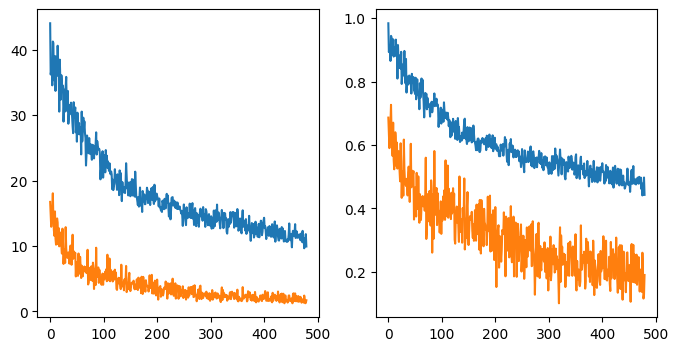

In [ ]:
start_num = 20

fig, axes = plt.subplots(1,2, figsize = (8, 4))
axes[0].plot(range(len(estimator_history["train_loss"])-start_num), estimator_history["train_loss"][start_num:])
axes[0].plot(range(len(estimator_history["validation_loss"])-start_num), list(map(lambda x: x.detach().cpu().numpy(), estimator_history["validation_loss"]))[start_num:])

axes[1].plot(range(len(estimator_history["train_abs"])-start_num), estimator_history["train_abs"][start_num:])
axes[1].plot(range(len(estimator_history["validation_abs"])-start_num), estimator_history["validation_abs"][start_num:])

In [ ]:
estimator.predict(torch.Tensor([0,0,7]))

94.1739501953125

In [ ]:
lenet5_model["linear_0"].get_size_in_bits()//8

134400

In [ ]:
best_pruned_model['linear_0'].get_size_in_bits()//8


23800

In [ ]:
early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-4,
    mode="min",
    patience=2,
    restore_best_state_dict=True,
)

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)



sensitivity = lenet5_model.get_layers_prune_channel_sensity_(
    input_shape=input_shape, data_loader=mnist_test_loader, metrics={"acc":accuracy_fun, "acc1":accuracy_fun}, device=DEVICE,
    train=False,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, 
)

AttributeError: 'Sequential' object has no attribute 'get_layers_prune_channel_sensity_'

6 [(0.0, 99.22), (0.16666666666666666, 97.47), (0.3333333333333333, 71.31), (0.5, 40.65), (0.6666666666666666, 28.36), (0.8333333333333334, 13.94)]
16 [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96), (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97), (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)]
84 [(0.0, 99.05), (0.011904761904761904, 99.08), (0.023809523809523808, 99.04), (0.03571428571428571, 99.2), (0.047619047619047616, 98.98), (0.05952380952380952, 99.19), (0.07142857142857142, 99.16), (0.08333333333333333, 99.09), (0.09523809523809523, 99.09), (0.10714285714285714, 99.11), (0.11904761904761904, 99.18), (0.13095238095238096, 99.07), (0.14285714285714285, 99.1), (0.15476190476190477, 99.08), (0.16666666666666666, 99.03), (0.17857142857142858, 99.28), (0.19047619047619047, 99.25), (0.20238095238095238, 99.17), (0.21428571428571427, 99.14), (0.2261904761904762, 99.07), (0.23

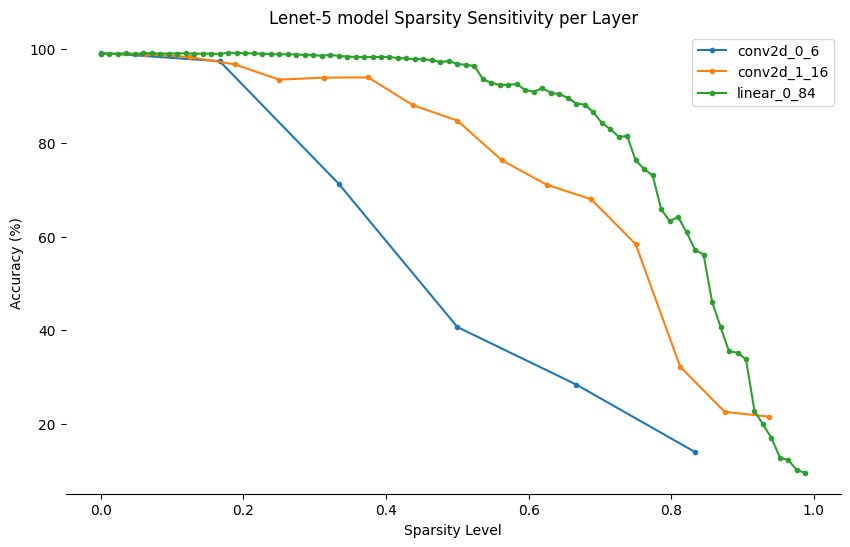

In [ ]:
plt.figure(figsize=(10, 6))
for layer, values in sensitivity['acc'].items():
    print(len(values), values)
    sparsity, acc = zip(*values)
    plt.plot(sparsity, acc, marker='.', label=layer+f"_{str(len(values))}")

plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy (%)")
plt.title("Lenet-5 model Sparsity Sensitivity per Layer")
plt.legend()
plt.grid(False)

list(plt.gca().spines.values())[0].set_visible(False)
list(plt.gca().spines.values())[1].set_visible(False)
list(plt.gca().spines.values())[3].set_visible(False)

plt.savefig("Lenet-5 model Sparsity Sensitivity per Layer", dpi=300, bbox_inches="tight")
plt.show()


4

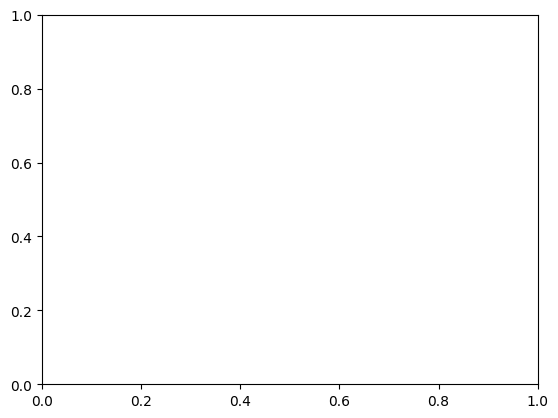

In [ ]:
len(plt.gca().spines.values())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product

# Your dataset
acc_data = {
    'conv2d_0': [(0.0, 99.22), (0.1667, 97.47), (0.3333, 71.31), (0.5, 40.65), (0.6667, 28.36), (0.8333, 13.94)],
    'conv2d_1': [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96),
                 (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97),
                 (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)],
    'linear_0': [
        (0.0, 99.05), (0.1667, 99.03), (0.3333, 98.61), (0.5, 96.88), (0.6667, 88.4),
        (0.75, 76.29), (0.8333, 57.14), (0.9167, 22.73), (1.0, 9.52)
    ]
}

# Build dataset as combinations of sparsities
X, y = [], []
for s0, _ in acc_data['conv2d_0']:
    for s1, _ in acc_data['conv2d_1']:
        for s2, acc in acc_data['linear_0']:
            # Features = sparsity levels
            X.append([s0, s1, s2])
            # Approx target = min accuracy among layers (proxy)
            y.append(acc)  

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Example prediction
test_sparsity = torch.tensor([[0.5, 0.25, 0.33]])  # (conv2d_0, conv2d_1, linear_0)
pred_acc = model(test_sparsity).item()
print(f"Predicted Accuracy: {pred_acc:.2f}%")


Epoch 100, Loss: 5958.7373
Epoch 200, Loss: 4314.2148
Epoch 300, Loss: 2123.2832
Epoch 400, Loss: 1662.4471
Epoch 500, Loss: 1510.1141
Predicted Accuracy: 58.12%


## Original Model


In [ ]:
lenet5_mcu_model = copy.deepcopy(lenet5_model)

evaluate_result = lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 239.41it/s]


The original model accuracy is 9915.00% with size 148240 bytes.
tensor([[-29.0016, -22.3953, -21.4715,  30.5191, -33.2081,   0.8119, -33.4459,
         -16.0511,  -6.0006,  -9.6175]], device='cuda:0')


(99.15, 148240)

In [ ]:
fused_lenet5_mcu_model = lenet5_mcu_model.fuse().to(DEVICE)

evaluate_result = fused_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = fused_lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# fused_lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
fused_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
# print(fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone()))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 231.04it/s]


The original model accuracy is 9911.00% with size 148088 bytes.
tensor([[-20.5041, -15.5337,  -1.6605,  -2.1882, -20.7473, -12.2588, -37.9503,
          14.2805, -11.3950,  -7.5340]], device='cuda:0')


(99.11, 148088)

In [ ]:
lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), 

(tensor([[-10.9922, -21.7113, -15.5854,   4.6235, -25.0249,   9.8817,  -9.2897,
          -15.5343,   0.8853,  -8.7347]], device='cuda:0'),)

In [ ]:
fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), \
fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# compression_dict = lenet5_mcu_model.get_all_compression_hyperparameter()
# print(len(compression_dict))
# print((compression_dict)[0])
# lenet5_mcu_model.decode_compression_dict_hyperparameter(compression_dict[0])

In [ ]:
# sp = .9

s = QuantizationScheme.DYNAMIC
g = QuantizationGranularity.PER_TENSOR
b = 4
compression_config = {
    # "prune_channel" :{
    #     "sparsity" : sp,
    #     "metric" : "l2"
    # },
    "quantize" : {
        "scheme" : s,
        "granularity": g,
        "bitwidth" : b
    }
}

# compressed_lenet5_mcu_model = lenet5_mcu_model.init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
compressed_lenet5_mcu_model = lenet5_mcu_model.fuse().init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
before_acc = compressed_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)["acc"]
# compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir)
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir)

size = compressed_lenet5_mcu_model.get_size_in_bits()//8
print(f"Before training, sparsity = {sp}, scheme = {s.name}, granularity = {g.name}, bitwidth = {b} acc = {before_acc:.4f} size = {size/original_size*100:9.4f} {100 - size/original_size*100:9.4f}")

print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir))
print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir))


100%|██████████| 313/313 [00:01<00:00, 171.57it/s]


NameError: name 'sp' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Setup the Data
data = {
    "Method": ["Quantization None (Float32)", "Dynamic Quantization", "Static Quantization (INT8)"],
    "DMC Size (Bytes)": [141896, 35490, 35898],
    "TFLite Size (Bytes)": [145060, 45224, 42240],
    "DMC Accuracy (%)": [99.07, 99.06, 99.03],
    "TFLite Accuracy (%)": [99.07, 99.07, 99.05],
    "DMC Time (ms)": [33.4, 41.9, 15.9],
    "TFLite Time (ms)": [31.4, 30.8, 3.6]
}

df = pd.DataFrame(data)

# --- FIGURE 1: THE TABLE ---
def create_table_image(dataframe):
    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')
    
    # Create the table
    table = ax.table(cellText=dataframe.values,
                     colLabels=dataframe.columns,
                     cellLoc='center',
                     loc='center')
    
    # Styling
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5) # Scale width and height
    
    # Header styling
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e') # Dark blue header
        else:
            if row % 2 == 0:
                cell.set_facecolor('#f1f1f2') # Alternating row colors
            else:
                cell.set_facecolor('white')

    plt.title("Table 4: Comparison of LeNet-5 on MNIST (DMC vs TFLite)", fontweight="bold", y=1.1)
    plt.tight_layout()
    plt.savefig('lenet_comparison_table.png', dpi=300, bbox_inches='tight')
    print("Generated: lenet_comparison_table.png")
    plt.close()

# --- FIGURE 2: VISUAL CHARTS (Bar Plots) ---
def create_charts(dataframe):
    labels = ["Float32", "Dynamic", "Static"]
    x = np.arange(len(labels))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
    
    # Plot 1: Model Size Comparison
    rects1 = ax1.bar(x - width/2, dataframe["DMC Size (Bytes)"], width, label='DMC', color='#1f77b4')
    rects2 = ax1.bar(x + width/2, dataframe["TFLite Size (Bytes)"], width, label='TFLite', color='#ff7f0e')
    
    ax1.set_ylabel('Model Size (Bytes)')
    ax1.set_title('Model Size Comparison (Lower is Better)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()
    
    # Plot 2: Inference Time Comparison
    rects3 = ax2.bar(x - width/2, dataframe["DMC Time (ms)"], width, label='DMC', color='#1f77b4')
    rects4 = ax2.bar(x + width/2, dataframe["TFLite Time (ms)"], width, label='TFLite', color='#ff7f0e')
    
    ax2.set_ylabel('Inference Time (ms)')
    ax2.set_title('Inference Time Comparison (Lower is Better)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()

    # --- REMOVE BOUNDING BOXES (SPINES) ---
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_visible(False)
        # Optional: Remove y-ticks line but keep grid
        ax.tick_params(axis='y', length=0)
    
    # Add value labels
    ax1.bar_label(rects1, padding=3, fmt='%d')
    ax1.bar_label(rects2, padding=3, fmt='%d')
    ax2.bar_label(rects3, padding=3, fmt='%.1f')
    ax2.bar_label(rects4, padding=3, fmt='%.1f')

    # plt.suptitle('DMC vs. TFLite Performance Analysis (LeNet-5)', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig('lenet_comparison_charts.png', dpi=300)
    print("Generated: lenet_comparison_charts.png")
    plt.show()
    plt.close()

if __name__ == "__main__":
    create_table_image(df)
    create_charts(df)

ModuleNotFoundError: No module named 'pandas'

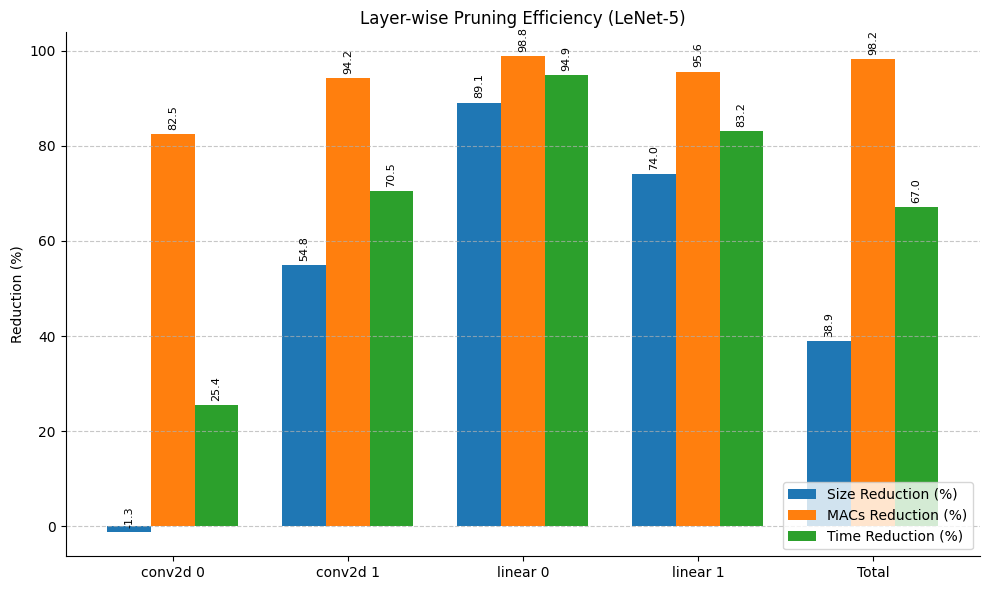

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
layers = ['conv2d 0', 'conv2d 1', 'linear 0', 'linear 1', 'Total']
red_size = [-1.3, 54.84, 89.07, 74.00, 38.90]
red_macs = [82.53, 94.17, 98.83, 95.59, 98.21]
red_time = [25.42, 70.48, 94.90, 83.15, 67.05]

# Set up the bar chart
x = np.arange(len(layers))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
rects1 = ax.bar(x - width, red_size, width, label='Size Reduction (%)', color='#1f77b4')
rects2 = ax.bar(x, red_macs, width, label='MACs Reduction (%)', color='#ff7f0e')
rects3 = ax.bar(x + width, red_time, width, label='Time Reduction (%)', color='#2ca02c')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Reduction (%)')
ax.set_title('Layer-wise Pruning Efficiency (LeNet-5)')
ax.set_xticks(x)
ax.set_xticklabels(layers)
ax.legend(loc='lower right') # Move legend to avoid covering data

# Add gridlines for readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('lenet_layerwise_pruning.png', dpi=300)
plt.show()

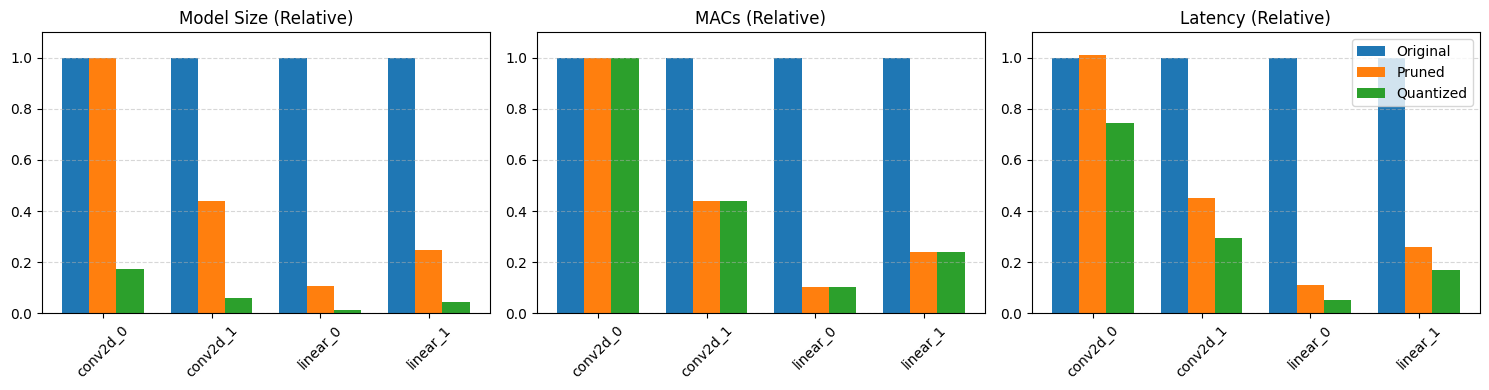

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

layers = ["conv2d_0", "conv2d_1", "linear_0", "linear_1"]

# Normalized values (1 = original)
size_original = np.ones(4)
size_pruned = np.array([1-0, 1-0.562, 1-0.8955, 1-0.7529])
size_quant = np.array([1-0.8253, 1-0.9417, 1-0.9883, 1-0.9559])

mac_original = np.ones(4)
mac_pruned = np.array([1-0, 1-0.5625, 1-0.8958, 1-0.7619])
mac_quant = mac_pruned.copy()  # quant MACs same as pruned in your table

time_original = np.ones(4)
time_pruned = np.array([1+0.013, 1-0.5484, 1-0.8907, 1-0.74])
time_quant = np.array([1-0.2542, 1-0.7048, 1-0.9490, 1-0.8315])

metrics = [
    ("Model Size (Relative)", size_original, size_pruned, size_quant),
    ("MACs (Relative)", mac_original, mac_pruned, mac_quant),
    ("Latency (Relative)", time_original, time_pruned, time_quant),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, (title, orig, pruned, quant) in zip(axes, metrics):
    x = np.arange(len(layers))
    width = 0.25

    ax.bar(x - width, orig, width, label="Original")
    ax.bar(x, pruned, width, label="Pruned")
    ax.bar(x + width, quant, width, label="Quantized")

    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=45)
    ax.set_title(title)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[-1].legend(loc="upper right")

plt.tight_layout()
plt.show()


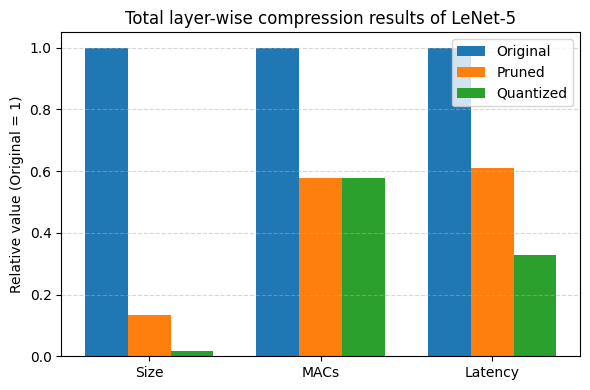

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Size", "MACs", "Latency"]
original = np.ones(3)
pruned = np.array([0.133, 0.578, 0.610])
quant = np.array([0.018, 0.578, 0.329])

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width, original, width, label="Original")
ax.bar(x, pruned, width, label="Pruned")
ax.bar(x + width, quant, width, label="Quantized")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Relative value (Original = 1)")
ax.set_title("Total layer-wise compression results of LeNet-5")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


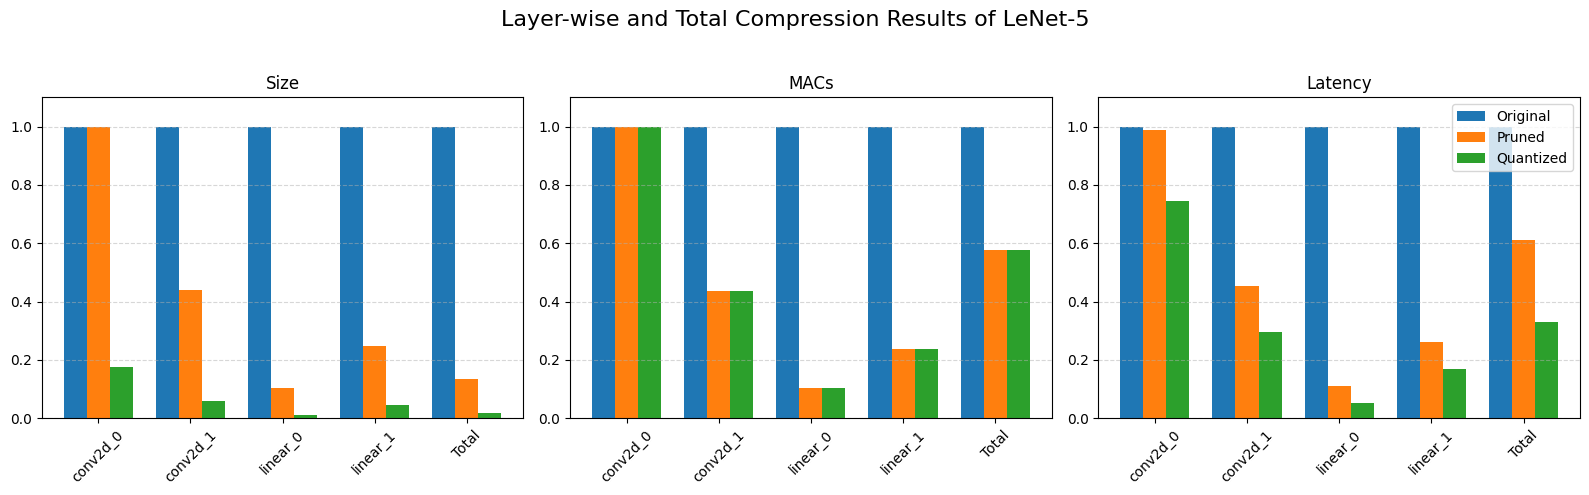

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Layers + total
layers = ["conv2d_0", "conv2d_1", "linear_0", "linear_1", "Total"]

# Normalized Size (Original = 1)
size_original = np.ones(5)  # Original for all layers and total
size_pruned = np.array([1-0, 1-0.562, 1-0.8955, 1-0.7529, 1-0.8668])
size_quant = np.array([1-0.8253, 1-0.9417, 1-0.9883, 1-0.9559, 1-0.9821])

# Normalized MACs
mac_original = np.ones(5)
mac_pruned = np.array([1-0, 1-0.5625, 1-0.8958, 1-0.7619, 1-0.4223])
mac_quant = mac_pruned.copy()  # From table

# Normalized Latency/Time
time_original = np.ones(5)
time_pruned = np.array([1+(-0.013), 1-0.5484, 1-0.8907, 1-0.74, 1-0.389])
time_quant = np.array([1-0.2542, 1-0.7048, 1-0.9490, 1-0.8315, 1-0.6705])

# All metrics in a list for iteration
metrics = [
    ("Size", size_original, size_pruned, size_quant),
    ("MACs", mac_original, mac_pruned, mac_quant),
    ("Latency", time_original, time_pruned, time_quant)
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

width = 0.25
x = np.arange(len(layers))

for ax, (title, orig, pruned, quant) in zip(axes, metrics):
    ax.bar(x - width, orig, width, label="Original")
    ax.bar(x, pruned, width, label="Pruned")
    ax.bar(x + width, quant, width, label="Quantized")
    
    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=45)
    ax.set_title(title)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
axes[-1].legend(loc="upper right")
fig.suptitle("Layer-wise and Total Compression Results of LeNet-5", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


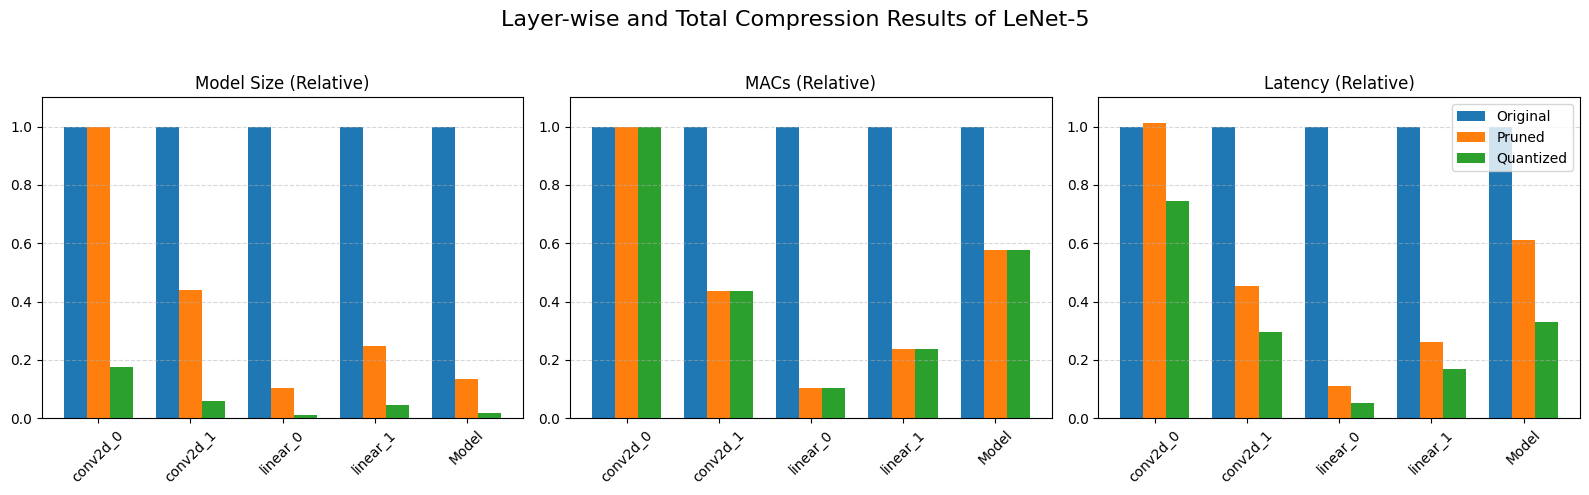

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Layers + total
layers = ["conv2d_0", "conv2d_1", "linear_0", "linear_1", "Model"]

# Normalized values (Original = 1)
size_original = np.ones(5)
size_pruned = np.array([1-0, 1-0.562, 1-0.8955, 1-0.7529, 1-0.8668])
size_quant = np.array([1-0.8253, 1-0.9417, 1-0.9883, 1-0.9559, 1-0.9821])

mac_original = np.ones(5)
mac_pruned = np.array([1-0, 1-0.5625, 1-0.8958, 1-0.7619, 1-0.4223])
mac_quant = mac_pruned.copy()  # quant MACs same as pruned in your table

time_original = np.ones(5)
time_pruned = np.array([1+0.013, 1-0.5484, 1-0.8907, 1-0.74, 1-0.389])
time_quant = np.array([1-0.2542, 1-0.7048, 1-0.9490, 1-0.8315, 1-0.6705])

metrics = [
    ("Model Size (Relative)", size_original, size_pruned, size_quant),
    ("MACs (Relative)", mac_original, mac_pruned, mac_quant),
    ("Latency (Relative)", time_original, time_pruned, time_quant),
]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

width = 0.25
x = np.arange(len(layers))

for ax, (title, orig, pruned, quant) in zip(axes, metrics):
    ax.bar(x - width, orig, width, label="Original")
    ax.bar(x, pruned, width, label="Pruned")
    ax.bar(x + width, quant, width, label="Quantized")
    
    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=45)
    ax.set_title(title)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[-1].legend(loc="upper right")
fig.suptitle("Layer-wise and Total Compression Results of LeNet-5", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import torch
import os
import sys
from torch.utils.data import DataLoader, TensorDataset

sys.path.append("../../")

# DMC Imports
import development
from development import Sequential
from development import Conv2d, Linear, ReLU, Flatten
from development import QuantizationScheme, QuantizationGranularity

# Defining constants
MODEL_VAR_NAME = "tiny_model"
DEPLOYMENT_BASE_DIR = hp_deployment_base_dir

# 1. Setup Dummy Data (Simulating MNIST)
print("[1] Generating Dummy Data...")
input_shape = (1, 28, 28) # N, C, H, W
X_train = torch.randn(100, 1, 28, 28) # 100 images
y_train = torch.randint(0, 10, (100,))
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=10)

# Calibration data is crucial for Static Quantization to find Min/Max ranges
calibration_data = X_train[0:10] 

# 2. Define the Architecture
# Using DMC layers (Conv2d, Linear) instead of torch.nn
print("[2] Defining Model...")
model = Sequential(
    # Input: 1 channel, Output: 4 filters, 3x3 kernel
    Conv2d(1, 4, kernel_size=3, pad=(1, 1, 1, 1)), 
    ReLU(),
    Flatten(),
    Linear(4 * 28 * 28, 10) 
)
model_size = model.get_size_in_bytes()

# 3. Define Compression Configuration
# We apply Structured Pruning (Stage 1) and 4-bit Static Quantization (Stage 2)
config = {
    "prune_channel": {
        "sparsity": 0.5,  # Remove 50% of filters/neurons
        "metric": "l2"    # Rank importance by L2 norm
    },
    "quantize": {
        "scheme": QuantizationScheme.STATIC, # Pre-compute scales for integer-only inference
        "bitwidth": 4,                       # Aggressive 4-bit compression
        "granularity": QuantizationGranularity.PER_TENSOR
    }
}

# 4. Initialize Compression Pipeline
# This sets up the pruning masks and quantization observers
print("[3] Initializing Compression Pipeline...")
compressed_model = model.init_compress(
    config, 
    input_shape=input_shape, 
    calibration_data=calibration_data
)
compressed_model_size = compressed_model.get_size_in_bytes()

# 5. Fine-Tune (Retraining)
# Recover accuracy lost due to pruning/quantization noise (QAT)
print("[4] Fine-tuning (Retraining)...")
optimizer = torch.optim.SGD(compressed_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

compressed_model.fit(
    train_dataloader=train_loader,
    epochs=2, # Short run for example
    criterion_fun=criterion,
    optimizer_fun=optimizer
)

# 6. Export to C (Stage 3)
# Generates the bit-packed C arrays and header files
print("[5] Exporting to C Code...")

src_dir = os.path.join(DEPLOYMENT_BASE_DIR, "src")
include_dir = os.path.join(DEPLOYMENT_BASE_DIR, "include")
os.makedirs(src_dir, exist_ok=True)
os.makedirs(include_dir, exist_ok=True)


test_input = X_train[:1]
compressed_model.convert_to_c(
    input_shape=input_shape,
    var_name=MODEL_VAR_NAME,
    src_dir=src_dir,
    include_dir=include_dir,
    test_input=test_input # Export one image for C++ verification
)

print(f"The expected output for for the test input is {compressed_model.output_quantize.apply(compressed_model(test_input)).tolist()}")
print(f"Model compressed from an initial size of {model_size/1024}KB to {compressed_model_size/1024}KB, a {(1 - (compressed_model_size/model_size))*100:.2f} reduction in size.")
print(f"Success! C files generated in {DEPLOYMENT_BASE_DIR}")

[1] Generating Dummy Data...
[2] Defining Model...
[3] Initializing Compression Pipeline...
[4] Fine-tuning (Retraining)...


DMC Training (Epochs 1-2):   0%|          | 0/2 [00:00<?, ?it/s]

DMC Training (Epochs 1-2):  50%|█████     | 1/2 [00:00<00:00,  8.88it/s]

epoch    0 | train loss 2.3822


DMC Training (Epochs 1-2): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]


epoch    1 | train loss 2.1749
[5] Exporting to C Code...
The expected output for for the test input is [[-1, -1, -6, -4, 1, -2, -8, -5, -4, -6]]
Model compressed from an initial size of 122.6953125KB to 7.732421875KB, a 93.70 reduction in size.
Success! C files generated in ./HP HP Pavilion Laptop 15-cs3xxx/


# 🧠 Deep MicroCompression (DMC)

> **Bare-Metal Deep Learning Inference for Resource-Constrained Microcontrollers**

**Deep MicroCompression (DMC)** is a hardware-aware compression pipeline designed to bridge the gap between modern neural networks and ultra-low-power microcontrollers (e.g., ATmega328P, Cortex-M4).

Unlike frameworks that rely on heavy runtime interpreters (like TFLite Micro), DMC optimizes the model at the bit-level and generates a **standalone, dependency-free C library** tailored for integer-only execution.

---

## 🚀 Key Features

### 1. Structured Channel Pruning
* **Dependency-Aware:** Automatically handles channel dependency propagation across layers (Conv2d $\to$ BatchNorm $\to$ ReLU).
* **Physical Reduction:** Unlike "mask-only" pruning, DMC physically removes filters and kernels, resulting in a smaller, dense model that requires no sparse matrix libraries.
* **Sensitivity Analysis:** Built-in tools to profile layer sensitivity (L2 norm) for optimal sparsity configuration.

### 2. Quantization
* **Flexible Precision Schemes:** Supports both Dynamic and Static quantization across configurable bitwidths (8-bit, 4-bit, 2-bit).
* **Quantization-Aware Training (QAT):** Simulates quantization noise during training to recover accuracy at low bitwidths (4-bit/2-bit).
* **Pure Integer Inference:** The Static Quantization mode pre-computes scaling factors and zero-points, enabling fully integer-based arithmetic. This eliminates the need for floating-point operations (FLOPs) at runtime, drastically reducing latency on bare-metal MCUs .

### 3. Hardware-Aware Bit-Packing
* **Compression:** Implements a fixed-length bit-packing scheme. Packs multiple weights (e.g., four 2-bit weights) into single bytes (`uint8_t`), maximizing flash storage density.
* **Fast Unpacking:** Uses optimized C macros (`define.h`) with shift/mask operations to decode weights on-the-fly, avoiding complex Huffman decoders.

### 4. Zero-Dependency C Export
* **Portable:** Generates generic C++ code compatible with any compiler (GCC, Clang) and architecture (AVR, RISC-V, ARM).
* **Static Allocation:** Calculates "Ping-Pong" SRAM buffer requirements (`MAX_OUTPUT_EVEN/ODD`) at compile time, eliminating dynamic memory allocation (`malloc`).

---

## 📊 Performance Highlights

| Model | Dataset | Compression Ratio | Accuracy Drop | Deployment Target |
| :--- | :--- | :--- | :--- | :--- |
| **LeNet-5** | MNIST | **55.8x** | < 1.5% | ATmega32 (2KB RAM) |
| **VGG-13** | CIFAR-100 | **~4x** | ~0.3% | Cortex-M4 |

*Comparison vs. TFLite Micro:* DMC achieves a **15% smaller binary footprint** on LeNet-5 by removing interpreter overhead 8].

---

## 🛠️ Project Architecture
```plaintext
.
├── deployment/                # C/C++ Inference Engine
│   ├── core/                  # Core macros and definitions
│   ├── layers/                # Bare-metal C++ layer implementations
│   ├── models/                # Generated C++ model containers
│   └── deep_microcompression.h # Single include entry point
│
├── development/               # Python Training & Compression Pipeline
│   ├── compressors/           # Pruning and Quantization engines
│   ├── layers/                # PyTorch layers augmented with masking/observers
│   ├── models/                # Sequential container & model definitions
│   ├── tools/                 # Utilities (Library generation, NAS Estimators)
│   └── utils.py               # Bit-packing math (Algorithm 1 & 3)
│
└── requirements.txt

## 💻 Usage Guide

### Phase 1: Exploration & Analysis (Optional)
Before compressing, analyze the model to find the optimal sparsity configuration (as seen in Appendix B).

**1. Sensitivity Analysis:**
[cite_start]Generate layer-wise accuracy drops to identify which layers can be pruned aggressively [cite: 203-204].
```python
from development.core.models import Sequential

# ... load pretrained model ...
sensitivity_data = model.get_layers_prune_channel_sensitivity(
    input_shape=(1, 1, 28, 28),
    data_loader=val_loader,
    metrics={"acc": accuracy_fn},
    train=True  # Enable retraining for accurate recovery estimation
)
# sensitivity_data contains the curves shown in Figure 3/4
```

Here is the Markdown code for the **Usage Guide**, **Embedded Integration**, and **Citation** sections.

````markdown
## 💻 Usage Guide

### Phase 1: Exploration & Analysis (Optional)
Before compressing, analyze the model to find the optimal sparsity configuration (as seen in Appendix B).

**1. Sensitivity Analysis:**
Generate layer-wise accuracy drops to identify which layers can be pruned aggressively.
```python
from development.core.models import Sequential

# ... load pretrained model ...
sensitivity_data = model.get_layers_prune_channel_sensitivity(
    input_shape=(1, 1, 28, 28),
    data_loader=val_loader,
    metrics={"acc": accuracy_fn},
    train=True  # Enable retraining for accurate recovery estimation
)
# sensitivity_data contains the curves shown in Figure 3/4
````

**2. Neural Architecture Search (NAS):**
Randomly sample sparsity configurations to find the "Lottery Ticket" configuration.

```python
search_results = model.get_nas_prune_channel(
    input_shape=(1, 1, 28, 28),
    data_loader=val_loader,
    metric_fun=accuracy_fn,
    num_data=100  # Sample 100 random architectures
)
```

-----

### Phase 1: Compression Pipeline

**1. Define & Train Baseline**

```python
from development.core.models import Sequential
from development.core.layers import Conv2d, Linear, ReLU, Flatten

model = Sequential(
    Conv2d(1, 6, kernel_size=5, pad=(2,2,2,2)),
    ReLU(),
    Flatten(),
    Linear(6*28*28, 10)
)
model.fit(train_loader, epochs=10, ...)
```

**2. Configure Pipeline (Pruning + Quantization)**
Apply the settings derived from your analysis.

```python
from development.core.utils import QuantizationScheme

config = {
    # Stage 1: Structured Pruning
    "prune_channel": {
        "sparsity": {
            "conv2d_0": 0.0,  # Keep sensitive input layers dense
            "conv2d_1": 0.5,  # Prune 50%
            "linear_0": 0.8   # Prune 80% of dense layer
        },
        "metric": "l2"
    },
    # Stage 2: Static Quantization
    "quantize": {
        "scheme": QuantizationScheme.STATIC,
        "bitwidth": 4,         # 4-bit Weights
        "granularity": "PER_TENSOR"
    }
}

# Transform model to Compressed State
# calibration_data is MANDATORY for Static Quantization to determine min/max ranges
compressed_model = model.init_compress(
    config, 
    input_shape=(1, 1, 28, 28), 
    calibration_data=train_sample+data
)
```

**3. Retrain (Fine-Tuning / QAT)**
Recover accuracy lost due to pruning and quantization noise.

```python
# The model is now in "Fake Quantization" mode with Masks active
compressed_model.fit(train_loader, epochs=5, ...)
```

**4. Export to C (Stage 3)**
Generate the dependency-free C library.

```python
# Generates: lenet5.h, lenet5_def.cpp, lenet5_params.cpp
compressed_model.convert_to_c(
    input_shape=(1, 1, 28, 28),
    var_name="lenet5",
    src_dir="./deployment_src",
    include_dir="./deployment_include"
)
```

-----

### Phase 3: Embedded Integration

**1. Generate the Runtime Engine**
Run the utility script to copy the core C++ files to your project.

```bash
python generate_library_tree.py /path/to/my/mcu/project/lib
```

**2. Include & Compile**
Add the generated files to your firmware project (PlatformIO, Keil, CMake).

```c
#include "deep_microcompression.h"
#include "lenet5.h" // Your generated model header

void main() {
    // 1. Prepare Input Data (Quantized to int8 if needed)
    int8_t input_buffer[784] = { ... };

    // 2. Run Inference
    // DMC automatically manages the Ping-Pong SRAM workspace
    lenet5.forward(input_buffer);

    // 3. Access Prediction
    // Result is in the output buffer of the last layer
    int8_t* logits = layers[LAYERS_LEN-1]->output;
    
    // ... post-processing (argmax) ...
}
```

-----

## 📑 Citation

If you use Deep MicroCompression in your research, please refer to the project repository or the associated paper:

```bibtex
@article{dmc2024,
  title={Deep Microcompression: Structured Pruning and Bit-packed Quantization for Microcontrollers},
  author={Surname, Name and Surname, Name},
  journal={IEEE/ACM Proceedings},
  year={2024}
}
```

-----

**License:** MIT
**Authors:** [Your Name/Org]

```
```